## 1. Introduction
This notebook analyzes the functional and sequence relationships from the study on bacteria from operational heating and cooling water systems, primarily in Germany. Using 16S rRNA data (bootstrap-validated from Notebook 5), this analysis employs PICRUSt2 to predict metabolic functions and compare functional profiles between different bacterial groups.

### Analysis Approaches
The notebook start by importing libraries, preparing the directories paths in section 1, section 2 prepares the data for the picrust pipeline on fasta, biom formates. Section 3-6 shows the process utilising directly algoritm for advance computer capabilities. The author approach utilises the Galaxy platform, where the original product files are found https://usegalaxy.eu/u/magicalex238/h/picrust2-functional. The results are imported on section 7 where a broad analysis is done on the global data exploring pathways,algoritm implementation, top general pathways and reactions. Section 8 involves retrieving the protein names for the granular data (EC contribution, ECcontri) from Galaxy results and for that utilises Uniprot Database. ECcontri_Uniprot data is analysed for the point of cutoff where the protein abundance has biological activity (Knee_abundance) for later use. Section 9 import several known and autoritative databases that are use to compile a new database (EC_records) comprising enzyme_names, mechanisms, pathways, metal_involved, protein hierarchi, reactions, amongst others. Then enriches the granular data with the newly created EC_records, put identifiers idx and introduce Sites and Categories. Section 10 is dedicated to the Filtering of protein-genus pairs pipeline on ECcontri_Uniprot_enriched. The data is classified by patterns, pathways (housekeeping, niche and mixed), separated between increasing, decreasing and mixed patterns, and the increasing patterns pairs are taken to the next step. The data is then prioritized by biological and statistical significance (prioritized_markers). Lastly is filtered with the knee abundance for biological activity (balanced_markers) and divided on marker_groups.
Then Section 11 visualise the results, made some clustering between related pairs and choses the top 10 markers to bring into the machine learning compendium repository where is join with the physicochemical data for a more comprensive prediction on corrosion by microbiologically induced corrosion.

### Directory Structure:
``` text
Sequence Analysis and Functional Prediction Pipeline
├── Introduction  
│   ├── 16S rRNA Data (bootstrap-validated)
│   └── imports, paths, preparation data
└── Analysis Approaches  
    ├── Direct Algorithm (Sections 3-6)  
    └── Galaxy Platform Analysis                             
         ├── Section 7: Broad Analysis (pathways, reactions)
         ├── Section 8: Protein Name Retrieval, data preparation
         ├── Section 9: Database Creation and Data enrichment
         │       ├──  EC_records: enzyme_names, mechanisms, pathways,
         │       └──  metal_involved, reactions, hierarchy...
         ├── Section 10: Filtering Protein-Genus Pairs pipeline
         │       ├── patterns_data, classified_results,
         │       └── prioritized_results...
         └── Section 11:Visualization & Machine Learning  
                 ├── Clustering related pairs  
                 ├── Top 10 markers  
                 └── further to ML (corrosion prediction)   

Picrust2 works using its reference database that was installed with the package   ~/miniconda3/envs/picrust2/lib/python3.9/site-packages/picrust2/default_files/prokaryotic/pro_ref

About picrust2  
https://evomics.org/wp-content/uploads/2015/01/presentation_evomics-05-picrust_01-18-15.pdf



# 2. Loading and Preparing the Data

## 2.1 Colab Initialisation

In [ ]:
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

In [ ]:
#os.path.exists('/content/drive/MyDrive')

#from google.colab import drive
#drive.flush_and_unmount()

In [ ]:
'''# Colab specific
from google.colab import drive
from google.colab import files
import os

drive.mount('/content/drive')

change the path
os.chdir('/content/drive/MyDrive/MIC/2_Micro/data_picrust')'''

In [ ]:
'''# Making sure to use same python version for compatibility
!sudo apt-get update -y
!sudo apt-get install python3.10
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
!python --version'''

__Importing PICRUST IN COLAB__

In [ ]:
'''# Install miniconda and initialize:
!wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!bash Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local/miniconda3
!conda config --add channels defaults
!conda config --add channels bioconda
!conda config --add channels conda-forge
# Imports for colab
import condacolab
import sys
sys.path.append('/usr/local/miniconda3/lib/python3.7/site-packages/')

# Install PICRUSt2 and its dependencies
%conda install -c bioconda -c conda-forge picrust2=2.4.1 -y
# Verify installations%
%conda list | grep picrust2'''

### Using Pro colab

In [ ]:
'''import sys
print([module for module in sys.modules if 'tensorflow' in module])'''

In [ ]:
'''# Set up memory footprint support libraries
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
%pip install humanize
%pip install memory_profiler
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('Using a high-RAM runtime!')'''


### Kaggle / Colab

In [1]:
!pip install psutil
import psutil
!pip install biopython
!pip install biom-format
!pip install umap-learn
!pip install fuzzywuzzy
!pip install lxml pandas
!pip install pyarrow
!pip install openpyxl
!pip install scipy
!pip install python-Levenshtein
!pip install -U kaleido
!pip install statsmodels
!pip install kneed
!pip install natsort
!python3 --version
!pip install adjustText

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 57.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 75.5 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for biom-format: filename=biom_format-2.1.16-cp310-cp310-linux_x86_64.whl size=12159053 sha256=adca608dfdf5634e6f6bea159c7dc112eab6f9702e7f20707160041b84b95c66
  Stored in directory: /root/.cache/pip/wheels/8e/a9/f9/197fd5a0e5bbab5f2e03c89194f6c194bed7af5d7a8c8759f3
Successfully built biom-format
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 61.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 

# 2.2. Importing Libraries,  Making Directories and Loading Data

In [2]:
# Standard library imports
import os
import sys
import ast
import subprocess
import logging
import time
from datetime import datetime
import shutil
from io import StringIO
from pathlib import Path
import re
from IPython import get_ipython
from IPython.display import display

# Data processing and analysis
import pandas as pd
import numpy as np
import openpyxl
import seaborn as sns
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from matplotlib.colors import to_rgba, LinearSegmentedColormap
import matplotlib.patches as mpatches
from collections import defaultdict
from collections import Counter 

# Machine learning and statistical analysis
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster import hierarchy
from sklearn.manifold import TSNE
import umap
import scipy
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.cluster.hierarchy as sch
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr, kruskal, mannwhitneyu
from kneed import KneeLocator
from scipy.signal import savgol_filter
from community import community_louvain
from joblib import Parallel, delayed

# Bioinformatics
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from biom import Table, load_table
from biom.util import biom_open
import xml.etree.ElementTree as ET
# Retrieval and requesting 
from lxml import etree
import requests

# Utility libraries
import gzip
import random
from natsort import natsorted
from typing import Dict, List, Tuple, Set, Optional
import pickle
import gc
import joblib
import h5py
import os
import csv
import json
import pyarrow.parquet as pq

os.environ['DISPLAY'] = ':0'
# Import global terms
try:
    sys.path.append('/kaggle/input/corrosion-scoring') 
    from global_terms import(metal_terms, corrosion_mechanisms, pathway_categories, corrosion_synergies, 
                            functional_categories,	  corrosion_keyword_groups,	  metal_mapping)
    print("Successfully imported pathway_categories from Kaggle path")
except ImportError:
    try:
        sys.path.append('/home/beatriz/MIC/2_Micro/corrosion_scoring')
        from corrosion_scoring.global_terms import (metal_terms, corrosion_mechanisms, pathway_categories, corrosion_synergies, 
                            functional_categories,	  corrosion_keyword_groups,	  metal_mapping)
        print("Successfully imported pathway_categories from local path")
    except ImportError as e:
        raise ImportError(f"Error: Could not import pathway_categories: {e}")
    from corrosion_scoring import scoring_system

Successfully imported pathway_categories from Kaggle path


In [4]:
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Directory Structure Definitions
SIMPLE_BASE = {
    'known': 'simple_known_mic',
    'other': 'simple_candidate_mic'
}

DETAILED_BASE = {
    'known': 'detailed_known_mic',
    'pure_checked': 'detailed_pure_checked_mic',
    'pure_core': 'detailed_pure_core_mic',
    'checked_core': 'detailed_checked_core_mic'
}

SUBDIRS = [
    'EC_predictions',
    'pathway_predictions',
    'KO_predictions',
    'other_picrust_files'
]
'''

# Base Paths
if "google.colab" in sys.modules:
    base_dir = Path("/content/drive/MyDrive/MIC/data_picrust")
else:
    base_dir = Path("/home/beatriz/MIC/2_Micro/data_picrust")
# ====================== VSCODE =====================================
#base dir for small files to git
base_dir = Path("/home/beatriz/MIC/2_Micro/data_picrust")

abundance_excel= Path("/home/beatriz/MIC/2_Micro/data_Ref/merged_to_sequence.xlsx")
fasta_file_final = Path("/home/beatriz/MIC/2_Micro/data_qiime/results_match_gg/final_sequences_gg.fasta")
aligned_fasta = Path("/home/beatriz/MIC/2_Micro/data_qiime/results_match_gg/aligned-dna-sequences_gg.fasta")

# Create output directory if it doesn't exist
output_base = base_dir / "output_base"
output_base.mkdir(parents=True, exist_ok=True)
# large galaxies input and output #large size dir for large files hosted instead in kaggle
large_dir = Path("/home/beatriz/MIC")
large_dir.mkdir(parents=True, exist_ok=True)
# databases
db_dir = large_dir / "Databases"
# input galaxies and uniprots
input_galaxy = large_dir / "data_galaxies"
# Directory to output large files # eccontris, compilated db
output_large = large_dir / "output_large"
output_large.mkdir(parents=True, exist_ok=True)

#========================== COLAB =================================
# for colab
# Create output directory if it doesn't exist
base_dir = Path("/content/drive/MyDrive/MIC/2_Micro/data_picrust")
base_dir.mkdir(parents=True, exist_ok=True)
abundance_excel= Path("/content/drive/MyDrive/MIC/2_Micro/data_picrustmerged_to_sequence.xlsx")
fasta_file_final = Path("/content/drive/MyDrive/MIC/2_Micro/data_picrust/final_sequences_gg.fasta")
aligned_fasta = Path("/content/drive/MyDrive/MIC/2_Micro/data_picrust/aligned-dna-sequences_gg.fasta")

output_base = base_dir  # Separate output directory
output_base.mkdir(parents=True, exist_ok=True)
large_dir = Path("/content/drive/MyDrive/MIC/")
large_dir.mkdir(parents=True, exist_ok=True)
db_dir = Path("/content/drive/MyDrive/MIC/Databases")
db_dir.mkdir(parents=True, exist_ok=True)
input_galaxy = large_dir / "data_galaxies"
# Directory to output large files # eccontris, compilated db
output_large = large_dir / "output_large"
output_large.mkdir(parents=True, exist_ok=True)
'''
## ========================= KAGGLE ==================================
# For Kaggle work
# Input datasets (read-only in Kaggle)
base_dir = Path("/kaggle/input/new-picrust") #base dir for small files to git /kaggle/input/new-picrust

# Files in small input directory
abundance_excel= base_dir / "merged_to_sequence.xlsx" # inside input small sizes input
fasta_file_final = base_dir  / "final_sequences_gg.fasta" # inside input small sizes

# Output for small files has to be changed for vscode no to push it to git
output_base = Path("/kaggle/working/output_base")
output_base.mkdir(parents=True, exist_ok=True)
#datasets large galaxies and databases
db_dir = Path("/kaggle/input/databases/Databases")
input_galaxy = Path("/kaggle/input/data-galaxies")

# Directory to output large files # eccontris, compilated db
large_dir =  Path("/kaggle/working/")

# Directory to output large files # eccontris, compilated db
output_large = large_dir / "output_large"
output_large.mkdir(parents=True, exist_ok=True)

The fasta file come from the Alternative Sequences finding from the Greenes Genes Database, from the taxonomy in this study made in section 7 in the 5_Sequences_qiime notebook: final_sequences_gg.fasta. Abundance dataframe come from the data from notebook 4 merged_to_sequence.xlsx sheet=core_check_usual_taxa which is a unified df between 3 different groups explained previously: cora_taxa (>20% 60 abundance features), usual_taxa (17 high literature ranking bacteria influencing corrosion) and checked_taxa (30 statistically significant to the corrosion risk label) in total 85 features.

In [5]:
# Integrated taxa from origin genus as headers with levels 6 for the genera, 7 for the GID, muss be cleaned
Integrated_T = pd.read_excel(abundance_excel, sheet_name='core_check_usual_taxa', header=[0,1,2,3,4,5,6,7], engine ='openpyxl')
# Drop first row (index 0) and first column in one chain
Integrated_T = Integrated_T.drop(index=0).drop(Integrated_T.columns[0], axis=1)
Integrated_T= Integrated_T.astype({'Sites': str})
Integrated_T['Sites'] = Integrated_T['Sites'].fillna('Source')
# Remove 'Unnamed' level names
Integrated_T.columns = Integrated_T.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))
# Changing dtypes to category whiles respecting structure
Integrated_T["Category"] = Integrated_T["Category"].astype("Int64")
Integrated_T= Integrated_T.set_index("Sites")
pre_Integrated = Integrated_T.T

## 2.3. Making Sequences for Picrust fasta file

Picrust Functional Analyiss requires a biom table with otus as index, samples as headers and abundance as values. The present biom has genus names but is needs instead Otus instead. The other input file for picrust is the representative sequences table that consist of the sequences per genera followed by the frequency of that genera on the whole sample, this is done directly by the software. The fasta file requires the otus instead of the genera names and the sequences non aligned coming from notebook 5. The following scrips will formate the data to picrust.

In [ ]:
# Read and modify sequences
new_records = []
for record in SeqIO.parse(fasta_file_final, "fasta"):
    match = re.search(r"\s(\d+)\s", record.description)  # Look for digits surrounded by spaces
    if match:
        otu_id = match.group(1)
    else:
        print(f"Warning: Could not extract OTU ID from description: {record.description}")
        continue  # Skip this record if OTU ID not found

    # Create new record with only OTU as ID
    new_record = SeqRecord(
        record.seq,
        id=otu_id,
        description=""  # Empty description to keep only ID
    )
    new_records.append(new_record)

# Write modified FASTA
output_fasta_path = output_base / "sequences_for_picrust.fasta"

SeqIO.write(new_records, output_fasta_path, "fasta")

## 2.4. Making of Dataframes for 2 Different Pipelines
The following script is the path to the biom file but also to the Integrate dataframe which create dataframes that discriminate its origin in order to pass then through picrust different pipelines, to know: Simple_Base that compares the known bacteria namely usual_taxa against the other features to understand their relationships on the function of their metabolism, an additional group is put forward as simply_candidate_mic which corresponds to the bacteria no previously linked to corrosion but showing an statistical significance with the risk label, those come from the checked_taxa and in this study are: genera(GID): Bulleida (154); Mycoplana (471), Oxobacter (512) and Oerskovia (). Also as showing an favor behaviour against corrosion are presented: Phenylobacterium (549), Gelria(334), Porphyrobacteria (564) and Tepidimonas (712)
SIMPLE_BASE = {'known': 'simple_known_mic', 'other': 'simple_candidate_mic'}
The second pipeline comprises a more detailed separation of the bacteria and that is: The Known bacteria as previously, pure_checked corresponding to the statistical significant genera, pure_core correspondent to the core taxa on the systems and the combination of the core and checked taxa.
DETAILED_BASE = {'known': 'detailed_known_mic','pure_checked': 'detailed_pure_checked_mic',
    'pure_core': 'detailed_pure_core_mic', 'checked_core': 'detailed_checked_core_mic'}

__Making the Integrated dataframe__
The original dataframe has a column for source, indicating from which df  came from (core, usual, checked), this script proceses that datadrame into individual dfs and the combined preserving the source for further analysis. The Integrated dataframe continues to be process on the next step to become the biom abundance df.

In [42]:
def process_integrated_data(df):
    """
    Process the integrated DataFrame to create a new DataFrame with clear column names
    and preserve all values including source information.

    Parameters:
    df (pandas.DataFrame): Input DataFrame with MultiIndex index and site columns

    Returns:
    pandas.DataFrame: Processed DataFrame with clear structure
    """

    # Extract genera and GIDs from the index MultiIndex
    genera = df.index.get_level_values(6)[1:]  # Skip first row
    gids = pd.to_numeric(df.index.get_level_values(7)[1:], errors='coerce')

    # Create a new DataFrame with the extracted information
    result_df = pd.DataFrame({
        'Genus': genera,
        'GID': gids
    })

    # Add the site values from the original DataFrame
    for col in df.columns:
        result_df[col] = df.iloc[1:][col].values

    # Clean up the DataFrame
    result_df['GID'] = pd.to_numeric(result_df['GID'], errors='coerce')
    result_df = result_df.dropna(subset=['GID'])
    result_df['GID'] = result_df['GID'].astype(int)

    return result_df

def get_taxa_groups(df):
    """
    Separate the processed DataFrame into different taxa groups based on Source column

    Parameters:
    df (pandas.DataFrame): Processed DataFrame from process_integrated_data()

    Returns:
    dict: Dictionary containing DataFrames for different taxa groups
    """
    # Split the data into groups based on 'Source' column patterns

    # Known corrosion bacteria (any pattern with 'us')
    known_bacteria = df[df['Source'].str.contains('us', case=False, na=False)]

    # Pure checked bacteria (only 'chk' without 'core' or 'us')
    pure_checked = df[
        df['Source'].str.contains('chk', case=False, na=False) &
        ~df['Source'].str.contains('core|us', case=False, na=False)
    ]

    # Pure core bacteria (only 'core' without 'chk' or 'us')
    pure_core = df[
        df['Source'].str.contains('core', case=False, na=False) &
        ~df['Source'].str.contains('chk|us', case=False, na=False)
    ]

    # Checked-core bacteria (contains both 'core' and 'chk' but no 'us')
    checked_core = df[
        df['Source'].str.contains('chk.*core|core.*chk', case=False, na=False) &
        ~df['Source'].str.contains('us', case=False, na=False)
    ]

    # Create groups dictionary
    taxa_groups = {
        'known_bacteria': known_bacteria,
        'pure_checked': pure_checked,
        'pure_core': pure_core,
        'checked_core': checked_core
    }

    # Print summary statistics
    print("\nDetailed Classification Results:")
    print(f"Known corrosion bacteria: {len(known_bacteria)}")
    print(f"Pure checked bacteria: {len(pure_checked)}")
    print(f"Pure core bacteria: {len(pure_core)}")
    print(f"Checked-core bacteria: {len(checked_core)}")

    # Verify total matches expected
    total_classified = len(known_bacteria) + len(pure_checked) + len(pure_core) + len(checked_core)
    print(f"\nTotal classified taxa: {total_classified}")
    print(f"Total in dataset: {len(df)}")

    return taxa_groups

# Usage example:
Integrated = process_integrated_data(pre_Integrated)

# Get the groups
taxa_groups = get_taxa_groups(Integrated)

# Access individual groups -
known_bacteria = taxa_groups['known_bacteria']
pure_core = taxa_groups['pure_core']
pure_checked = taxa_groups['pure_checked']
checked_core = taxa_groups['checked_core']

Integrated = process_integrated_data(pre_Integrated)
taxa_groups = get_taxa_groups(Integrated)


Detailed Classification Results:
Known corrosion bacteria: 17
Pure checked bacteria: 19
Pure core bacteria: 46
Checked-core bacteria: 3

Total classified taxa: 85
Total in dataset: 85

Detailed Classification Results:
Known corrosion bacteria: 17
Pure checked bacteria: 19
Pure core bacteria: 46
Checked-core bacteria: 3

Total classified taxa: 85
Total in dataset: 85


## 2.5. Making the Abundanc Biom dataframe for Picrust

The final biom should have as index the Otus numbers no the genera names and a clean formate

In [ ]:
# droping source and genus and putting GID as index
pre_biom= Integrated.drop(columns=["Source", "GID"])
pre_biom= pre_biom.set_index("Genus").astype(str)
# Ensure all data values are float
pre_biom = pre_biom.astype(float)

__changing genera to otus__

In [ ]:
# Create genus to OTU mapping from FASTA headers
genus_to_otu = {}
for record in SeqIO.parse(fasta_file_final, "fasta"):
    parts = record.description.split()
    if len(parts) >= 3:
        genus = parts[0]
        otu = parts[1]  # We'll use the first OTU number
        genus_to_otu[genus] = otu

# Print a few mappings to verify
print("Sample genus to OTU mappings:")
for i, (genus, otu) in enumerate(list(genus_to_otu.items())[:5]):
    print(f"{genus} -> {otu}")

# Replace genus with OTU in the index
pre_biom.index = pre_biom.index.map(lambda x: genus_to_otu.get(x, x))

# Remove the 'Genus' name from the index
pre_biom.index.name = "OTU"

__Calculation counts for picrust2__

In [ ]:
scaling_factor = 10000
# Multiply by scaling factor and round to nearest integer
count_pre_biom = np.round(pre_biom * scaling_factor).astype(int)
count_pre_biom

__Creating the biom table formate__

In [ ]:
# Create BIOM table with type specification
biom_table = Table(data=count_pre_biom.values,
                  observation_ids=count_pre_biom.index.astype(str),
                  sample_ids=count_pre_biom.columns.astype(str),
                  type="OTU table",
                  create_date=datetime.now().isoformat(),
                  generated_by="BIOM-Format",
                  matrix_type="sparse",
                  matrix_element_type="float")

# Save with explicit format
output_path = output_base / "count_abundance_85.biom"

with biom_open(output_path, 'w') as f:
    biom_table.to_hdf5(f, generated_by="BIOM-Format")

In [ ]:
# Validate the table structure
print("\nValidating table...")
!biom validate-table -i {output_path}
#/home/beatriz/MIC/2_Micro/data_picrust/count_abundance_85.biom

# Show table info
!biom summarize-table -i {output_path}

Validating table...

The input file is a valid BIOM-formatted file.
Num samples: 70
Num observations: 85
Total count: 56747993
Table density (fraction of non-zero values): 0.405

Counts/sample summary:
 Min: 181800.000
 Max: 990578.000
 Median: 851078.500
 Mean: 810685.614
 Std. dev.: 157876.192
 Sample Metadata Categories: None provided
 Observation Metadata Categories: None provided

Counts/sample detail:
site_69: 181800.000
site_67: 217903.000
site_70: 270600.000
site_26: 582999.000
site_21: 589725.000

# 3. Making the representative sequences

__Convert Abundance Biom table and the Sequences into a QIIME2 artifact__

In [ ]:
def create_rep_seqs_with_freq(sequence_file, pre_biom_df, output_fasta):
    """
    Create representative sequences with frequencies written to output

    Args:
        sequence_file: Path to FASTA file with OTU sequences
        pre_biom_df: DataFrame with abundance data
        output_fasta: Path to save sequences with frequencies
    """
    try:
        # Calculate total frequency for each OTU
        total_frequencies = round(pre_biom_df.sum(axis=1), 2)

        with open(output_fasta, 'w') as out:
            for record in SeqIO.parse(sequence_file, "fasta"):
                otu_id = record.id

                if otu_id in total_frequencies.index:
                    freq = total_frequencies[otu_id]
                    sequence = str(record.seq)

                    # Write sequence with frequency to FASTA
                    out.write(f">{otu_id} {sequence} {freq}\n")

        # First lines of the file
        print("Representative Sequences head:")
        with open(output_fasta, 'r') as f:
            for i, line in enumerate(f):
                if i < 1:  # Show first 3 sequences (header + sequence lines)
                    print(line.strip())
        return output_fasta

    except Exception as e:
        print(f"Error occurred: {e}")
    return None


# Representative sequences
sequences_for_picrust = output_base / "sequences_for_picrust.fasta"

output_fasta = output_base / "representative_sequences"

repres_sequ = create_rep_seqs_with_freq(sequences_for_picrust, pre_biom, output_fasta)
repres_sequ

__Disclamer:__ These notebook was mean to do the analysis of the functional mechanisms of bacteria using picrust2, however the capacity of the laptop was no sufficient to run it, nor colab on public library, nor a virtual machine, that is the reason why the analysis was undertaken in the galaxy website, where the data resides.
https://usegalaxy.eu/  
username= magicalex238

## 3.1. Classifying Bacteria by their Source DataFrame
Two distinct classification approaches are implemented to categorize bacteria. The simple approach (get_bacteria_sources_simple) divides bacteria into known corrosion-causers (usual_taxa) and candidates (all others). The detailed approach (get_bacteria_sources_detailed) provides finer categorization by separating bacteria into known corrosion-causers, pure checked taxa, pure core taxa, and those present in both checked and core datasets. Please notice that this function uses df Integrated for source clasification and no abundance.biom which will be used for the picrust2 pipeline.

In [43]:
def get_bacteria_sources_comprehensive(Integrated_df):
    """
    Comprehensive classification with all necessary combinations, returning lists of genus names.
    Also includes a combined list of specified categories.
    """
    genera = Integrated_df["Genus"]
    gids = Integrated_df["GID"]
    sources = Integrated_df['Source'] if 'Source' in Integrated_df.columns else None
    
    # Initialize empty lists for each category
    usual_bacteria = []  # anything with 'us'
    pure_checked = []    # only 'chk'
    pure_core = []       # only 'core'
    pure_usual = []      # only 'us'
    checked_core = []    # both 'chk' and 'core'
    checked_usual = []   # both 'chk' and 'us'
    core_usual = []      # both 'core' and 'us'
    all_three = []       # all three markers
    
    sources_found = set()
    
    for i, (genus, gid) in enumerate(zip(genera, gids)):
        if sources is not None:  # Check if source exists for this genus
            source = str(sources.iloc[i]).strip().lower()
            sources_found.add(source)
            
            # Check patterns
            has_us = 'us' in source
            has_chk = 'chk' in source
            has_core = 'core' in source
            
            # Overlapping categories (for union operations)
            if has_us:
                usual_bacteria.append(genus)
                
                if has_chk:
                    checked_usual.append(genus)
                
                if has_core:
                    core_usual.append(genus)
                
                if has_chk and has_core:
                    all_three.append(genus)
                    
                if not has_chk and not has_core:
                    pure_usual.append(genus)
            
            if has_chk and has_core:
                checked_core.append(genus)
            
            # Pure categories
            if has_chk and not has_core and not has_us:
                pure_checked.append(genus)
            
            if has_core and not has_chk and not has_us:
                pure_core.append(genus)

    # Sort all lists
    pure_checked.sort()
    pure_core.sort()
    pure_usual.sort()
    checked_core.sort()
    checked_usual.sort()
    core_usual.sort()
    all_three.sort()
    usual_bacteria.sort()
    # Create combined list of most interesting bacteria
    components = list(set(
        pure_checked + 
        checked_core + 
        checked_usual + 
        core_usual + 
        all_three
    ))
    components.sort() 
    # Print summary statistics
    print("\nComprehensive Classification Results:")
    print(f"Usual bacteria (any with 'us'): {len(usual_bacteria)}")
    print(f"Pure checked bacteria (only 'chk'): {len(pure_checked)}")
    print(f"Pure core bacteria (only 'core'): {len(pure_core)}")
    print(f"Pure usual bacteria (only 'us'): {len(pure_usual)}")
    
    print(f"Checked-core bacteria (both): {len(checked_core)}")
    print(f"Checked-usual bacteria (both): {len(checked_usual)}")
    print(f"Core-usual bacteria (both): {len(core_usual)}")
    print(f"In all three categories: {len(all_three)}")
    print(f"\nCombined bacteria (components): {len(components)}")
    
    # Print expected intersections
    print("\nIntersection Counts:")
    print(f"chk-us: {len(checked_usual)}")
    print(f"core-us: {len(core_usual)}")
    print(f"chk-core: {len(checked_core)}")
    print(f"all three: {len(all_three)}")
    print(f"components:{len(components)}")
    
    # Verify total matches expected
    unique_genera = set(pure_checked + pure_core + pure_usual + 
                      [g for g in checked_core if g not in all_three] + 
                      [g for g in checked_usual if g not in all_three] + 
                      [g for g in core_usual if g not in all_three] + 
                      all_three)
    
    print(f"\nTotal unique genera: {len(unique_genera)}")
    print(f"Total in dataset: {len(Integrated_df)}")
    print("\nSources found:", sources_found)
    
    return {
        'usual_bacteria': usual_bacteria,
        'pure_checked': pure_checked,
        'pure_core': pure_core,
        'pure_usual': pure_usual,
        'checked_core': checked_core,
        'checked_usual': checked_usual,
        'core_usual': core_usual,
        'all_three': all_three,
        'components': components
    }

In [44]:
results_dict = get_bacteria_sources_comprehensive(Integrated)
# Create a dictionary to hold the data for each sheet
sheet_data = {}

# For each category, create a DataFrame
for category, bacteria_list in results_dict.items():
    # Create a DataFrame with just the genus names
    df = pd.DataFrame({
        'Genus': bacteria_list
    })
    sheet_data[category] = df

# Save to Excel with one sheet per category
bacteria_clas_path = output_base / "bacteria_classification.xlsx"
with pd.ExcelWriter(bacteria_clas_path) as writer:
    for sheet_name, df in sheet_data.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)



Comprehensive Classification Results:
Usual bacteria (any with 'us'): 17
Pure checked bacteria (only 'chk'): 19
Pure core bacteria (only 'core'): 46
Pure usual bacteria (only 'us'): 4
Checked-core bacteria (both): 7
Checked-usual bacteria (both): 5
Core-usual bacteria (both): 12
In all three categories: 4

Combined bacteria (components): 35

Intersection Counts:
chk-us: 5
core-us: 12
chk-core: 7
all three: 4
components:35

Total unique genera: 85
Total in dataset: 85

Sources found: {'chk', 'core', 'us', 'chk-us', 'chk-core', 'core-us', 'chk-core-us'}


The lists will be utilised later in order to groupby this list int he analysis

## 3.2. Prepare picrust data and Creating Directories for PICRUSt2 Input
The check_missing_genera function processes the integrated data and handles data quality control. Known problematic genera (e.g., 'Clostridium_sensu_stricto_12', 'Oxalobacteraceae_unclassified') are flagged for exclusion to prevent analysis errors. The function also creates an organized directory structure as outlined in the introduction, with separate paths for different bacterial classifications (known_mic, candidate_mic, etc.) and their respective analysis outputs (EC_predictions, pathway_predictions, KO_predictions). Following function prepares the data for picrust analysis but both dataframes the abundance.biom and Integrated have some bacteria that were no sequenciated mostly cause are no known specimens. So it is necesary to do same procedure to both dfs.

In [ ]:
def prepare_picrust_data(Integrated_df, aligned_file, function_type='simple'):
    """
    Prepare data for PICRUSt analysis with choice of  function_type method

    Args:
        Integrated_df: Input DataFrame
        aligned_file: Path to aligned sequences
        function_type: 'simple' or 'detailed'
    """
    # Get bacteria source_groups based on chosen  function_type
    if  function_type == 'simple':
        source_groups = get_bacteria_sources_simple(Integrated_df)
    else:
        source_groups= get_bacteria_sources_detailed(Integrated_df)

    # Create appropriate directory structure
    create_directory_structure(function_type)

    return source_groups

def create_directory_structure(function_type='simple'):
    """Create directory structure for PICRUSt analysis"""
    base_dir = Path("/home/beatriz/MIC/2_Micro/data_picrust")
    base_dir.mkdir(parents=True, exist_ok=True)

    if function_type == 'simple':
        directories = SIMPLE_BASE
    else:
        directories = DETAILED_BASE

    # Create all required directories
    for dir_name in directories.values():
        for subdir in SUBDIRS:
            (base_dir / dir_name / subdir).mkdir(parents=True, exist_ok=True)
    logging.info("Directory structure created successfully")

    return True

'''  except Exception as e:
    logging.error(f"Error creating directory structure: {str(e)}")
    return False'''

In [ ]:
def verify_input_files():
    """Verify that input files exist and are readable"""
    missing_files = []

    if not fasta_file.exists():
        missing_files.append(str(fasta_file))
    if not biom_table.exists():
        missing_files.append(str(biom_table))

    if missing_files:
        logging.error(f"Missing input files: {', '.join(missing_files)}")
        return False

    logging.info("All input files found")
    return True

# 4. PICRUSt Pipeline Definition
The pipeline processes the aligned sequence data from notebook 5 that has or not undergo cleaning of the sequences as previously done on section 2. Also processes the biom_table in order to account on this anylsis on abundance. It queries the PICRUSt database to predict potential metabolic pathways for each genus. This prediction is based on evolutionary relationships and known genomic capabilities of related organisms.

In [ ]:
def run_picrust2_pipeline(fasta_file, biom_file, output_dir):
    """
    Run the main PICRUSt2 pipeline on input sequences and BIOM table.

    Args:
        fasta_file: Path to the aligned sequences FASTA file.
        biom_file: Path to the BIOM table (without extra columns).
        output_dir: Directory for PICRUSt2 output.
    """
    try:
        # Run main PICRUSt2 pipeline
        cmd = [
            'picrust2_pipeline.py',
            '-s', fasta_file,        # Input FASTA file with aligned sequences
            '-i', biom_file,         # BIOM table with abundance data
            '-o', output_dir,        # Output directory
            '--processes', '4',      # Parallel processes
            '--verbose',
            '--min_align', '0.25'    # Note the split here
        ]
        subprocess.run(cmd, check=True)

        # Add pathway descriptions if the pathway file exists
        pathway_file = os.path.join(output_dir, 'pathways_out/path_abun_unstrat.tsv.gz')
        if os.path.exists(pathway_file):
            cmd_desc = [
                'add_descriptions.py',
                '-i', pathway_file,
                '-m', 'PATHWAY',
                '-o', os.path.join(output_dir, 'pathways_with_descriptions.tsv')
            ]
            subprocess.run(cmd_desc, check=True)

        print(f"PICRUSt2 pipeline completed successfully for {output_dir}")
        return True

    except subprocess.CalledProcessError as e:
        print(f"Error running PICRUSt2: {e}")
        return False

# 5. Analysis of Pathways
The analysis focuses on metabolic pathways known to be involved in microbially influenced corrosion, including sulfur metabolism, organic acid production, iron metabolism, and biofilm formation. These pathways were selected based on documented mechanisms of known corrosion-inducing bacteria. Separate pipeline runs for simple and detailed classifications ensure proper pathway analysis for each bacterial group.

In [ ]:
def analyze_functional_profiles(picrust_output_dir, bacteria_list):
    """
    Analyze functional profiles with focus on corrosion-relevant pathways

    Parameters:
    picrust_output_dir: directory containing PICRUSt2 output
    bacteria_list: list of bacteria names to analyze
    """
    # Define corrosion-relevant pathways
    relevant_pathways = [
        'Sulfur metabolism',
        'Iron metabolism',
        'Energy metabolism',
        'Biofilm formation',
        'Metal transport',
        'ochre formation',
        'iron oxide deposits',
        'iron precipitation',
        'rust formation',
        'organic acid production',
        'acetate production',
        'lactate metabolism',
        'formate production',
    ]

    try:
        # Read PICRUSt2 output
        pathway_file = os.path.join(picrust_output_dir, 'pathways_with_descriptions.tsv')
        pathways_df = pd.read_csv(pathway_file, sep='\t')

        # Filter for relevant pathways
        filtered_pathways = pathways_df[
            pathways_df['description'].str.contains('|'.join(relevant_pathways),
                                                  case=False,
                                                  na=False)]

        # Calculate pathway abundances per bacteria
        pathway_abundances = filtered_pathways.groupby('description').sum()

        # Calculate pathway similarities between bacteria
        pathway_similarities = {}
        for bacteria in bacteria_list:
            if bacteria in pathways_df.columns:
                similarities = pathways_df[bacteria].corr(pathways_df[list(bacteria_list)])
                pathway_similarities[bacteria] = similarities

        # Predict functional potential
        functional_predictions = {}
        for pathway in relevant_pathways:
            pathway_presence = filtered_pathways[
                filtered_pathways['description'].str.contains(pathway, case=False)
            ]
            if not pathway_presence.empty:
                functional_predictions[pathway] = {
                    'presence': len(pathway_presence),
                    'mean_abundance': pathway_presence.mean().mean(),
                    'max_abundance': pathway_presence.max().max()
                }

        # Calculate correlation scores
        correlation_scores = {}
        for bacteria in bacteria_list:
            if bacteria in pathways_df.columns:
                correlations = pathways_df[bacteria].corr(
                    pathways_df[filtered_pathways.index]
                )
                correlation_scores[bacteria] = {
                    'mean_correlation': correlations.mean(),
                    'max_correlation': correlations.max(),
                    'key_pathways': correlations.nlargest(5).index.tolist()
                }

        comparison_results = {
            'pathway_similarities': pathway_similarities,
            'functional_predictions': functional_predictions,
            'correlation_scores': correlation_scores,
            'pathway_abundances': pathway_abundances.to_dict()
        }

        return filtered_pathways, comparison_results

    except Exception as e:
        print(f"Error in pathway analysis: {str(e)}")
        return None, None

## 5.2. Testing the pipeline

In [ ]:
'''# ---- RUNNING THE PIPELINE ----

# Set paths
fasta_file = Path('/home/beatriz/MIC/2_Micro/data_tree/accession_sequences.fasta')
abundance_biom_file =  Path('/home/beatriz/MIC/2_Micro/data_picrust/abundance_accession.biom')
output_dir = 'picrust_output'

# List of bacteria to analyze
bacteria_of_interest = ['Azospira', 'Brachybacterium', 'Bulleidia']

# Run PICRUSt2
if run_picrust2_pipeline(aligned_fasta_file,
                         abundance_biom_file,
                         output_dir
                        ):
    # Analyze functional profiles if the pipeline completes successfully
    filtered_pathways, abundances = analyze_functional_profiles(output_dir, bacteria_of_interest)'''

# 6. Functional Analysis
## 6.1 Running picrust full pipeline 1
The analysis workflow begins by categorizing bacteria into source groups using the classification functions. These categorized data are then processed through the PICRUSt pipeline to predict metabolic capabilities. The functional analysis examines pathway presence, abundance, and correlations between different bacterial groups to identify potential corrosion-related metabolic patterns.

In [ ]:
def run_functional_analysis(df, Integrated_df, aligned_file, analysis_type='simple'):
    """
    Run complete functional analysis pipeline for either simple or detailed classification

    Parameters:
    df: Input DataFrame
    aligned_file: Path to aligned sequences file
    analysis_type: 'simple' or 'detailed'
    """
    try:
        print(f"\n{'='*50}")
        print(f"Starting {analysis_type} classification analysis")
        print(f"{'='*50}")

        # Prepare data and get source groups
        print("\nStep 1: Preparing data...")

        source_groups = prepare_picrust_data(Integrated_df, aligned_file, function_type=analysis_type)

        if not source_groups:
            raise ValueError("Failed to prepare data: No source groups returned")

        # Base directory for PICRUSt output
        base_dir = Path("~MIC/2_Micro/data_picrust")

        results = {}

        if analysis_type == 'simple':
            # Run analysis for simple classification
            # Known bacteria
            known_output_dir = base_dir /SIMPLE_BASE['known']
            success_known = run_picrust2_pipeline(aligned_file, df, str(known_output_dir))
            if success_known:
                results_known = analyze_functional_profiles(str(known_output_dir),
                                                        source_groups['known_bacteria'].keys())

            # Other bacteria
            other_output_dir = base_dir / SIMPLE_BASE['other']
            success_other = run_picrust2_pipeline(aligned_file, str(other_output_dir))
            if success_other:
                results_other = analyze_functional_profiles(str(other_output_dir),
                                                        source_groups['other_bacteria'].keys())

        else:
            # Run analysis for detailed classification
            for group, dir_name in DETAILED_BASE.items():

                # Known bacteria
                known_output_dir = base_dir / DETAILED_BASE['known']
                success_known = run_picrust2_pipeline(aligned_file, str(known_output_dir))
                if success_known:
                    results_known = analyze_functional_profiles(str(known_output_dir),
                                                            source_groups['known_bacteria'].keys())

                # Pure checked bacteria
                checked_output_dir = base_dir /  DETAILED_BASE['pure_checked']
                success_checked = run_picrust2_pipeline(aligned_file, str(checked_output_dir))
                if success_checked:
                    results_checked = analyze_functional_profiles(str(checked_output_dir),
                                                            source_groups['pure_checked'].keys())

                # Pure core bacteria
                core_output_dir = base_dir /DETAILED_BASE['pure_core']
                success_core = run_picrust2_pipeline(aligned_file, str(core_output_dir))
                if success_core:
                    results_core = analyze_functional_profiles(str(core_output_dir),
                                                            source_groups['pure_core'].keys())

                # Checked-core bacteria
                checked_core_output_dir = base_dir /DETAILED_BASE['checked_core']
                success_checked_core = run_picrust2_pipeline(aligned_file, str(checked_core_output_dir))
                if success_checked_core:
                    results_checked_core = analyze_functional_profiles(str(checked_core_output_dir),
                                                                    source_groups['checked_core'].keys())
    except subprocess.CalledProcessError as e:
        print(f"Error running PICRUSt2: {e}")

        return "Analysis completed successfully"

In [ ]:
'''# Run the analysis for both types
# Simple source classification
simple_results = run_functional_analysis(biom_table, aligned_file, analysis_type='simple') # output_biom

# Detailed source classification
detailed_results = run_functional_analysis(biom_table, aligned_file, analysis_type='detailed')'''

## 6.2 Running picrust full pipeline 2

In [ ]:
def run_picrust2_pipeline(fasta_file, output_dir, min_align =0.5):
    """
    Run PICRUSt2 pipeline with improved error handling and path management

    Args:
        fasta_file: Path to aligned sequences fasta file (str or Path)
        output_dir: Directory for PICRUSt2 output (str or Path)
    """
    # Convert paths to strings
    fasta_file = str(fasta_file)
    output_dir = str(output_dir)

    try:
        # Verify picrust2 is available
        picrust_check = subprocess.run(['which', 'picrust2_pipeline.py'],
                                     capture_output=True,
                                     text=True)
        if picrust_check.returncode != 0:
            raise RuntimeError("picrust2_pipeline.py not found. Please ensure PICRUSt2 is properly installed.")

        # Create output directory
        os.makedirs(output_dir, exist_ok=True)

        # Construct command as a single string
        cmd = f"picrust2_pipeline.py -s {fasta_file} -i {fasta_file} -o {output_dir} --processes 1 --verbose"

        # Run pipeline
        print(f"Running command: {cmd}")
        process = subprocess.run(cmd,
                               shell=True,  # Use shell to handle command string
                               check=True,
                               capture_output=True,
                               text=True)

        print("PICRUSt2 Output:")
        print(process.stdout)

        if process.stderr:
            print("Warnings/Errors:")
            print(process.stderr)

        # Add descriptions if pathway file exists
        pathway_file = os.path.join(output_dir, 'pathways_out/path_abun_unstrat.tsv.gz')
        if os.path.exists(pathway_file):
            desc_cmd = f"add_descriptions.py -i {pathway_file} -m PATHWAY -o {os.path.join(output_dir, 'pathways_with_descriptions.tsv')}"
            subprocess.run(desc_cmd, shell=True, check=True)

        print(f"PICRUSt2 pipeline completed successfully for {output_dir}")
        return True

    except subprocess.CalledProcessError as e:
        print(f"Error running PICRUSt2 command: {e}")
        print(f"Command output: {e.output}")
        return False
    except Exception as e:
        print(f"Error in pipeline: {str(e)}")
        return False

In [ ]:
'''# For original sequences
aligned_file = aligned_fasta
success = run_picrust2_pipeline(aligned_file, output_large)

# For improved sequences
optimized_file = output_large / "picrust_optimized_sequences.fasta")
optimized_output = Path("~/MIC/2_Micro/data_picrust/optimized_results")
success_opt = run_picrust2_pipeline(optimized_file, optimized_output)'''

# 7. Findings and Analysis

The PICRUSt2 pipeline generated a series of interconnected files revealing the functional potential of the microbial community. These files collectively map metabolic pathways, enzymatic functions, and taxonomic relationships, providing a multi-layered view of microbial functional capabilities across samples. Detailed view of the files found in the folder ~data_picrust are located in the manuscript.

Picrust_Result_SEPP and Picrust_Result_EPA contain the descriptions, pathways and abundance of the full pipeline of picrust.

In [ ]:
MetaCyc_EPA_path = input_galaxy / "Galaxy19_PICRUSt2_Add_descriptions_on_data_8.tabular"
Picrust_Result= pd.read_csv(MetaCyc_EPA_path, sep = "\t")
Picrust_Result_EPA= pd.read_csv(MetaCyc_EPA_path, sep = "\t")
Picrust_Result_EPA.set_index("description", inplace=True)
Picrust_Result_EPA = Picrust_Result_EPA.drop("pathway", axis=1)
Picrust_Result_EPA.index.name = "pathway"
MetaCyc_SEPP_path = input_galaxy / "Galaxy35_Add_descriptions_SEPP.tabular"
Picrust_Result_SEPP= pd.read_csv(MetaCyc_SEPP_path, sep = "\t")
Picrust_Result_SEPP.set_index("description", inplace=True)
Picrust_Result_SEPP = Picrust_Result_SEPP.drop("pathway", axis=1)
Picrust_Result_SEPP.index.name = "pathway"

## 7.1. Placement Algorithm EPA vs SEPP
nsti_SEPP and nsti_EPA Corresponds to a sample-wide measure of how closely related the microbial taxa in that sample are to known reference genomes with two different placement algoritms.

In [ ]:
nsti_path_EPA = Path(input_galaxy  / "Galaxy13_EC_weighted_nsti.tabular")
nsti_EPA= pd.read_csv(nsti_path_EPA, sep = "\t")
nsti_path_SEPP = Path(input_galaxy  / "Galaxy20_EC_weighted_nsti_SEPP.tabular")
nsti_SEPP= pd.read_csv(nsti_path_SEPP, sep = "\t")

In [ ]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(nsti_EPA['sample'], nsti_EPA['weighted_NSTI'], alpha=0.5, label= "EPA", color="blue")
plt.scatter(nsti_SEPP['sample'], nsti_SEPP['weighted_NSTI'], alpha=0.5, label= "SEPP", color="gray")

# Add the threshold line
plt.axhline(y=0.15, color='black', linestyle='--', label='Threshold (0.15)')

# Customize the plot
plt.title('NSTI Values by Site')
plt.xlabel('Site')
plt.ylabel('NSTI Value')
plt.legend()

# Rotate x-axis labels if there are many samples
plt.xticks(rotation=90)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Interestingly, the results are no as expected, it was though that the algorithm for placing the sequences more convenient for the present samples was SEPP because it is design specially for 16sRNA samples and diverse microbios communities, however the samples show another story. I fail to realise that the present data has been validated with the greenes genes database with the purpose of finding more compatibility with the picrust2 database, and therefore the EPA algoritm is performing much better on the all of samples using EPA placement algoritm.

## 7.2. Explore Pathway Patterns
The pathway analysis strategy is to do a preliminar exploration before diving into specific hypotheses about organic matter metabolism and corrosion. It was chosen to start with unbiased exploratory data analysis of the PICRUSt pathways. The aim is to let the data reveal natural patterns without preconceptions. That helps to identify unexpected relationships between pathways, providing a baseline understanding of pathway distributions and relationships. This will guide subsequent targeted analyses of corrosion-relevant pathways.
The following script takes multiple perspectives in order to visualise the data without bias and let it reveal itself. We do PCA for linear patterns, NMF for modular organization, UMAP for non-linear relationships and take different clustering approaches. The aim being to look for natural Patterns without predefined categories, so that strong strong correlations can be identified regardless of pathway type. It is visualised the distribution of pathway abundances, correlation structure, hierarchical relationships and non-linear patterns

__Category Dict__

In [ ]:
# Define category dict outside so that all charts can use same dict

category_dict = Integrated_T.T.iloc[0, 0:-1].to_dict()

# Define colors and categories
category_colors = {1: '#008800',  # Dark green
                   2: '#FF8C00',  # Dark orange
                   3: '#FF0000'}   # Red

categories_labels = {1: 'Normal Operation',
              2: 'Early Warning',
              3: 'System Failure'}

In [ ]:
def explore_pathway_patterns(df):
    """
    Explore pathway patterns using multiple analytical approaches
    """
    # Standardize data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    results = {}

    def plot_exploration_results(df, results, category_dict, category_colors, categories_labels):
        """
        Create visualizations for the exploratory analysis with consistent category colors
        """
        # 1. Distribution of pathway abundances with category colors - side by side
        plt.figure(figsize=(12, 6))

        # Create dictionary to store abundances by category
        category_abundances = {cat_id: [] for cat_id in categories_labels.keys()}

        # Group abundances by category
        for site_col in df.columns:
            if site_col.startswith('site_'):
                site_num = int(site_col.split('_')[1])
                category = category_dict.get(f'site_{site_num}', 0)
                if category in category_abundances:
                    category_abundances[category].extend(df[site_col].values)

        # Plot distribution for each category side by side
        for category_id in categories_labels.keys():
            sns.histplot(data=category_abundances[category_id],
                        bins=50,
                        color=category_colors[category_id],
                        label=categories_labels[category_id],
                        alpha=0.6,
                        multiple="layer")

        plt.title('Distribution of Pathway Abundances by Category')
        plt.xlabel('Abundance')
        plt.yscale('log')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # 2. PCA Dimensionality Reduction
    pca = PCA(n_components=5)
    X_pca = pca.fit_transform(scaled_data)
    results['pca'] = {
        'components': X_pca,
        'explained_variance': pca.explained_variance_ratio_,
        'loadings': pd.DataFrame(
            pca.components_.T,
            index=df.columns,
            columns=[f'PC{i+1}' for i in range(5)])}

    # 3 NMF for pathway modules
    nmf = NMF(n_components=5, init='random', random_state=0, max_iter=400)
    W = nmf.fit_transform(df.clip(lower=0))
    H = nmf.components_
    results['nmf'] = {
        'W': pd.DataFrame(W, index=df.index, columns=[f'NMF{i+1}' for i in range(5)]), # Pathway contributions
        'H': pd.DataFrame(H, columns=df.columns, index=[f'NMF{i+1}' for i in range(5)]), # Sample patterns
        'reconstruction_err': nmf.reconstruction_err_ }

    # 4 UMAP for non-linear patterns
    umap_reducer = umap.UMAP(random_state=0)
    umap_result = umap_reducer.fit_transform(scaled_data)
    results['umap'] = pd.DataFrame(umap_result, index=df.index, columns=['UMAP1', 'UMAP2'])

    # 5. Multiple Clustering Approaches / Hierarchical clustering
    linkage_matrix = hierarchy.linkage(scaled_data, method='ward')

    # Try different numbers of clusters
    cluster_results = {}
    for n_clusters in [5, 10, 15]:
        # Hierarchical
        hc = AgglomerativeClustering(n_clusters=n_clusters)
        hc_labels = hc.fit_predict(scaled_data)

        # K-means
        km = KMeans(n_clusters=n_clusters, random_state=0)
        km_labels = km.fit_predict(scaled_data)

        cluster_results[n_clusters] = {'hierarchical': pd.Series(hc_labels, index=df.index, name='cluster'),
            'kmeans': pd.Series(km_labels, index=df.index, name='cluster')}

    results['clustering'] = cluster_results
    results['linkage'] = linkage_matrix

    # 4. Correlation Analysis/Spearman correlation for non-linear relationships
    corr_matrix = spearmanr(df.T)[0]
    results['correlation'] = pd.DataFrame(corr_matrix, index=df.index, columns=df.index)

    return results, X_pca

def plot_exploration_results(df, results, category_dict, category_colors, categories_labels):
    """
    Create visualizations for the exploratory analysis with colored categories_labels
    """
    # Modified PCA visualization with categories
    plt.figure(figsize=(15, 10))

    # Create subplots
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 6), results['pca']['explained_variance'], 'bo-')
    plt.title('PCA Explained Variance')
    plt.xlabel('Component')
    plt.ylabel('Explained Variance Ratio')

    plt.subplot(1, 2, 2)

    # Get PCA components
    pca_data = results['pca']['components']

    # Plot each category separately to create the legend
    for category_id in categories_labels.keys():
        # Get indices for current category
        category_mask = [category_dict.get(f'site_{i+1}', 0) == category_id
                        for i in range(len(pca_data))]

        # Plot points for current category
        plt.scatter(pca_data[category_mask, 0],
                   pca_data[category_mask, 1],
                   c=category_colors[category_id],
                   label=categories_labels[category_id],
                   alpha=0.6)

    plt.title('PCA First Two Components')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.tight_layout()
    plt.show()


    # 3. UMAP visualization with categories
    plt.figure(figsize=(10, 8))
    umap_df = results['umap']

    for category_id in categories_labels.keys():
        category_mask = [category_dict.get(f'site_{i+1}', 0) == category_id
                        for i in range(len(umap_df))]
        category_data = umap_df[category_mask]

        plt.scatter(category_data['UMAP1'],
                   category_data['UMAP2'],
                   c=category_colors[category_id],
                   label=categories_labels[category_id],
                   alpha=0.6)

    plt.title('UMAP Projection of Pathways by Category')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 4. Hierarchical clustering dendrogram - simplified version
    plt.figure(figsize=(15, 10))
    dendrogram = hierarchy.dendrogram(
        results['linkage'],
        labels=df.index,  # Use index , columns instead of index
        leaf_rotation=90,
        leaf_font_size=8
    )
    plt.title('Pathway Clustering Dendrogram')
    plt.tight_layout()
    plt.show()

    # 5. Correlation heatmap
    plt.figure(figsize=(12, 12))
    mask = np.triu(np.ones_like(results['correlation']))

    # Create a custom colormap that uses our category colors
    custom_cmap = sns.diverging_palette(220, 20, as_cmap=True)

    sns.heatmap(results['correlation'],
                mask=mask,
                cmap=custom_cmap,
                center=0,
                vmin=-1,
                vmax=1)
    plt.title('Pathway Correlation Heatmap')
    plt.tight_layout()
    plt.show()

def identify_key_patterns(df, results):
    """
    Identify and summarize key patterns in the data
    """
    patterns = {}

    # Find highly correlated pathway groups
    corr = results['correlation']
    high_corr = pd.DataFrame(
        [(i, j, corr.loc[i,j])
         for i in corr.index
         for j in corr.index
         if i < j and abs(corr.loc[i,j]) > 0.8],
        columns=['pathway1', 'pathway2', 'correlation']
    ).sort_values('correlation', ascending=False)

    # Find pathways with strong PCA loadings
    loadings = results['pca']['loadings']
    strong_loadings = pd.DataFrame({
        'PC1_contribution': abs(loadings['PC1']),
        'PC2_contribution': abs(loadings['PC2'])
    }).sort_values('PC1_contribution', ascending=False)

    patterns['high_correlations'] = high_corr
    patterns['strong_loadings'] = strong_loadings

    return patterns

In [ ]:
# Calling the function for the pipeline using EPA algoritm
results_SEPP, X_pca_SEPP = explore_pathway_patterns(Picrust_Result_SEPP)
plot_exploration_results(Picrust_Result_SEPP, results_SEPP, category_dict, category_colors, categories_labels)
patterns_SEPP = identify_key_patterns(Picrust_Result_SEPP, results_SEPP)

In [ ]:
# Calling the function for the pipeline using EPA algoritm
results_EPA, X_pca_EPA = explore_pathway_patterns(Picrust_Result_EPA)
plot_exploration_results(Picrust_Result_EPA, results_EPA, category_dict, category_colors, categories_labels)
patterns_EPA = identify_key_patterns(Picrust_Result_EPA, results_EPA)

__Discussing first results__

The distribution of pathway abundances shows a typical microbial community pattern with few dominant pathways, suggesting key metabolic processes are essential across samples. PCA analysis reveals that only two components explain over 80% of the variance, indicating that metabolism in these systems might be driven by two major functional groups. The UMAP visualization confirms this binary pattern through two distinct clusters, demonstrating the robustness of this separation across different dimensional reduction techniques. The hierarchical clustering dendrogram further validates this division by showing two major branches, which notably align with previously observed physicochemical patterns in our Pourbaix plot analysis. The correlation heatmap exhibits strong relationships between specific pathway groups, suggesting coordinated metabolic activities that require detailed pathway mapping for full biological interpretation. EPA sequence placement shows much better differenciation on the pc plot.

In [ ]:
Picrust_Result_EPA.head()

## 7.3. Distribution of pathway abundances and Heatmap Hierarchies
In the following script we map the column pathway on the dataframe Picrust_Result_raw to the actual names provided by the Galaxy website that corresponds to the MetaCyc pathways. We will end up with the original Picrust_Results df with disernible names.After the 20 most abundant pathways will be plotted and the heatmap with the hierarchichal pathways drawn.

In [ ]:
# Define category dict outside so that all charts can use same dict

category_dict = Integrated_T.T.iloc[0, 0:-1].to_dict()

# Define colors and categories
category_colors = {1: '#008800',  # Dark green
                   2: '#FF8C00',  # Dark orange
                   3: '#FF0000'}   # Red

categories_labels = {1: 'Normal Operation',
              2: 'Early Warning',
              3: 'System Failure'}

In [ ]:
def analyze_pathway_patterns(df, mean_abundances, category_dict, top_n=20):
    """
    Create two separate visualizations for pathway analysis:
    1. Stacked bar chart of top pathways by system state
    2. Correlation heatmap of top pathways

    Parameters:
    df: DataFrame with pathway data
    mean_abundances: Series with pre-calculated mean abundances
    category_dict: Dictionary mapping sites to risk categories
    top_n: Number of top pathways to display
    """
    # Get top pathways
    top_pathways = mean_abundances.nlargest(top_n)

    # 1. Stacked Bar Chart
    plt.figure(figsize=(15, 8))

    # Prepare data for stacking
    pathway_data = []
    for pathway in top_pathways.index:
        cat_means = {}
        for cat in [1, 2, 3]:
            cat_sites = [site for site, c in category_dict.items() if c == cat]
            if cat_sites:
                cat_means[cat] = df.loc[pathway, cat_sites].mean()
            else:
                cat_means[cat] = 0
        pathway_data.append((pathway, cat_means))

    # Create stacked bars
    bottoms = np.zeros(len(top_pathways))
    for cat in [1, 2, 3]:
        values = [d[1][cat] for d in pathway_data]
        plt.bar(range(len(top_pathways)), values, bottom=bottoms,
                label=categories_labels[cat], color=category_colors[cat], alpha=0.7)
        bottoms += values

    plt.title('Top 20 Most Abundant Pathways by System State', fontsize=14, pad=20)
    plt.xlabel('Pathway', fontsize=12)
    plt.ylabel('Mean Abundance', fontsize=12)
    plt.xticks(range(len(top_pathways)), top_pathways.index,
               rotation=45, ha='right', fontsize=10)
    plt.legend(title='System State', title_fontsize=12, fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2. Correlation Heatmap (separate figure)
    plt.figure(figsize=(15, 12))
    top_data = df.loc[top_pathways.index]
    corr = top_data.T.corr()

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr), k=1)

    # Create heatmap with improved readability
    sns.heatmap(corr,
                mask=mask,
                cmap='coolwarm',
                center=0,
                annot=True,
                fmt='.2f',
                square=True,
                cbar_kws={'label': 'Correlation Coefficient'},
                annot_kws={'size': 8})

    plt.title('Pathway Correlation Heatmap\n(Top 20 Most Abundant)',
              fontsize=14,
              pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return corr, top_data

#Calculate mean abundances and run analysis
mean_abundances_epa = Picrust_Result_EPA.mean(axis=1)
corr_epa, top_data = analyze_pathway_patterns(Picrust_Result_EPA, mean_abundances_epa, category_dict)

__Discussing the 20 biggest metabolisms and their Hierarchical Heatmap__
The metabolic pathway analysis reveals aerobic respiration as the dominant metabolism, showing approximately 75% higher abundance than other pathways across all systems. Correlation analysis highlights strong relationships between aerobic respiration and key metabolic processes, including TCA cycles and amino acid biosynthesis pathways, particularly those involved in biofilm formation. While these patterns provide insights into the overall metabolic landscape, a more detailed analysis separating corroded and non-corroded systems, along with integration of physicochemical variables and risk labels, would be necessary for actionable conclusions about corrosion processes.

## 7.4. Distribution of Reactions abundances and Heatmap Hierarchies

In [ ]:
#parsing pathways (PWY) to the reactions (RXN), parce has a single column with 575 rows, that will mean that the patways can be more than once with different reactions
parce_path = input_galaxy / "Galaxy17_parsed_mapfile.tabular"
parce= pd.read_csv(parce_path, sep = "\t")

However attemps to parse the parce df were no suscessful, therefore it was used elsewhere.

In [ ]:
print(parce.head(20))

In [ ]:
# reaction is a regroup file comprises the list of reactions in the index and the sites with abundances, similar to the pathways with abundances master file
# whiles pathways has 366 rows (pathway), react has 2956 rows(reactions)
react_path = input_galaxy / "Galaxy18_regrouped_infile.tabular"
react= pd.read_csv(react_path, sep = "\t")
react = react.set_index("function")
react.index = react.index.astype(str)
# Sort columns numerically
def sort_sites_numerically(df):
    # Extract site numbers
    site_numbers = [int(col.replace('site_', '')) for col in df.columns if col.startswith('site_')]

    # Create sorted column list
    sorted_cols = ['site_' + str(num) for num in sorted(site_numbers)]

    # Return reordered dataframe
    return df[sorted_cols]
react = sort_sites_numerically(react)

The parce dataframe was used for parsing the names of the function on the df reaction but the results were no human readable, so an api call was done to the rea, kegg dbs to get the names, however none of them gave results, a manual retrieval of the top 20 was done through https://gem-aureme.genouest.org/.

In [ ]:
react['mean_abundances'] = react.mean(axis=1)

# Get the top 20 most abundant functions
top_functions = react['mean_abundances'].nlargest(20)
top_functions.index = top_functions.index.astype(str)

In [ ]:
top_functions.index

In [ ]:
rxn_dict = {'DNA-DIRECTED-DNA-POLYMERASE-RXN': 'DNA-directed DNA Polymerase',
 'RXN-11135' : 'DNA helicase (DNA repair), Rad3 type' ,
 'NADH-DEHYDROG-A-RXN': 'NADH dehydrogenase' ,
 '2.7.13.3-RXN': 'histidine kinase' ,
 'PEPTIDYLPROLYL-ISOMERASE-RXN': 'peptidylprolyl isomerase ',
 '3-OXOACYL-ACP-REDUCT-RXN': '3-oxoacyl-(acyl-carrier-protein)',
 'RXN-10060': '3-oxocerotoyl-[acp] reductase',
 'RXN-10655': '3-oxo-cis-Δ7-tetradecenoyl-[acp] reductase',
 'RXN-10659': '3-oxo-cis-Δ9-hexadecenoyl-[acp] reductase',
 'RXN-11476': '3-oxo-glutaryl-[acp] methyl ester reductase',
 'RXN-11480': '3-oxo-pimeloyl-[acp] methyl ester reductase',
 'RXN-13008': '3-oxo-docosapentaenoyl [acp][c] ',
 'RXN-16616': '(5Z)-3-oxo-tetradec-5-enoyl-[acyl-carrier-protein] reductase',
 'RXN-16622': '(7Z)-3-oxo-hexadec-7-enoyl-[acp] reductase',
 'RXN-16626': '(9Z)-3-oxo-octadec-9-enoyl-[acp] reductase',
 'RXN-16630': '(11Z)-3-oxo-icos-11-enoyl-[acp] reductase',
 'RXN-9514': 'acetoacetyl-[acyl-carrier protein] reductase',
 'RXN-9518': '3-hydroxyhexanoyl-[acyl-carrier protein] reductase',
 'RXN-9524': '3-oxo-octanoyl-[acyl-carrier protein] reductase',
 'RXN-9528': '3-oxo-decanoyl-[acyl-carrier protein] reductase'}

clean_rxn_dict = {k.strip(): v for k, v in rxn_dict.items()}

react= react.rename(index =clean_rxn_dict)

In [ ]:
def analyze_reaction_patterns(top_functions, mean_abundances, category_dict):
    """
    Analyzes pathway patterns for a DataFrame with 'function' as index and 'Sites' as columns.
    This is the FINAL, CORRECTED implementation.
    """
    # 1. Stacked Bar Chart
    plt.figure(figsize=(15, 8))

    function_data = []
    for function in top_functions.index:
        cat_means = {}
        for cat in [1, 2, 3]:
            cat_sites = [site for site, c in category_dict.items() if c == cat]
            # Optimized site selection:
            relevant_sites = list(df.columns.intersection(cat_sites)) # More efficient intersection
            if relevant_sites:
                cat_means[cat] = df.loc[function, relevant_sites].mean()
            else:
                cat_means[cat] = 0
        function_data.append((function, cat_means))

    bottoms = np.zeros(len(top_functions))
    for cat in [1, 2, 3]:
        values = [d[1][cat] for d in function_data]
        plt.bar(range(len(top_functions)), values, bottom=bottoms,
                label=categories_labels[cat], color=category_colors[cat], alpha=0.7)
        bottoms += values

    plt.title('Top 20 Most Abundant Functions by System State', fontsize=14, pad=20)
    plt.xlabel('Function', fontsize=12)
    plt.ylabel('Mean Abundance', fontsize=12)
    plt.xticks(range(len(top_functions)), top_functions.index, rotation=45, ha='right', fontsize=10)
    plt.legend(title='System State', title_fontsize=12, fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2. Correlation Heatmap
    plt.figure(figsize=(15, 12))
    top_data = df.loc[top_functions.index]
    # Convert all columns of top_data to numeric, coercing errors to NaN
    top_data = top_data.apply(pd.to_numeric, errors='coerce')

    # Drop rows with any NaN values to ensure only numeric data is used for correlation
    top_data = top_data.dropna(axis=1, how='all')
    # Check if there are any columns left after dropping NaNs
    if top_data.empty:
        print("Warning: DataFrame is empty after dropping NaN columns. Skipping correlation heatmap.")
        return None  # Or return an empty DataFrame or a placeholder

    corr = top_data.T.corr()  # Transpose for function correlation

    mask = np.triu(np.ones_like(corr), k=1)  # Mask for upper triangle
    sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, annot=True, fmt='.2f',
                square=True, cbar_kws={'label': 'Correlation Coefficient'}, annot_kws={'size': 8})

    plt.title('Function Correlation Heatmap\n(Top 20 Most Abundant)', fontsize=14, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return corr, top_data

# Convert numeric columns to the correct data type
for col in react.columns[1:]:  # Exclude 'function' column
    try:
        react[col] = pd.to_numeric(react[col], errors='coerce') # Skip errors but convert rest
    except ValueError:
        print(f"Could not convert column '{col}' to numeric. Check its contents.")
        # Handle the error or investigate the column for non-numeric values

# Calculate the mean after type conversion
mean_abundances_react = react.mean(axis=1, numeric_only=True) # Specify only numeric in case strings remain
corr_react, top_data = analyze_pathway_patterns(react, mean_abundances_react, category_dict)

Reactions chart confirm our label system, the clear progression of abundance across our system states (normal operation → early warning → system failure) is particularly compelling evidence that these reactions are directly involved in the corrosion process rather than just coincidental. Also the top reactions corresponds to core taxa that however are seem to be implicated on the corrosion failure. Additionally the fact that most of the reactions deal with oxo groups on an aromatic ring, further reinfor the study intuition that oxalic and acetic acid can be a good dummy compounds to represent organic matter on the TOC. These small organic acids are likely end products or intermediates of the metabolic pathways involving the 3-oxoacyl compounds so abundant in the data.

# 8. Mapping the Pathways back to the Genera

The result we obtained from the picrust pipeline contain the following dataframes, here described so it would be possible to parse. Following are the files description with the shape
| Picrust_Result | Picrust_Result | Picrust_Result | parce | parce | parce | ECcontri | ECcontri | ECcontri | ECcontri | React | React |
|---|---|---|---|---|---|---|---|---|---|---|---|
| pathway | description | Sites/abund | pathway | RXN | EC number | EC number | varios abundances | Sites | OTU | Sites/abund | Reactions |
|366,72|366,72|366,72|574,1|574,1|574,1|1491288, 9|1491288, 9|1491288, 9|1491288, 9| (2955, 71)|(2955, 71)|


In [ ]:
# ECcontri and KOcontri files contain sample, function (EC/KO number), taxon (genus/OTU ID), and abundance metrics.
ECcontri_path = input_galaxy / "Galaxy26_contrib.tabular"

#ECcontri_path =  Path(base_dir / "Galaxy26_contrib.tabular") # for Kaggle
ECcontri= pd.read_csv(ECcontri_path, sep = "\t")
#KOcontri_path = Path(large_dir / "Galaxy30-[KO_pred_metagenome_contrib].tabular")
#KOcontri= pd.read_csv(KOcontri_path, sep = "\t")

In [ ]:
print(ECcontri.head(), ECcontri.shape)

## 8.1. Mapping Genera to Otu

In [ ]:
# Mapping the Genera to Otu for the Taxonomy assigment requeriment
def create_otu_mapping(fasta_file_final):
    """Creates a DataFrame mapping OTUs to genera from a FASTA file
    Args: fasta_file (str): Path to FASTA file
    Returns: pd.DataFrame: DataFrame with columns ['Genus', 'OTU']
    """
    mapping_data = []

    for record in SeqIO.parse(fasta_file_final, "fasta"):
        # Split description to get genus and OTU
        parts = record.description.split()
        genus = parts[0]
        otu = parts[1]  # Take first OTU number

        mapping_data.append({'Genus': genus,'OTU': otu})

    # Create DataFrame
    df = pd.DataFrame(mapping_data).sort_values('Genus')

    return df

otu_mapping = create_otu_mapping(fasta_file_final)
# Change the name of the Otus since they using taxon
otu_mapping = otu_mapping.rename(columns={"OTU" : "taxon"})

otu_path = output_base / "otu_mapping.tsv"
otu_mapping.to_csv(otu_path, sep='\t', index= False)

Data Extraction from the Parce File: The parce file, containing pathway, reaction, and EC number information, is used to extract EC numbers. These EC numbers are intended to link to the corresponding pathways.

Initial Mapping Approach: Pathways (from Picrust_Result) were mapped to the parce file to ensure accurate EC–pathway links.
Reactions were similarly mapped to maintain correct RXN–pathway links.
These mappings were then used to update the ECcontri dataframe, which represents stratified pathway abundance contributions (including KO/EC, taxon, taxon abundance, etc.).
Unmapped EC numbers were kept separate for review.
Revised Mapping Strategy: Due to incomplete overlap between the EC numbers and pathways in the parce file and ECcontri, the strategy was adjusted. Instead of relying solely on the parce file, the mapping now integrates the 'description' and 'pathways' columns directly from the Picrust_Result file into ECcontri. This integration is performed by matching on the 'Site' column, rather than using the EC number from the function column.

Final Integration: The taxonomy assignment file (linking OTUs to genera) is joined with ECcontri via the taxon column. This final combined dataset (Picrust_Result joined with ECcontri) provides complete pathway descriptions and abundance data for subsequent visualizations.

### Pathway Mapping Analysis

There were identified a discrepancy between EC predictions and pathway abundances. Found 61 pathways with EC number evidence that were not included in final predictions. Total number of reference pathways: 574 (from MetaCyc), total pathways in final predictions: 366, example missing pathway: PWY-6486 supported by EC:4.2.1.41

Implications
This finding suggests that the pathway prediction pipeline might be filtering out potentially relevant pathways despite having supporting EC evidence. This could impact the biological interpretation of the functional profiles and warrants further investigation.
So in this study we mapped the pathways dataframe directly to the parce file and in doing so, we have also the reaction information, avoiding the discrepancy with the Picrust_Result missing pathways.

## 8.2. Map Econtri to pathways

It is possible now directly map the description and the pathway from Picrust_Result into ECcontri because each site can have several pathways, so we reshaping the Picrust_Result to long format and so that each row corresponds to a pathway for a given site. It is no possible to do this on a go using the whole 1491288 rows on ECcontri, so it would have to be done on agreggated data, as suggested by McKinney, 2010.
Source: McKinney, W. (2010). Data Structures for Statistical Computing in Python. Retrieved from https://pandas.pydata.org/


In [ ]:
# Reshape Picrust_Result to long format: each row now corresponds to a pathway for a given site
picrust_long = Picrust_Result.melt(id_vars=['pathway', 'description'],
                                   var_name='sample',
                                   value_name='abundance')

# Filter out rows where the abundance is 0
picrust_long = picrust_long[picrust_long['abundance'] > 0]

# Aggregate pathway info per site
mapping = picrust_long.groupby('sample').agg({
    'pathway': lambda x: list(x),
    'description': lambda x: list(x)
}).reset_index()

# Merge the aggregated mapping with ECcontri
ECcontri_agg_site = pd.merge(ECcontri, mapping, on='sample', how='left')

In [ ]:
 # Add genus information from otu_mapping
ECcontri_agg_site['taxon'] = ECcontri_agg_site['taxon'].astype(str)
otu_mapping['taxon'] = otu_mapping['taxon'].astype(str)

ECcontri_otu= pd.merge(ECcontri_agg_site, otu_mapping, on='taxon', how='left', validate='m:1')

unmapped = ECcontri_otu['Genus'].isna().sum()
if unmapped > 0:
    print(f"Warning: {unmapped} rows could not be mapped to genera")
# Rename columns: here "description" becomes "pathway" and "pathway" becomes "npath"
ECcontri_otu  = ECcontri_otu.rename(columns={"sample":"Sites", "function": "EC", "taxon": "OTU", "description":"pathway", "pathway":"npath",
                                     "taxon_abun": "abund_raw", "taxon_function_abun": "abund_contri", "taxon_rel_abun": "rel_abund_raw",
                                       "taxon_rel_function_abun": "rel_abund_contri", "norm_taxon_function_contrib" :"norm_abund_contri", "genome_function_count":"genome_EC_count"})
# Organize columns in logical groups
cols_order = ['Sites', 'Genus', 'OTU', 'EC', # Identification columns
              'npath', 'pathway', # Pathway information
              'abund_raw', 'rel_abund_raw', # Raw abundance metrics
              'genome_EC_count', 'abund_contri', 'rel_abund_contri', 'norm_abund_contri'] # Contribution metrics
# Reorder columns, takes like 4 minutes on this slow laptop
ECcontri_otu = ECcontri_otu[cols_order]

## 8.3 Critical comparison of the abundances on ECcontri_otu
abund_contri: is the absolute contribution of a specific genus to a specific function   
rel_abund_contri is the relative contribution (percentage)   
norm_abund_contri is the normalized contribution   

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: rel_abund_contri vs. abund_contri
sns.scatterplot(data=ECcontri_otu, x='abund_contri', y='rel_abund_contri', ax=axes[0])
axes[0].set_title("Rel vs Absolute Abundance Contribution")
axes[0].set_xlabel("Absolute Abundance Contribution")
axes[0].set_ylabel("Relative Abundance Contribution")

# Plot 2: norm_abund_contri vs. abund_contri
sns.scatterplot(data=ECcontri_otu, x='abund_contri', y='norm_abund_contri', ax=axes[1])
axes[1].set_title("Norm vs Absolute Abundance Contribution")
axes[1].set_xlabel("Absolute Abundance Contribution")
axes[1].set_ylabel("Normalized Abundance Contribution")

# Plot 3: rel_abund_contri vs. norm_abund_contri
sns.scatterplot(data=ECcontri_otu, x='rel_abund_contri', y='norm_abund_contri', ax=axes[2])
axes[2].set_title("Rel vs Norm Abundance Contribution")
axes[2].set_xlabel("Relative Abundance Contribution")
axes[2].set_ylabel("Normalized Abundance Contribution")

plt.tight_layout()
plt.show()

From the three abundances it is seen that the absolute abundance is less granular as the relative and normalised abundances. The absolute abundance tends to lead to higher relative abundance with a strong positive correlation. Seems that it aggreegates some data and there are fewer values. The Normallise Abundance removes some of the direct correlation between absolute and relative abundance and highlights differences between individual bacteria or proteins. This alignes with ther biology that same EC is present in many bacteria with varying expression levels of proteins. Since normalisation removes sample size effects, it reveals true variations across bacteria, since protein expression is highly variable within ECs, the normalise abundance appears to be the most suitable for comparisons moving forward.

In [ ]:
# Count unique proteins per EC
EC_counts = ECcontri_otu.groupby("EC")["OTU"].nunique()
print(f"Unique proteins per EC", EC_counts.describe())  # Check expected range

ECcontri_otu is a comprehensive dataframe that combines site locations, taxonomic information (genera and OTUs), enzyme classifications (ECs), and pathways (code for pathway (npath) and description (pathway)). The associated abundance metrics belong to the original ECcontri. The abundance metrics include:
abund_raw: The original count of each organism (OTU) at each site
rel_abund_raw: The relative abundance of each organism at each site, expressed as a proportion of total counts
genome_function_count represents the predicted number of copies of a particular EC number (enzyme) in an organism's genome. This prediction comes from PICRUSt's hidden-state prediction process, which infers gene family abundances for each organism based on its phylogenetic placement relative to reference genomes
abund_contri: The contribution of each organism to a specific enzyme function, calculated by multiplying the raw abundance by the number of copies of that enzyme in the organism's genome
rel_abund_contri: The relative contribution of each organism to the enzyme function, accounting for both abundance and genome copy number
norm_abund_contri: The normalized contribution metric that allows comparison across different sites and functions

## 8.4. Statistical Analysis of the Genome Function Count

In [ ]:
# Analyze genome_function_count
print("Genome function count statistics:")
print("\nOverall statistics:")
print(ECcontri_otu['genome_EC_count'].describe())

# Look at distribution by EC number
print("\nExample EC numbers and their genome counts:")
ec_counts = ECcontri_otu.groupby('EC')['genome_EC_count'].agg(['unique', 'mean', 'max']).head()
print(ec_counts)

# Check if genome_function_count is consistent for each OTU-EC pair
print("\nCheck if genome_EC_count is consistent for OTU-EC combinations:")
consistency_check = ECcontri_otu.groupby(['OTU', 'EC'])['genome_EC_count'].nunique()
inconsistent = consistency_check[consistency_check > 1]
if len(inconsistent) > 0:
    print(f"Found {len(inconsistent)} OTU-EC pairs with inconsistent genome counts")
else:
    print("Genome counts are consistent for all OTU-EC pairs")

# Explain the metrics in the dataframe
print("\nDataframe Components:")
print("1. Abundance Metrics:")
print("   - abund_raw: Raw abundance of each organism in each site")
print("   - abund_contri: Organism's abundance contribution to function/pathway")
print("   - rel_abund_raw: Original relative abundance")
print("   - rel_abund_contri: Relative abundance contribution to pathway")
print("   - norm_abund_contri: Normalized abundance contribution")
print("\n2. Genome Function Count:")
print("   Number of copies of each EC (enzyme) in organism's genome")

Genome function count statistics:

Overall statistics:
count    1.491288e+06
mean     1.390277e+00
std      1.071974e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+01
Name: genome_EC_count, dtype: float64

Example EC numbers and their genome counts:
                                    unique      mean  max
EC                                                       
EC:1.1.1.1              [3, 2, 1, 5, 4, 8]  2.310375    8
EC:1.1.1.100  [8, 5, 2, 3, 4, 9, 10, 6, 1]  4.237317   10
EC:1.1.1.102                           [1]  1.000000    1
EC:1.1.1.103                           [1]  1.000000    1
EC:1.1.1.105                           [1]  1.000000    1

Check if genome_EC_count is consistent for OTU-EC combinations:
Genome counts are consistent for all OTU-EC pairs

Dataframe Components:
1. Abundance Metrics:
   - abund_raw: Raw abundance of each organism in each site
   - abund_contri: Organism's abundance contribution to function/pathway
   - rel_abund_raw: Original relative abundance
   - rel_abund_contri: Relative abundance contribution to pathway
   - norm_abund_contri: Normalized abundance contribution

2. Genome Function Count:
   Number of copies of each EC (enzyme) in organism's genome

Analysis of genome_function_count(genome_EC_count) shows that most organisms typically have just one copy of any given enzyme (EC number) in their genome, with 75% of all cases showing a single copy. However, there is notable variation, with some organisms having up to 10 copies of certain enzymes. The average across all cases is 1.4 copies per enzyme per organism.
Some enzymes show more variation than others. For example:

EC:1.1.1.1 varies from 1 to 8 copies across different organisms
EC:1.1.1.100 shows the widest range, from 1 to 10 copies
Many enzymes (like EC:1.1.1.102, 103, 105) consistently appear as single copies

Importantly, the copy number is consistent for each organism-enzyme combination across all sites, indicating this is a stable genomic characteristic.
____________________________________________



Now ECcontri_otu has several rows and columns providing information of the EC contribution to the metrics to each enzime aka EC number to the sites, genera combination, however the pathways are from origin link to most of the sites. This is perhaps because the methos infwee dunxriona bAWS ON XOMON sets of reference genomes.  Then, same environment in this case heating and cooling water systems poses similar organisms with similar pathways, the difference being on the abundance. So in order for this data to be usable, it is necesary to parse the EC into human readable information from a external enzyme databases to retrieve functional information about an EC number. Common resources include:

UniProt: query UniProt’s REST API to get enzyme details by searching with the EC number.
ExPASy Enzyme Database: Provides enzyme information based on EC numbers.
BRENDA: A comprehensive enzyme database that can be queried either via its web interface or programmatically (e.g., using the bioservices Python package). Following script creates an EnzymeRetriever class that handles API requests to UniProt, processes unique EC numbers to avoid duplicate requests
Adds protein names, functions, and UniProt IDs to ECcontri_otu df and includes rate limiting to avoid API restrictions.
The retrieval was done localy using vscode and via colab because the retrieval require a superior ram and cpu, it took batches spread on several days.

## 8.5. Retrieval of protein names from Uniprot though Api call

In [ ]:
class ColabEnzymeRetriever:
    def __init__(self, batch_size=100, save_every=5):
        self.uniprot_api = "https://rest.uniprot.org/uniprotkb/search"
        self.batch_size = batch_size
        self.save_every = save_every
        self.results_file = Path('uniprot_results.tsv')
        self.state_file = Path('retrieval_state.json')
        self.processed_pairs: Set[Tuple[str, str]] = set()
        self.existing_results = None
        self.logger = logging.getLogger(__name__)
        self.logger.setLevel(logging.INFO)

        if not self.logger.handlers:
            handler = logging.StreamHandler()
            formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
            handler.setFormatter(formatter)
            self.logger.addHandler(handler)

    def load_existing_results(self, file_path: Path) -> pd.DataFrame:
        """Load and validate existing results"""
        if file_path.exists():
            try:
                self.existing_results = pd.read_csv(file_path, sep='\t')
                self.logger.info(f"Loaded {len(self.existing_results)} existing results")

                # Build set of processed pairs
                self.processed_pairs = set()
                for _, row in self.existing_results.iterrows():
                    if pd.notna(row['ec_number']) and pd.notna(row['organism']):
                        ec_num = str(row['ec_number']).strip()
                        org = str(row['organism']).split()[0].strip()
                        self.processed_pairs.add((ec_num, org))

                return self.existing_results
            except Exception as e:
                self.logger.error(f"Error loading results file: {e}")
                self.existing_results = pd.DataFrame(
                    columns=['uniprot_id', 'ec_number', 'protein_name', 'organism', 'score']
                )
                return self.existing_results

        self.existing_results = pd.DataFrame(
            columns=['uniprot_id', 'ec_number', 'protein_name', 'organism', 'score']
        )
        return self.existing_results

    def get_uniprot_info(self, ec: str, organism: str) -> Optional[dict]:
        """Get UniProt information for a specific EC-organism pair"""
        if (ec, organism) in self.processed_pairs:
            return None

        query = f'({ec}) AND (organism_name:"{organism}*")'
        params = {
            'query': query,
            'format': 'tsv',
            'fields': 'id,ec,protein_name,organism_name',
            'size': 10
        }

        max_retries = 3
        for attempt in range(max_retries):
            try:
                response = requests.get(self.uniprot_api, params=params)
                response.raise_for_status()
                time.sleep(0.5)

                lines = response.text.strip().split('\n')
                if len(lines) < 2:
                    return None

                best_match = None
                best_score = -float('inf')

                for line in lines[1:]:
                    parts = line.split('\t')
                    if len(parts) < 4:
                        continue

                    uniprot_id, ec_numbers, protein_name, organism_name = parts

                score = 0
                if organism_name and isinstance(organism_name, str):
                    name_parts = organism_name.split()
                    genus = name_parts[0] if name_parts else ""

                    # Exact genus match gets highest score
                    if genus.lower() == organism.lower():
                        score += 500
                        # Prefer entries with just the genus name
                        if len(name_parts) == 1:
                            score += 300
                        # Heavily penalize strain designations or subspecies
                        elif len(name_parts) > 2 or any(char.isdigit() for char in organism_name):
                            score -= 400

                    if score > -float('inf'):
                        if ec.replace('EC:', '') in ec_numbers.split('; '):
                            score += 150

                            if score > best_score:
                                best_score = score
                                best_match = {
                                    'uniprot_id': uniprot_id,
                                    'ec_number': ec,
                                    'protein_name': protein_name,
                                    'organism': organism_name,
                                    'score': score
                                }

                return best_match if best_match else None

            except requests.exceptions.RequestException as e:
                if attempt < max_retries - 1:
                    time.sleep(2 ** attempt)
                    continue
                self.logger.error(f"Error fetching data from UniProt: {e}")
                return None

    def process_remaining_pairs(self, unique_pairs: pd.DataFrame, start_ec: str) -> pd.DataFrame:
        """Process remaining pairs with enforced starting point"""
        # Ensure EC format consistency
        if not start_ec.startswith('EC:'):
            start_ec = f"EC:{start_ec.replace('EC:', '')}"

        # Sort and filter pairs
        unique_pairs = unique_pairs.sort_values(['EC', 'Genus']).reset_index(drop=True)
        unique_pairs = unique_pairs[unique_pairs['EC'] >= start_ec].reset_index(drop=True)

        if len(unique_pairs) == 0:
            self.logger.warning(f"No EC numbers found after {start_ec}")
            return self.existing_results

        self.logger.info(f"Starting processing from {unique_pairs.iloc[0]['EC']}")
        total_pairs = len(unique_pairs)

        results = []
        for idx in range(0, total_pairs, self.batch_size):
            batch = unique_pairs.iloc[idx:idx + self.batch_size]
            batch_results = []

            self.logger.info(f"\nProcessing batch {idx//self.batch_size + 1} of {total_pairs//self.batch_size + 1}")
            self.logger.info(f"Progress: {idx}/{total_pairs} pairs ({(idx/total_pairs)*100:.1f}%)")

            current_ec = None
            for _, row in batch.iterrows():
                if current_ec != row['EC']:
                    current_ec = row['EC']
                    self.logger.info(f"\nProcessing EC number: {current_ec}")

                if (row['EC'], row['Genus']) not in self.processed_pairs:
                    result = self.get_uniprot_info(row['EC'], row['Genus'])
                    if result:
                        batch_results.append(result)
                        self.processed_pairs.add((row['EC'], row['Genus']))

            if batch_results:
                results.extend(batch_results)

                # Save progress periodically
                if (idx//self.batch_size) % self.save_every == 0:
                    combined_results = pd.concat(
                        [self.existing_results, pd.DataFrame(results)],
                        ignore_index=True
                    )
                    combined_results.to_csv(self.results_file, sep='\t', index=False)
                    self.logger.info(f"Saved {len(combined_results)} total results to file")

        # Final save
        final_results = pd.concat(
            [self.existing_results, pd.DataFrame(results)],
            ignore_index=True
        )
        final_results.to_csv(self.results_file, sep='\t', index=False)

        return final_results

def continue_enzyme_retrieval(unique_pairs: pd.DataFrame, existing_results_file: Path, start_ec: str):
    """Main function to continue enzyme data retrieval"""
    retriever = ColabEnzymeRetriever(batch_size=100)

    # Load existing results
    retriever.load_existing_results(existing_results_file)

    # Ensure input data is properly formatted
    if isinstance(unique_pairs, str):
        unique_pairs = pd.read_csv(unique_pairs, sep='\t')
    elif isinstance(unique_pairs, pd.DataFrame):
        unique_pairs = unique_pairs.copy(deep=False)
    else:
        raise ValueError("Input must be either a file path or a pandas DataFrame")

    # Validate and prepare input data
    required_columns = ['EC', 'Genus']
    if not all(col in unique_pairs.columns for col in required_columns):
        raise ValueError(f"Input data must contain columns: {required_columns}")

    unique_pairs['EC'] = unique_pairs['EC'].astype(str).apply(lambda x: f"EC:{x.replace('EC:', '')}")
    unique_pairs['Genus'] = unique_pairs['Genus'].astype(str).str.strip()
    unique_pairs = unique_pairs[['EC', 'Genus']].drop_duplicates()

    # Process remaining pairs
    results_df = retriever.process_remaining_pairs(unique_pairs, start_ec)

    # Save final results
    final_path = Path('uniprot_results_final.tsv')
    results_df.to_csv(final_path, sep='\t', index=False)

    return results_df

In [ ]:
'''uniprot_results_path = Path(base_dir '/uniprot_results.tsv')
# Usage (after uploading files to Colab), ECcontri_otu was made in colab because it was too big to upload after transformed
results = continue_enzyme_retrieval(ECcontri_otu, uniprot_results_path, start_ec="x.3.1.12" )'''

## 8.6. Cleaning and Preparing Retrieved Data to integrate to ECContri

In [ ]:
df_1_path = Path(base_dir / "uniprot_1_4_sorted.tsv") # First file retrieved on first run 4 am
df_2_path = Path(base_dir / "uniprot_2_1.38_sorted.tsv") # Same file retrieven when corrupted around 1:38 following day
df_3_path = Path(base_dir / "uniprot_3_sorted.tsv") # Rerun done trying to get following EC numbers
df_4_path = Path(base_dir / "uniprot_4_missing_sorted.tsv") # Final run in missing data

df_1 = pd.read_csv(df_1_path, sep='\t')
df_2 = pd.read_csv(df_2_path, sep='\t')
df_3 = pd.read_csv(df_3_path, sep='\t')
df_4 = pd.read_csv(df_4_path, sep='\t')
print(len(df_1), len(df_2), len(df_3), len(df_4))

In [ ]:
# extract EC and Genus from the Retrieved files, so I need to join them first
retrieved = pd.concat([df_1, df_2, df_3, df_4], axis = 0)
# unique pairs on our data
unique_pairs = ECcontri_otu[['EC', 'Genus']].drop_duplicates()

## 8.7 Extracting the Genus from the retrieved_pairs

In [ ]:
# Function to extract the Genus from the organism str
def extract_genus(organism_str):
    # Assumes Genus is the first word that starts with an uppercase letter.
    match = re.search(r'([A-Z][a-z]+)', organism_str)
    return match.group(1) if match else None
# Creating a Genus column in the retrieved dataframe.
retrieved['Genus'] = retrieved['organism'].astype(str).apply(extract_genus)

# if there are duplicates, we want the best entry based on score:
retrieved_unique = retrieved.sort_values('score', ascending=False)\
                            .drop_duplicates(subset=['ec_number', 'Genus'])

In [ ]:
print(f"unique_pairs Galaxy data:{len(unique_pairs)}, Uniprot retrieved data:{len(retrieved_unique)}")

In [ ]:
# Merging using a left join on the two keys (EC_number and Genus). Plus an indicator of missing data.
ECcontri_Uniprot  = pd.merge(
    ECcontri_otu,
    retrieved_unique[['ec_number', 'Genus', 'protein_name', 'score', 'uniprot_id']],
    left_on=['EC', 'Genus'],
    right_on=['ec_number', 'Genus'],
    how='left',
    suffixes=('', '_retr')
)
print(ECcontri_Uniprot.shape) # Very slow 1 minute, can kill the kernel

In [ ]:
ECcontri_Uniprot = ECcontri_Uniprot.drop(columns = ["OTU",	"ec_number",	"npath", "pathway",	"score"])

## 8.8. Missing Values
ECcontri_uniprot_info is the final df mixed and is keep for reference only purposes. With the missing unique df I will retrive again the rest of the missing values

In [ ]:
#Rows with no match from retrieved_unique will have '_merge' value of 'left_only'
merged_unique = pd.merge(
    unique_pairs,
    retrieved_unique,
    left_on=['EC', 'Genus'],
    right_on=['ec_number', 'Genus'],
    how='left',
    indicator=True
)

# Filter unique pairs missing from retrieved data
ECcontri_missing = merged_unique[merged_unique['_merge'] == 'left_only']
print("Missing unique pairs count:", ECcontri_missing.shape[0])
ECcontri_missing = ECcontri_missing[["EC", "Genus"]]
file_path = os.path.join(output_base, "ECcontri_missing.tsv")
ECcontri_missing.to_csv(file_path, sep='\t', index=False)

## 8.9 Cleaning Protein Names on ECcontri_Uniprot

In [ ]:
from fuzzywuzzy import fuzz

def enhanced_clean_protein_name(name):
    """
    Enhanced protein name cleaning that builds on the original function
    with additional normalization steps:

    1. Handles EC numbers appropriately
    2. Removes parenthetical content and brackets
    3. Removes duplicated terms and standardizes spacing
    4. Handles specific protein families consistently
    5. Standardizes capitalizations and hyphenations
    6. Removes common suffixes that don't change the protein identity
    7. Normalizes common protein name patterns
    """
    if pd.isna(name):
        return "Uncharacterized protein"

    # Save EC numbers for later reattachment if needed
    ec_match = re.search(r'(EC\s*[\d\.]+)', name)
    ec_number = ec_match.group(1) if ec_match else None

    # If the name is just an EC number in any format, return it
    if re.match(r'^[\s]*EC\s*[\d\.]+[\s]*$', name):
        return name.strip()

    # Remove EC numbers and content in parentheses
    name = re.sub(r'EC\s∗[\d\.]+EC\s*[\d\.]+', '', name)
    name = re.sub(r'[)]∗[^)]*', '', name)
    name = re.sub(r'[^[^]*\]', '', name)  # Also remove content in square brackets

    # Convert to lowercase for better matching
    name = name.lower()

    # Standardize spacing around hyphens, slashes
    name = re.sub(r'[\s]*[\-\/][\s]*', '-', name)

    # Remove common suffixes that don't change protein identity
    name = re.sub(r'\s+(protein|domain|enzyme|family|subunit|chain|component|type|complex|fragment|precursor)$', '', name)

    # Remove specific protein ID suffixes (like FabG)
    name = re.sub(r'\s+[a-z]+\d+$', '', name)  # e.g., "reductase FabG" -> "reductase"

    # Normalize common protein name patterns
    replacements = {
        # Standardize dehydrogenases
        r'(\w+)\s*dehydrogenase': r'\1-dehydrogenase',

        # Standardize reductases
        r'(\w+)\s*reductase': r'\1-reductase',
        r'\[acyl-carrier-protein\]': 'acp',
        r'\[acyl carrier protein\]': 'acp',
        r'3-oxoacyl-acp reductase': '3-oxoacyl-acp-reductase',

        # Standardize synthetases
        r'(\w+)\s*synthase': r'\1-synthase',
        r'(\w+)\s*synthetase': r'\1-synthetase',

        # Standardize common protein terms
        r'alcohol dehydrogenase': 'alcohol-dehydrogenase',
        r'glutathione dehydrogenase': 'glutathione-dehydrogenase',
        r's-glutathione dehydrogenase': 'glutathione-dehydrogenase',
        r'threonine dehydrogenase': 'threonine-dehydrogenase',
        r'l-threonine dehydrogenase': 'threonine-dehydrogenase'
    }

    for pattern, replacement in replacements.items():
        name = re.sub(pattern, replacement, name)

    # Split into words and remove duplicates while preserving order
    words = name.split()
    seen = set()
    unique_words = []
    for word in words:
        if word not in seen:
            seen.add(word)
            unique_words.append(word)

    # Rejoin words
    name = ' '.join(unique_words)

    # Remove specific redundant patterns
    redundant_patterns = [
        (r'enzyme\s+enzyme', 'enzyme'),
        (r'synthase\s+synthase', 'synthase'),
        (r'transferase\s+transferase', 'transferase'),
        (r'-glucan\s+glucan', 'glucan'),
        (r'protein\s+protein', 'protein'),
        (r'reductase\s+reductase', 'reductase'),
        (r'dehydrogenase\s+dehydrogenase', 'dehydrogenase')
    ]

    for pattern, replacement in redundant_patterns:
        name = re.sub(pattern, replacement, name, flags=re.IGNORECASE)

    # Reattach EC number if it was the main identifier
    if ec_number and len(name.strip()) < 5:  # If the remaining name is very short
        name = f"{name} {ec_number}" if name.strip() else ec_number

    return name.strip()

def normalize_dataset(df, name_col='protein_name', sample_size=20):
    """
    Apply enhanced protein name cleaning to a dataset and
    show before/after examples
    """
    # Create a copy with normalized names
    normalized_df = df.copy()
    normalized_df['normalized_protein'] = normalized_df[name_col].apply(enhanced_clean_protein_name)

    # Display samples of the normalization
    samples = df[[name_col]].drop_duplicates().sample(min(sample_size, df[name_col].nunique()))

    print(f"Original unique protein names: {df[name_col].nunique()}")
    samples['normalized'] = samples[name_col].apply(enhanced_clean_protein_name)

    print("\nSample normalization results:")
    for _, row in samples.iterrows():
        print(f"\nOriginal:   {row[name_col]}")
        print(f"Normalized: {row['normalized']}")

    # Count reduction in unique names
    original_count = df[name_col].nunique()
    normalized_count = normalized_df['normalized_protein'].nunique()
    reduction = original_count - normalized_count
    reduction_pct = 100 * reduction / original_count if original_count > 0 else 0

    print(f"\nNormalized unique protein names: {normalized_count}")
    print(f"Reduction: {reduction} ({reduction_pct:.1f}%)")

    # Find similar protein names that are now treated as the same
    if normalized_count < original_count:
        print("\nExamples of proteins that were normalized to the same name:")
        norm_to_orig = {}

        # Build mapping of normalized names to original names
        for _, row in samples.iterrows():
            norm_name = row['normalized']
            orig_name = row[name_col]

            if norm_name not in norm_to_orig:
                norm_to_orig[norm_name] = []

            if orig_name not in norm_to_orig[norm_name]:
                norm_to_orig[norm_name].append(orig_name)

        # Display examples where multiple original names map to the same normalized name
        examples_shown = 0
        for norm_name, orig_names in norm_to_orig.items():
            if len(orig_names) > 1 and examples_shown < 5:
                print(f"\nNormalized to: {norm_name}")
                for orig in orig_names:
                    print(f"  - {orig}")
                examples_shown += 1

    return normalized_df

In [ ]:
# Standardize EC format: Extract numbers without the 'EC:' prefix
ECcontri_Uniprot['EC_clean'] = ECcontri_Uniprot['EC'].str.replace('EC:', '', regex=False)
ECcontri_Uniprot = ECcontri_Uniprot.drop(columns = ["EC"])
ECcontri_Uniprot = ECcontri_Uniprot.rename(columns={"EC_clean": "EC"})

# Calling the function to normalise the name
ECcontri_Uniprot['protein_name'] = ECcontri_Uniprot['protein_name'].apply(enhanced_clean_protein_name)

# Saving the data
ECcontri_Uniprot_path = output_large / 'ECcontri_Uniprot.parquet'
ECcontri_Uniprot.to_parquet(ECcontri_Uniprot_path)

In [45]:
ECcontri_Uniprot_path = output_large / 'ECcontri_Uniprot.parquet'
ECcontri_Uniprot = pd.read_parquet(ECcontri_Uniprot_path)

## 8.10 Calculate & Visualize Total Protein Count per EC
The aim here is to calculate if the protein are in direct relationship with EC numbers, so to be able to understand if those are totally equivalent and how the abundance would relate. 

In [46]:
ec_protein_counts = ECcontri_Uniprot.groupby('EC')['protein_name'].nunique().reset_index()
ec_protein_counts

,EC,protein_name
0,1.1.1.1,14
1,1.1.1.100,6
2,1.1.1.102,1
3,1.1.1.103,4
4,1.1.1.105,1
...,...,...
1788,6.5.1.4,2
1789,6.5.1.6,2
1790,6.5.1.7,2
1791,6.6.1.1,8


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


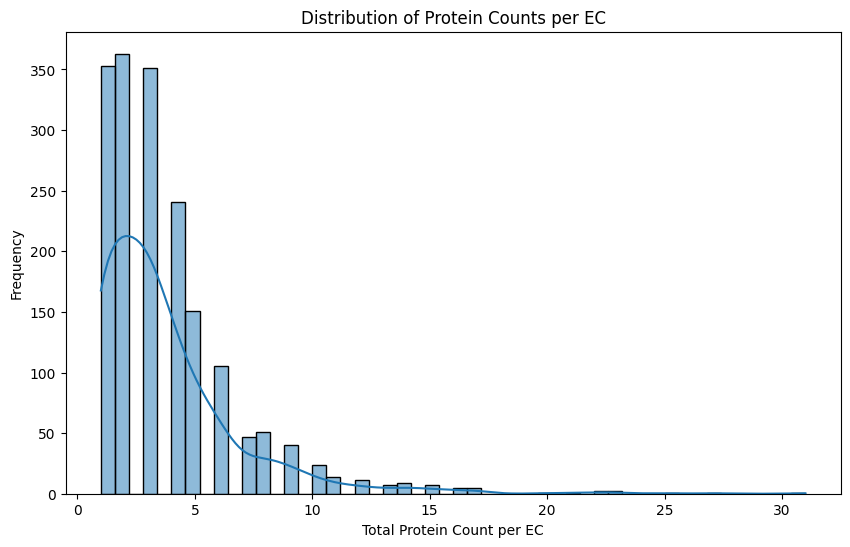

In [47]:
# Replace inf and -inf with NaN future warning
ECcontri_Uniprot = ECcontri_Uniprot.replace([np.inf, -np.inf], np.nan)

# Grouping by EC and counting unique proteins
ec_protein_counts = ECcontri_Uniprot.groupby('EC')['protein_name'].nunique().reset_index()
ec_protein_counts.columns = ['EC', 'Protein_Count']

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(ec_protein_counts['Protein_Count'].to_numpy(), bins=50, kde=True)
plt.xlabel("Total Protein Count per EC")
plt.ylabel("Frequency")
plt.title("Distribution of Protein Counts per EC")
plt.show()

It is notice that EC wont scale with protein abundance proportionally as the skewed plot shows, this is notice onthe Uniprot tables where a EC has hundred if no thousands of proteins and hundred of organisms. There might be threshold effects were a minimum protein abundance will be relevant for a microorganism metabolism and hence we could stablish those threshold in order to visualise better those protein that are really relevant to the bacteria in question.

## 8.11 Computing the Knee point for Genus of Protein Significance
Here it is computed the knee point where the activity of protein drops for each genus

In [ ]:
def knee_point_analysis(eccontri_df, abundance_col):
    # Dictionary to store knee points for each genus

    knee_points = {}
    # Calculate total number of genera to determine plot grid size
    num_genera = eccontri_df["Genus"].nunique()
    num_rows = int(np.ceil(np.sqrt(num_genera)))  # Number of rows in subplot grid
    num_cols = num_rows  # Same for columns in a square grid
    # Adjust figure size based on the number of genera
    figsize = (num_cols * 3, num_rows * 3)  # Dynamically adjust figure size

    # Plot setup
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=figsize)  # Adjust for ~85 genera
    axes = axes.flatten()
    num_subplots = num_rows * num_cols
    for i, (genus, group) in enumerate(eccontri_df.groupby("Genus")):
        group = group.sort_values(abundance_col, ascending=False).reset_index(drop=True)
        x = np.arange(len(group))  # Protein rank
        y = group[abundance_col].values  # Abundance values

        # Apply Savitzky-Golay smoothing
        y_smoothed = savgol_filter(y, window_length=7, polyorder=3)

        # Knee detection (concave function, decreasing trend)
        kneedle = KneeLocator(x, y_smoothed, curve="convex", direction="decreasing", online=True, S=1.5)

        if kneedle.knee is not None:
            knee_points[genus] = group.iloc[kneedle.knee][abundance_col]

        # Plot for visualization - blue for data
        axes[i].plot(x, y, color='blue', label=genus)
        axes[i].plot(x, y_smoothed, color='blue', alpha=0.7, label=f"{genus} (Smoothed)")
        if kneedle.knee is not None:
            axes[i].axvline(kneedle.knee, color='red', linestyle="--", label="Knee Point")
        axes[i].set_title(genus, fontsize=8)
        axes[i].set_ylabel(abundance_col)
        axes[i].tick_params(axis='both', which='major', labelsize=6)
        legend = axes[i].legend(fontsize=6, handlelength=1)

    # Remove empty subplots (after the loop)
    for i in range(num_genera, num_subplots):
        fig.delaxes(axes[i])  # Remove the extra subplot from the figure

    plt.tight_layout(pad=0.5)
    plt.show()

    # Manual overrides at the end as in your original code
    manual_overrides = {
        "Methylocystis": 4000, "Smithella": 4000, "Thermincola": 750, "Acidovorax": 10500,
        "Anoxybacillus": 3000, "Pseudorhodoferax": 7500, "Pseudoxanthomonas": 5000,
        "Phreatobacter": 3000, "Propionibacterium": 1500, "Novosphingobium": 1500,
        "Herbaspirillum": 2000, "Azospira": 10000
    }

    # Convert knee points dictionary to DataFrame for analysis
    knee_df = pd.DataFrame(knee_points.items(), columns=["Genus", "Knee_Abundance"])

    # Apply manual overrides
    for genus, override_value in manual_overrides.items():
        # If genus exists in knee_df, update it; otherwise, add it
        if genus in knee_df["Genus"].values:
            knee_df.loc[knee_df["Genus"] == genus, "Knee_Abundance"] = override_value
        else:
            knee_df = pd.concat([knee_df, pd.DataFrame({"Genus": [genus], "Knee_Abundance": [override_value]})],
                              ignore_index=True)
    # Create a dictionary mapping each genus to its threshold value
    genus_to_threshold = knee_df.set_index('Genus')['Knee_Abundance'].to_dict()

    return knee_df, genus_to_threshold

# Call the function and store the result
knee_df, genus_to_threshold = knee_point_analysis(ECcontri_Uniprot, "norm_abund_contri")

In [ ]:
import csv
from pathlib import Path

knee_path = output_base / "genus_to_threshold.csv"
with open(knee_path, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=genus_to_threshold.keys())
    writer.writeheader()
    writer.writerow(genus_to_threshold)  # Note: writerow (singular) not writerows


#!#[image.png](attachment:image.png)
The abundance on the activity of the protein on the microorganism decrease until a point that is no more relevant, this cutt point was capture. The knee points in red are consistent with protein drop in protein abundance between each genera. Some genera have a steeper drop, making the knee point clear, while others have a gradual decline, which might make the knee less biologically meaningful. Some of the knee points were manually override in order to make the selection more homogeneus.

### Identifying the Uniquenes datapoints of the Data
All 1.5 millon rows are unique?, would a EC-Genus-Site be unique or is it protein_name-Genus-Site combination?

In [ ]:
def identify_uniqueness_factors(eccontri_df):
    """
    Analyzes what column combinations create uniqueness in the original dataframe.
    """
    # Original columns
    columns = ['Sites', 'Genus', 'abund_raw', 'rel_abund_raw', 'genome_EC_count',
              'abund_contri', 'rel_abund_contri', 'norm_abund_contri', 'protein_name',
              'uniprot_id', 'EC']

    # Test various column combinations for uniqueness
    combinations = [
        ['Sites', 'Genus', 'EC'],
        ['Sites', 'Genus', 'protein_name'],
        ['Sites', 'Genus', 'EC', 'protein_name'],
        ['Sites', 'Genus', 'EC', 'abund_contri'],
        ['Sites', 'Genus', 'EC', 'abund_raw'],
        ['Sites', 'Genus', 'EC', 'protein_name', 'abund_contri'],
        # Test if all columns together make rows unique
        columns
    ]

    results = {}
    for combo in combinations:
        # Count how many duplicates exist with this combination
        duplicate_count = eccontri_df.duplicated(combo, keep=False).sum()
        unique_count = len(eccontri_df) - duplicate_count
        percent_unique = (unique_count / len(eccontri_df)) * 100

        results[tuple(combo)] = {
            'total_rows': len(eccontri_df),
            'unique_rows': unique_count,
            'duplicate_rows': duplicate_count,
            'percent_unique': percent_unique
        }

        # If we found a perfectly unique combination, print it prominently
        if duplicate_count == 0:
            print(f"PERFECT MATCH: {combo} creates unique rows")

    # Print all results
    for combo, stats in results.items():
        print(f"Columns {combo}:")
        print(f"  Unique rows: {stats['unique_rows']} ({stats['percent_unique']:.2f}%)")
        print(f"  Duplicates: {stats['duplicate_rows']}")

    return results

uniquenes= identify_uniqueness_factors(ECcontri_Uniprot)

The same EC number (enzyme function) can be performed by different proteins and the same protein can have multiple EC numbers (multiple enzymatic functions), that mens the reltion EC-Genus-Sites is unique

### Cleaning anc collecting garbage

In [ ]:
del picrust_long
del retrieved
del retrieved_unique
del unique_pairs
del df_1
del df_2
del df_3
del df_4
del ECcontri
del ECcontri_agg_site
#del ECcontri_otu

In [ ]:
import gc
gc.collect()

### Data Retrieval Completion Note
After multiple retrieval attempts, 12,656 pairs remain unmapped out of approximately 1,500,000 total rows (0.84%). Given this small percentage and the diminishing returns from further retrieval attempts, we concluded that this level of completeness is acceptable for analysis.
______________________________

# 9. Building a Dictionary from Databases

Data Normalization and Mapping
It was ensured that all protein/EC data (including EC numbers, KO numbers, and reaction IDs) were parsed and cleaned. This identifiers were mapped to their corresponding metabolic pathways using databases such as KEGG, MetaCyc, and BioCyc.

Identifying Metal-Related Proteins:
cross-reference proteins with metal-related databases (BRENDA, MetalPDB, TransportDB) where crossreferenced to flag those with direct metal-binding or metal-transport roles. Then consolidate similar metal terms (e.g., “iron”, “Fe”, “ferric”) into a unified field to improve consistency in later analyses.



Final Assembly:
I compile the data into a final dictionary/table that includes all relevant columns (Protein, EC/KO, Metabolism, Pathway, Metal Interaction, MIC Function). This allows me to search programmatically for the functional roles of proteins that are influential in corrosion studies.  


## 9.1 Setting up Paths and Parsing the Dataframes

In [ ]:
def setup_paths():
    """Set up paths for database access"""

    # Database paths
    db_paths = {
        'enzyme': db_dir / 'enzyme',
        'enzyme_class': db_dir / 'enzclass.txt',
        'enzyme_brenda' : db_dir/ 'brenda_2024.txt',
        'ko': db_dir / 'ko',
        'ko_hierarchy': db_dir / 'ko_hierarchy.txt',
        'pathway': db_dir / 'pathway',
        'module': db_dir / 'module',
        'reaction': db_dir / 'reaction',
        'compound': db_dir / 'compound',
        'metalpdb': db_dir / 'flat_db_file.xml',
        'ko_pathway': db_dir / 'ec_pathway.list'
    }

    return db_paths

#  Calling the paths
'''if __name__ == "__main__":
    paths = setup_paths()
    # Print paths to verify
    for db_name, path in paths.items():
        print(f"{db_name}: {path}")
        print(f"Exists: {path.exists()}")'''

## 9.2 Importing and Parsing Authoritative Databases

### Brenda Enzyme Parse Brenda

https://www.brenda-enzymes.org/download.php

Chang A., Jeske L., Ulbrich S., Hofmann J., Koblitz J., Schomburg I., Neumann-Schaal M., Jahn D., Schomburg D.
BRENDA, the ELIXIR core data resource in 2021: new developments and updates. (2021), Nucleic Acids Res., 49:D498-D508.
DOI: 10.1093/nar/gkaa1025 PubMed: 33211880

In [ ]:
import logging
logging.basicConfig(level=logging.INFO)

def parse_brenda_file():
    """Parse BRENDA database file for detailed enzyme information"""
    paths = setup_paths()
    enzyme_brenda_path = paths['enzyme_brenda']

    ec_detailed_info = {}
    current_ec = None
    in_enzyme_entry = False

    try:
        with open(enzyme_brenda_path, 'r') as f:
          for line in f:
              line = line.strip()

              # Skip empty lines
              if not line:
                  continue

              # Check for the end of an entry
              if line == "///":
                  current_ec = None
                  in_enzyme_entry = False
                  continue

              # Process ID line - identify enzyme entries
              if line.startswith('ID\t'):
                  current_ec = line.split('\t')[1]

                  # Skip "spontaneous" and other non-EC entries
                  if not any(c.isdigit() for c in current_ec):
                      current_ec = None
                      in_enzyme_entry = False
                      continue

                  # Initialize proper EC entry
                  ec_detailed_info[current_ec] = {
                      'metals': [],
                      'cofactors': [],
                      'reactions': [],
                      'substrates': [],
                      'inhibitors': []
                  }
                  in_enzyme_entry = True

              # Only process other lines if we're in a valid enzyme entry
              elif in_enzyme_entry and current_ec:
                  if line.startswith('ME\t'):
                      # Extract metal information
                      metal_info = line.split('\t')[1]
                      ec_detailed_info[current_ec]['metals'].append(metal_info)

                  elif line.startswith('CF\t'):
                      # Extract cofactor information
                      cofactor_info = line.split('\t')[1]
                      ec_detailed_info[current_ec]['cofactors'].append(cofactor_info)

                  elif line.startswith('RE\t'):
                      # Extract detailed reaction information
                      reaction_info = line.split('\t')[1]
                      ec_detailed_info[current_ec]['reactions'].append(reaction_info)

                  elif line.startswith('SP\t') or line.startswith('NSP\t'):
                      # Extract substrate information
                      substrate_info = line.split('\t')[1]
                      ec_detailed_info[current_ec]['substrates'].append(substrate_info)

                  elif line.startswith('IN\t'):
                      # Extract inhibitor information
                      inhibitor_info = line.split('\t')[1]
                      ec_detailed_info[current_ec]['inhibitors'].append(inhibitor_info)

        # Verify we have valid EC numbers
        ec_detailed_info = {ec: info for ec, info in ec_detailed_info.items()
                            if ec.count('.') == 3 and all(part.isdigit() for part in ec.split('.'))}

    except Exception as e:
        logging.error("Error parsing BRENDA file: %s", e)
        return {}
    return ec_detailed_info

#brenda_data = parse_brenda_file() # Only file of the dictionary that has to be call before the main function


In [ ]:
def process_brenda_data(brenda_data):
    """Process BRENDA data to extract clean metal information while keeping other data intact"""
    import sys
    #sys.path.append('/kaggle/input/corrosion-scoring') 
    sys.path.append('/home/beatriz/MIC/2_Micro/corrosion_scoring')
    from corrosion_scoring.global_terms import (
    #from global_terms import (
        metal_terms, 
        corrosion_mechanisms, 
        pathway_categories, 
        organic_categories,
        corrosion_synergies, 
        functional_categories, 
        corrosion_keyword_groups, 
        metal_mapping
    )
    import corrosion_scoring.scoring_system as score_sys
    
    processed_data = {}

    for ec_number, data in brenda_data.items():
        processed_data[ec_number] = {
            'cofactors': data.get('cofactors', []),
            'reactions': data.get('reactions', []),
            'substrates': data.get('substrates', []),
            'inhibitors': data.get('inhibitors', []),
            'raw_metals': data.get('metals', []),
            'clean_metals': [],
            'corrosion_mechanisms': [],
            'pathway_categories': {},
            'organic_processes': {},
            'corrosion_synergies': []
        }

        # Create a single text string for analysis
        all_text = ' '.join([
            ' '.join(data.get('reactions', [])),
            ' '.join(data.get('substrates', [])),
            ' '.join(data.get('cofactors', [])), 
            ' '.join(data.get('inhibitors', []))
        ]).lower()

        # Extract clean metal names first for both paths
        for entry in data.get('metals', []):
            entry_lower = entry.lower()
            for metal in metal_terms:
                metal_lower = metal.lower()
                if metal_lower in entry_lower:
                    if metal not in processed_data[ec_number]['clean_metals']:
                        processed_data[ec_number]['clean_metals'].append(metal)
        using_imported_modules = True
        if using_imported_modules:
            # Use the scoring system module for comprehensive scoring
            score_results = score_sys.calculate_overall_scores(
                all_text, 
                brenda_metals=processed_data[ec_number]['clean_metals']
            )
            
            # Update the processed data with scores from the module
            processed_data[ec_number]['corrosion_mechanisms'] = score_results['corrosion_mechanisms']
            processed_data[ec_number]['organic_processes'] = score_results['organic_processes']
            processed_data[ec_number]['corrosion_synergies'] = score_results['corrosion_synergies']
            
            # Add pathway categories - transform from scoring format to expected format
            for category_info in score_results.get('functional_categories', []):
                category = category_info.get('category')
                if category:
                    processed_data[ec_number]['pathway_categories'][category] = True
            
            # Add metal information
            processed_data[ec_number]['metals_involved'] = score_results['metals_involved']
            
            # Define corrosion-relevant metals
            corrosion_relevant_metals = ['iron', 'manganese', 'copper', 'nickel', 'cobalt', 'sulfide', 
                                        'sulfate', 'chloride', 'Al3+', 'Cr3+']
            
            processed_data[ec_number]['corrosion_metals_from_brenda'] = [
                metal for metal in processed_data[ec_number]['clean_metals']
                if metal in corrosion_relevant_metals
            ]
            
            # Calculate pathway scores
            pathways = []  # No pathways directly from BRENDA, but include for API consistency
            enzyme_names = []  # No names from BRENDA, but include for API consistency
            enzyme_class = ""  # No class from BRENDA, but include for API consistency
            
            pathway_score, pathway_category_scores = score_sys.calculate_pathway_score(
                pathways, enzyme_names, enzyme_class
            )
            
            # Calculate synergy score
            synergy_score = score_sys.check_metal_organic_synergy(
                processed_data[ec_number]['clean_metals'], 
                []  # No enzyme names in BRENDA
            )
            
            # Calculate final corrosion relevance score using the module
            corrosion_relevance_score, corrosion_relevance = score_sys.calculate_corrosion_relevance_score(
                score_results.get('overall_metal_score', 0),
                score_results.get('overall_corrosion_score', 0),
                pathway_score,
                score_results.get('overall_organic_process_score', 0),
                score_results.get('overall_keyword_score', 0),
                synergy_score,
                score_results.get('overall_functional_score', 0)
            )
            
            processed_data[ec_number]['corrosion_relevance_score'] = corrosion_relevance_score
            processed_data[ec_number]['corrosion_relevance'] = corrosion_relevance
            
        else:
            # Use the original scoring approach if module import failed
            # Check for corrosion mechanisms
            for mechanism, terms in corrosion_mechanisms.items():
                if any(term.lower() in all_text for term in terms):
                    processed_data[ec_number]['corrosion_mechanisms'].append(mechanism)

            # Check for pathway categories
            for category, terms in pathway_categories.items():
                if any(term.lower() in all_text for term in terms):
                    processed_data[ec_number]['pathway_categories'][category] = True

            # Check for organic matter processes
            for category, terms in organic_categories.items():
                if any(term.lower() in all_text for term in terms):
                    processed_data[ec_number]['organic_processes'][category] = True

            # Check for corrosion synergies
            for synergy, terms in corrosion_synergies.items():
                if any(term.lower() in all_text for term in terms):
                    processed_data[ec_number]['corrosion_synergies'].append(synergy)

            # Add corrosion relevance information
            corrosion_relevant_metals = ['iron', 'manganese', 'copper', 'nickel', 'cobalt', 'sulfide', 
                                        'sulfate', 'chloride', 'Al3+', 'Cr3+']
            
            processed_data[ec_number]['corrosion_metals_from_brenda'] = [
                metal for metal in processed_data[ec_number]['clean_metals']
                if metal in corrosion_relevant_metals
            ]

            # Calculate comprehensive corrosion relevance score
            corrosion_score = 0
            
            # Score based on metal involvement
            corrosion_score += len(processed_data[ec_number]['corrosion_metals_from_brenda']) * 1.5
            
            # Score based on corrosion mechanisms
            corrosion_score += len(processed_data[ec_number]['corrosion_mechanisms']) * 2.0
            
            # Score based on pathway categories related to corrosion
            corrosion_related_pathways = ['organic_acid_metabolism', 'metal_organic_interaction', 
                                        'biofilm_formation', 'sulfur_metabolism', 'nitrogen_metabolism',
                                        'manganese_processes', 'electron_transfer', 'iron_sulfur_redox', 
                                        'ocre_formation', 'hydrogen_metabolism']
            
            for pathway in corrosion_related_pathways:
                if pathway in processed_data[ec_number]['pathway_categories']:
                    corrosion_score += 1.0
                    
            # Score based on organic processes relevant to corrosion
            corrosion_related_processes = ['degradation', 'oxidation','reduction']
            for process in corrosion_related_processes:
                if process in processed_data[ec_number]['organic_processes']:
                    corrosion_score += 0.5
                            
            # Score based on corrosion synergies
            corrosion_score += len(processed_data[ec_number]['corrosion_synergies']) * 2.0
            
            # Set corrosion relevance category
            if corrosion_score >= 5:
                processed_data[ec_number]['corrosion_relevance'] = 'high'
            elif corrosion_score >= 2:
                processed_data[ec_number]['corrosion_relevance'] = 'medium'
            else:
                processed_data[ec_number]['corrosion_relevance'] = 'low'
            
            # Store the numerical score
            processed_data[ec_number]['corrosion_relevance_score'] = corrosion_score

    return processed_data

### Enzyme names
The database containing enzyme names and EC numbers

wget https://www.enzyme-database.org/downloads/enzyme-database.sql.gz

In [ ]:
def read_enzyme_names():
    """Read and parse enzyme file to get EC numbers and their names"""
    paths = setup_paths()
    enzyme_path = paths['enzyme']
   
    ec_to_names = {}  # More descriptive name
    with open(enzyme_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                ec_number = parts[0]
                names = parts[1].split('; ')
                ec_to_names[ec_number] = names

    for ec_number, names_list in ec_to_names.items():

        cleaned_names = [enhanced_clean_protein_name(name) if isinstance(name, str) else str(name) for name in names_list]
        ec_to_names[ec_number] = cleaned_names

    return ec_to_names


### Enzyme Class
The enzyme classification system (text-based hierarchy).

In [ ]:
def read_enzyme_class():
    paths = setup_paths()
    ec_file_path = paths['enzyme_class']

    enzyme_class = {}

    with open(ec_file_path, 'r') as f:
        for line in f:
            # Format is like "1. 1. 1.-    With NAD(+) or NADP(+) as acceptor."
            if line.strip() and any(line.startswith(str(i)) for i in range(1, 7)):
                parts = line.strip().split('  ')
                if len(parts) >= 2:
                    ec_id = parts[0].replace(' ', '')
                    desc = parts[1].strip()
                    enzyme_class[ec_id] = desc
    return enzyme_class


Ko list

wget -O ec_pathway.list "https://rest.kegg.jp/link/pathway/ec"

In [ ]:
def read_ec_pathway_mapping():
    """Read EC to pathway mapping file downloaded from KEGG"""

    paths = setup_paths()
    ko_pathway_path = paths['ko_pathway']

    ec_to_pathway = {}

    try:
        with open(ko_pathway_path , 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) == 2:
                    ec_id = parts[0].replace('ec:', '')
                    pathway_id = parts[1].replace('path:', '')

                    if ec_id not in ec_to_pathway:
                        ec_to_pathway[ec_id] = []
                    ec_to_pathway[ec_id].append(pathway_id)

        print(f"Loaded pathway mappings for {len(ec_to_pathway)} EC numbers")
    except Exception as e:
        print(f"Error reading EC-pathway mapping: {e}")
        return {}

    return ec_to_pathway



### Ko Database
 A new variable mapping  KO numbers to EC numbers from KEGG KO file.
rsync -avz rsync://rest.kegg.jp/kegg/pathway/ .

In [ ]:
def read_ko_data():
    """Read and parse KEGG KO file"""
    paths = setup_paths()
    ko_file_path = paths['ko']

    ko_info = {}
    with open(ko_file_path, 'r') as f:
        for line in f:
            if line.startswith('K'):
                parts = line.strip().split('\t')
                if len(parts) > 1:
                    ko_info[parts[0]] = {
                        'definition': parts[1],
                        'pathway': parts[2] if len(parts) > 2 else ''
                    }
    return ko_info



Ko Hierarchi Database
Hierarchy of KO numbers (helps in pathway mapping).


In [ ]:
def read_ko_hierarchy():
    paths = setup_paths()
    ko_path = paths['ko_hierarchy'] 

    hierarchy = {
        'A': {},  # Top level
        'B': {},  # ko Category
        'C': {},  # Pathway
        'D': {}   # KO/Enzyme
    }

    current = {'A': None, 'B': None, 'C': None}

    with open(ko_path, 'r') as f:
        for line in f:
            if line.startswith('A'):
                parts = line.strip().split()
                id = parts[1]
                name = ' '.join(parts[2:])
                hierarchy['A'][id] = name
                current['A'] = id

            elif line.startswith('B'):
                parts = line.strip().split()
                id = parts[1]
                name = ' '.join(parts[2:])
                hierarchy['B'][id] = {'name': name, 'parent': current['A']}
                current['B'] = id

            elif line.startswith('C'):
                parts = line.strip().split()
                id = parts[1]
                name = ' '.join(parts[2:])
                if '[PATH:' in name:
                    path_parts = name.split('[PATH:')
                    name = path_parts[0].strip()
                    path_id = path_parts[1].split(']')[0]
                else:
                    path_id = None

                hierarchy['C'][id] = {
                    'name': name,
                    'parent': current['B'],
                    'path_id': path_id
                }
                current['C'] = id

            elif line.startswith('D'):
                parts = line.strip().split()
                ko_id = parts[1]
                name = ' '.join(parts[2:])

                # Extract EC numbers if present
                ec_numbers = []
                if '[EC:' in name:
                    ec_part = name.split('[EC:')[1].split(']')[0]
                    ec_numbers = ec_part.split()
                    name = name.split('[EC:')[0].strip()

                hierarchy['D'][ko_id] = {
                    'name': name,
                    'parent': current['C'],
                    'ec_numbers': ec_numbers
                }

    return hierarchy



Reaction Data
 Reaction-level information.

!wget -c "ftp://ftp.genome.jp/pub/kegg/reaction/reaction.tar.gz"

In [ ]:
def read_reaction_data():
    paths = setup_paths()
    reaction_file_path = paths['reaction']

    reaction_info = {}

    with open(reaction_file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            parts = line.split(None, 1)  # Split on first whitespace
            if len(parts) >= 2:
                rxn_id = parts[0]
                desc_parts = parts[1].split(';')

                # First part is reaction name
                name = desc_parts[0].strip()

                # Rest might contain equation
                equation = desc_parts[1].strip() if len(desc_parts) > 1 else ""

                reaction_info[rxn_id] = {
                    'name': name,
                    'equation': equation
                }

    return reaction_info



### Pathway Database
hemical compounds database.wget https://biocyc.org/download.shtml. wget https://www.brenda-enzymes.org/download.php


In [ ]:
def read_pathway_data():
    paths = setup_paths()
    pathway_path = paths['pathway']
    
    pathway_info = {}
    with open(pathway_path, 'r') as f:
          for line in f:
              parts = line.strip().split('\t')
              if len(parts) >= 2:
                  pathway_id = parts[0]
                  pathway_name = parts[1]
                  pathway_info[pathway_id] = pathway_name
    return pathway_info



### Module Database

In [ ]:
def read_module_data():
    paths = setup_paths()
    module_path = paths['module']

    module_info = {}
    with open(module_path, 'r') as f:
      for line in f:
          parts = line.strip().split('\t')
          if len(parts) >= 2:
              module_id = parts[0]
              module_desc = parts[1]
              module_info[module_id] = module_desc
    return module_info



### Compound Database

In [ ]:
def read_compound_data():
    paths = setup_paths()
    compound_path = paths['compound']

    compound_info = {}
    with open(compound_path, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) >= 2:
                    compound_id = parts[0]
                    compound_names = parts[1].split('; ')
                    compound_info[compound_id] = {
                        'name': compound_names[0],
                        'synonyms': compound_names[1:] if len(compound_names) > 1 else []
                    }
    return compound_info


### Metal pdb
MetalPDB in 2018: a database of metal sites in biological macromolecular structures.
Putignano V., Rosato A., Banci L., Andreini C.
Nucleic Acids Res. 2018 Jan;46(D1):D459-D464. [PMID: 29077942]


In [ ]:
def parse_metalpdb_xml():
    """Parse MetalPDB XML file to extract metal-binding information"""
    paths = setup_paths()
    metalpdb_path = paths['metalpdb']

    metal_binding_data = {}

    try:
        # Use a more tolerant parser
        parser = etree.XMLParser(recover=True)
        tree = etree.parse(metalpdb_path, parser)
        root = tree.getroot()

        # Process each site
        for site in root.findall('.//site'):
            # Extract site information
            site_name = site.findtext('site_name')
            pdb_code = site.findtext('pdb_code')
            site_nuclearity = site.findtext('site_nuclearity')

            # Process each metal in the site
            for metal in site.findall('.//metal'):
                metal_symbol = metal.findtext('periodic_symbol')
                metal_name = metal.findtext('periodic_name')
                coordination_number = metal.findtext('coordination_number')
                geometry = metal.findtext('geometry')

                # Process ligands
                ligands = []
                for ligand in metal.findall('.//ligand'):
                    residue_name = ligand.findtext('residue_name')
                    residue_num = ligand.findtext('residue_pdb_number')
                    chain = ligand.findtext('chain_letter')
                    binding_type = ligand.findtext('endo_exo')

                    # Process donor atoms
                    donors = []
                    for donor in ligand.findall('.//donor'):
                        distance = donor.findtext('distance')
                        atom_name = donor.findtext('atom_pdb_name')
                        atom_symbol = donor.findtext('atom_symbol')
                        interaction_type = donor.findtext('interaction_type')

                        donors.append({
                            'distance': distance,
                            'atom_name': atom_name,
                            'atom_symbol': atom_symbol,
                            'interaction_type': interaction_type
                        })

                    ligands.append({
                        'residue_name': residue_name,
                        'residue_number': residue_num,
                        'chain': chain,
                        'binding_type': binding_type,
                        'donors': donors
                    })

                # Get the protein/molecule information
                site_chains = []
                for chain in site.findall('.//site_chain'):
                    molecule_name = chain.findtext('molecule_name')
                    molecule_type = chain.findtext('molecule_type')
                    chain_letter = chain.findtext('letter')

                    site_chains.append({
                        'molecule_name': molecule_name,
                        'molecule_type': molecule_type,
                        'chain_letter': chain_letter
                    })

                # Create a unique key for this metal site
                metal_site_key = f"{pdb_code}_{site_name}_{metal_symbol}"

                # Store the data
                metal_binding_data[metal_site_key] = {
                    'pdb_code': pdb_code,
                    'site_name': site_name,
                    'site_nuclearity': site_nuclearity,
                    'metal': {
                        'symbol': metal_symbol,
                        'name': metal_name,
                        'coordination_number': coordination_number,
                        'geometry': geometry
                    },
                    'ligands': ligands,
                    'site_chains': site_chains
                }

    except Exception as e:
        logging.error("Error parsing MetalPDB XML: %s", e)
        return {}

    return metal_binding_data


### Extracting metal binding patterns from metal binding data

In [ ]:
def extract_metal_coordination_patterns(metal_binding_data):
    """Extract metal coordination patterns from MetalPDB data"""

    # Track metal coordination patterns
    metal_coordination = {}
    metal_residue_binding = {}
    # Add a counter to track processing
    processed_sites = 0

    for site_key, site_data in metal_binding_data.items():
        try:
            metal_symbol = site_data.get('metal', {}).get('symbol')
            if not metal_symbol:
                continue
    
            # Track coordination environments
            coord_num = site_data.get('metal', {}).get('coordination_number')
            geometry = site_data.get('metal', {}).get('geometry')

            if coord_num and geometry:
                coord_key = f"{metal_symbol}_{coord_num}_{geometry}"
                metal_coordination[coord_key] = metal_coordination.get(coord_key, 0) + 1
        
              # Track metal-residue binding
            if metal_symbol not in metal_residue_binding:
                metal_residue_binding[metal_symbol] = {}
                
            for ligand in site_data.get('ligands', []):
                residue = ligand.get('residue_name')
                if residue:
                    metal_residue_binding[metal_symbol][residue] = metal_residue_binding[metal_symbol].get(residue, 0) + 1
            
            processed_sites += 1
        except Exception as e:
            print(f"Error processing site {site_key}: {e}")
    
    print(f"Processed {processed_sites} sites out of {len(metal_binding_data)}")
    
    if not metal_coordination:
        print("Warning: No coordination patterns were extracted")
    if not metal_residue_binding:
        print("Warning: No residue binding patterns were extracted")
        
    return {
        'coordination': metal_coordination,
        'residue_binding': metal_residue_binding
    }


### EC to reaction Mapping

In [ ]:
def create_ec_to_reaction_mapping():  
    ec_to_names = read_enzyme_names()
    reaction_info = read_reaction_data()
    
    # Build keyword-to-ECs reverse index
    keyword_to_ecs = {}
    for ec, names in ec_to_names.items():
        words = set()
        for name in names:
            for word in str(name).lower().split():
                if len(word) > 4:
                    words.add(word)
        for keyword in words:
            if keyword not in keyword_to_ecs:
                keyword_to_ecs[keyword] = set()
            keyword_to_ecs[keyword].add(ec)
    
    # Preprocess reaction names
    rxn_name_lower = {rxn_id: info['name'].lower() for rxn_id, info in reaction_info.items()}
    
    # Match reactions to ECs
    ec_to_reaction = {}
    for rxn_id, rxn_name in rxn_name_lower.items():
        matched_ecs = set()
        for keyword in keyword_to_ecs:
            if keyword in rxn_name: 
                matched_ecs.update(keyword_to_ecs[keyword])
        for ec in matched_ecs:
            if ec not in ec_to_reaction:
                ec_to_reaction[ec] = set()
            ec_to_reaction[ec].add(rxn_id)
    
    return {ec: list(rxns) for ec, rxns in ec_to_reaction.items()} 

### Consolidation Metals from Different Origins Helper Function

In [ ]:
# Standard mapping: lower-case keys for matching, with standard symbols as values
import corrosion_scoring.global_terms as gt
def consolidate_metal_terms(brenda_metals, text_detected_metals):
    """
    Consolidates metal names from BRENDA and text mining into standardized symbols.

    Parameters:
        brenda_metals (list of str): Metals obtained from BRENDA data.
        text_detected_metals (list of str): Metals detected from text mining.

    Returns:
        list: Consolidated list of unique, standardized metal symbols.
    """
    # Import metal_mapping from global terms module # for kaggle
    from global_terms_py import metal_mapping
    
    consolidated = set()
    all_metals = (brenda_metals or []) + (text_detected_metals or [])
    
    for metal in all_metals:
        metal_norm = metal.strip().lower()
        # Check if the normalized term matches any key in the standard mapping
        for key, symbol in metal_mapping.items():
            if key in metal_norm:
                consolidated.add(symbol)
                break
        else:
            # If no mapping is found, add the original
            consolidated.add(metal.strip())
    return list(consolidated)

## 9.3. Main Function of Creating a Consolidated DataBase

Brenda Enzyme Database. (n.d.). In BRENDA. Retrieved from https://www.brenda-enzymes.org (APA citation format)
MetalPDB: a database of metal sites in biological macromolecular structures. (n.d.). Retrieved from http://metalpdb.cerm.unifi.it (APA citation format)


In [ ]:
def create_metabolism_database():
    """
    Build a list of dictionaries, each representing a single EC record.
    
    This function builds a comprehensive database of enzyme records with detailed information
    about their potential relevance to corrosion processes. It incorporates data from various
    sources, including BRENDA, MetalPDB, KEGG, and others.
    
    The function can use either:
    1. The external scoring_system_py module (preferred for consistency and maintainability)
    2. The original inline scoring logic (as a fallback if the module import fails)
    
    Args:   sample_size (int, optional): If specified, random sample of EC numbers to process
        
    Returns:  list: List of dictionaries, each containing information about an enzyme
    """
    global brenda_data
    import sys
    #sys.path.append('/kaggle/input/corrosion-scoring') # for kaggle
    sys.path.append('/home/beatriz/MIC/2_Micro/corrosion_scoring')
    from corrosion_scoring.global_terms import (
    #from global_terms import ( # for kaggle
        metal_terms, 
        corrosion_mechanisms, 
        pathway_categories, 
        organic_categories,
        corrosion_synergies, 
        functional_categories, 
        corrosion_keyword_groups, 
        metal_mapping
    )
    import corrosion_scoring.scoring_system as score_sys
    
    try:
        # Read all necessary files
        print("Loading data sources...")
        ec_to_names = read_enzyme_names() or {}
        enzyme_class = read_enzyme_class() or {}
        reaction_equation = read_reaction_data() or {}
        ko_ec = read_ko_data() or {}
        ko_hierarchy = read_ko_hierarchy() or {}
        pathway_data = read_pathway_data() or {}
        module_info = read_module_data() or {}
        compound_info = read_compound_data() or {}
        brenda_en = process_brenda_data(brenda_data) or {}
        metal_binding_data = parse_metalpdb_xml() or {}
        metal_patterns = extract_metal_coordination_patterns(metal_binding_data)
        ec_pathway_mapping = read_ec_pathway_mapping() or {}

        print(f"Loaded: {len(ec_to_names)} enzymes, {len(pathway_data)} pathways, {len(brenda_en)} BRENDA entries")

        # Get EC to reaction mapping 
        print("Creating EC to reaction mapping...")
        ec_to_rxn = create_ec_to_reaction_mapping()
        
        # extract protein information
        print("Preparing protein database...")
        protein_database = []
        # From BRENDA
        if brenda_en:
            for ec_number, data in brenda_en.items():
                # Use EC number to find enzyme names from ec_to_names
                if ec_number in ec_to_names:
                    protein_name = ec_to_names[ec_number][0] if ec_to_names[ec_number] else None
                    if protein_name:
                        protein_database.append({
                            'source': 'BRENDA',
                            'ec_number': ec_number,
                            'protein_name': protein_name,
                            'brenda_data': data
                        })
        # From MetalPDB
        if metal_binding_data:
            for site_key, site_data in metal_binding_data.items():
                for chain in site_data.get('site_chains', []):
                    if 'molecule_name' in chain and chain['molecule_type'] == 'protein':
                        protein_database.append({
                            'source': 'MetalPDB',
                            'pdb_code': site_data.get('pdb_code'),
                            'protein_name': chain['molecule_name'],
                            'metal_binding': site_data.get('metal', {})
                        })

    except Exception as e:
        print(f"Error loading data sources: {e}")
    
        return []
    # Track statistics for validation
    stats = {
        'total_enzymes': 0,
        'with_brenda_data': 0,
        'with_reactions': 0,
        'with_pathways': 0,
        'with_ko': 0,
        'with_metal_involvement': 0,
        'with_corrosion_mechanisms': 0
    }
    
    start_time_record = time.time()
    # Prepare a list to store all records
    ec_records = []
    stats['total_enzymes'] = len(ec_to_names)

    print("Pre-computing enzyme class lookups...")
    ec_class_lookup = {}
    for ec_number in ec_to_names.keys():
        try:
            ec_prefix = '.'.join(ec_number.split('.')[:2])
            # Try exact match first
            if ec_prefix in enzyme_class:
                ec_class_lookup[ec_number] = enzyme_class[ec_prefix].strip()
            # Then try pattern match
            else:
                pattern_key = f"{ec_prefix}.-.-"
                if pattern_key in enzyme_class:
                    ec_class_lookup[ec_number] = enzyme_class[pattern_key]
        except Exception:
            pass  # Skip if error occurs
    
    # Pre-compute KO lookups - do this once
    print("Pre-computing KO lookups...")
    ko_lookup = {}
    for ko, data in ko_ec.items():
        if isinstance(data, dict) and 'definition' in data:
            for ec_number in ec_to_names.keys():
                if f"[EC:{ec_number}]" in data['definition']:
                    if ec_number not in ko_lookup:
                        ko_lookup[ec_number] = []
                    ko_lookup[ec_number].append(ko)
    
    # Populate from ec_to_names for basic enzyme names
    print("Building enzyme records...")
    for ec_number, names in ec_to_names.items():
        # Data validation for EC number format
        if not (ec_number.count('.') == 3 and all(part.isdigit() for part in ec_number.split('.'))):
            print(f"Warning: Invalid EC number format: {ec_number}")
            continue

        record ={
            'ec_number': ec_number,
            'enzyme_names': [str(name).strip() for name in (names if isinstance(names, list) else [names]) if name], # Ensure names are strings and stripped
            'protein_name': str(names[0]).strip() if isinstance(names, list) and names else str(names).strip() if names else None, # Strip protein name
            'enzyme_class': ec_class_lookup.get(ec_number),
            'pathways': [],
            'hierarchy': [],
            'ko': ko_lookup.get(ec_number, []),
            'reactions': [],
            'compounds': [],
            'modules': [],
            'metals_from_brenda': [],
            'corrosion_metals_from_brenda': []
        }
        # Add pathways from EC-pathway mapping
        if ec_number in ec_pathway_mapping:
            for pathway_id in ec_pathway_mapping[ec_number]:
                # Standardize to map prefix
                std_id = pathway_id
                if pathway_id.startswith('ec'):
                    std_id = 'map' + pathway_id[2:]

                # Look up the pathway name
                if std_id in pathway_data:
                    pathway_name = pathway_data[std_id]
                    if pathway_name not in record['pathways']:
                        record['pathways'].append(pathway_name)

        # Add pathways from KO data
        if ec_number in ko_ec and isinstance(ko_ec[ec_number], list):
            for path in ko_ec[ec_number]:
                if path not in record['pathways']:
                    record['pathways'].append(path)
        elif ec_number in ko_ec and isinstance(ko_ec[ec_number], dict) and 'pathway' in ko_ec[ec_number]:
            path = ko_ec[ec_number]['pathway']
            if path not in record['pathways']:
                record['pathways'].append(path)
        # Add KO IDs
        ko_ids = []
        for ko, data in ko_ec.items():
            if isinstance(data, dict) and 'definition' in data and f"[EC:{ec_number}]" in data['definition']:
                ko_ids.append(ko)
        record['ko'] = ko_ids

        if ko_ids:
            stats['with_ko'] += 1

        # Build reaction list
        rxns = ec_to_rxn.get(ec_number, [])
        for rxn_id in rxns:
            if rxn_id in reaction_equation:
                eqn = reaction_equation.get(rxn_id, {}).get('equation', 'Unknown')
                record['reactions'].append({'id': rxn_id, 'equation': eqn})

                # Add compounds involved in this reaction
                for compound_id in reaction_equation.get(rxn_id, {}).get('compounds', []):
                    if compound_id in compound_info:
                        compound_data = compound_info[compound_id]
                        if compound_data not in record['compounds']:
                            record['compounds'].append(compound_data)

        if rxns:
            stats['with_reactions'] += 1

        # Add module information
        for module_id, module_desc in module_info.items():
            if f"[EC:{ec_number}]" in module_desc:
                record['modules'].append({'id': module_id, 'description': module_desc})

        # Reconcile metals from BRENDA with text mining
        record['metals_from_brenda'] = []
        record['corrosion_metals_from_brenda'] = []

        # Add BRENDA metal information
        if brenda_en and ec_number in brenda_en:
            record['metals_from_brenda'] = brenda_en[ec_number].get('clean_metals', [])
            record['corrosion_metals_from_brenda'] = brenda_en[ec_number].get('corrosion_metals_from_brenda', [])
            stats['with_brenda_data'] += 1

        # Check if EC number is valid
        ec_number = record['ec_number']
        has_valid_ec = ec_number.count('.') == 3 and all(part.isdigit() for part in ec_number.split('.'))
        # Initialize protein_name to None as a default
        protein_name = None
        # If no valid EC number or it failed any checks
        if not has_valid_ec and 'protein_name' in record and record['protein_name']:
            protein_name = record['protein_name'].lower()    

        ec_records.append(record)
        
    elapsed_time_record = time.time() - start_time_record
    print(f"Processing took {elapsed_time_record:.2f} seconds")

     # Process records in batches to avoid memory issues
    print("Processing protein names and calculating scores...")
    batch_size = 1000  # Adjust based on available memory
    for i in range(0, len(ec_records), batch_size):
        batch = ec_records[i:i+batch_size]
        
        # Process protein names in batch
        for rec in batch:
            # Process protein name matches
            try:
                if rec.get('protein_name') is None and rec.get('enzyme_names'):
                    rec['protein_name'] = rec['enzyme_names'][0]
                # Use indexing/hashing to speed up matching    
                protein_name = rec.get('protein_name', '')
                if not protein_name or len(protein_name) <= 2:
                    continue  
                
                protein_name_lower = protein_name.lower()
                for db_rec in protein_database:
                    db_protein_name = db_rec.get('protein_name', '')
                    if not db_protein_name:
                        continue
                        
                    db_protein_lower = db_protein_name.lower()
                    if (db_protein_lower == protein_name_lower or 
                        db_protein_lower in protein_name_lower or
                        protein_name_lower in db_protein_lower):
                            # Found a matching protein, merge data
                            if 'brenda_data' in db_rec:
                                # Process BRENDA data
                                brenda_data = db_rec['brenda_data']
                                if 'metals' in brenda_data and 'metals' not in rec:
                                    rec['metals'] = brenda_data['metals']
                                    
                            if 'metal_binding' in db_rec:
                                # Process MetalPDB data
                                if 'metal_binding_info' not in rec:
                                    rec['metal_binding_info'] = {}
                                    metal = db_rec['metal_binding'].get('symbol')
                                    if metal:
                                        rec['metal_binding_info'][metal] = db_rec['metal_binding']
            except Exception as e:
                print(f"Error processing protein name {rec.get('protein_name')}: {e}")

        # Calculate scores for this batch
        for rec in batch:
            # Build text for scoring once
            enzyme_names = rec.get('enzyme_names', []) or []
            class_text = rec.get('enzyme_class', '') or ''
            pathways = rec.get('pathways', []) or []
            names_text = ' '.join(enzyme_names) + ' ' + class_text + ' ' + ' '.join(pathways)
            
            # Add reaction text for more context
            reaction_text = ""
            for r in rec.get('reactions', []):
                if isinstance(r, dict) and 'equation' in r:
                    reaction_text += " " + r['equation']

            # Combined text for all scoring
            all_text = f"{names_text} {class_text} {' '.join(pathways)} {reaction_text}".lower()
            using_imported_modules = True
            # Score metals, mechanisms, etc. all at once
            try:
                if using_imported_modules:
                    # Use the scoring system module if available
                    score_results = score_sys.calculate_overall_scores(
                        all_text, 
                        brenda_metals=rec.get('metals_from_brenda', [])
                    )
                    
                    # Merge the score results into the record
                    rec.update(score_results)
                    
                    # Consolidate metals using the module function
                    rec['metals_consolidated'] = score_sys.consolidate_metal_terms(
                        rec.get('metals_from_brenda', []),
                        rec.get('metals_involved', [])
                    )
                else:
                    # Fall back to original inline scoring logic
                    # Score metals
                    metal_score, metal_matches = score_keyword_matches(all_text, metal_terms)
                    for metal in rec.get('metals_from_brenda', []):
                        if metal not in metal_matches:
                            metal_matches[metal] = 1.0
                    
                    rec['metals_involved'] = list(metal_matches.keys())
                    rec['metal_scores'] = metal_matches
                    rec['overall_metal_score'] = float(metal_score)
                    
                    # Score corrosion mechanisms  
                    corrosion_score, corrosion_matches = score_keyword_matches(all_text, corrosion_mechanisms)
                    rec['corrosion_mechanisms'] = list(corrosion_matches.keys())
                    rec['corrosion_mechanism_scores'] = corrosion_matches
                    rec['overall_corrosion_score'] = float(corrosion_score)
                    
                    # Score synergies
                    synergy_score, synergy_matches = score_keyword_matches(all_text, corrosion_synergies)
                    rec['corrosion_synergies'] = list(synergy_matches.keys())
                    rec['corrosion_synergy_scores'] = synergy_matches
                    rec['overall_synergy_score'] = float(synergy_score)
                    
                    # Score functional categories
                    functional_terms = {cat: details['terms'] for cat, details in functional_categories.items()}
                    func_score, func_matches = score_keyword_matches(all_text, functional_terms)
                    weighted_func_matches = {}
                    for cat, match_score in func_matches.items():
                        original_weight = functional_categories[cat]['score']
                        weighted_func_matches[cat] = match_score * original_weight

                    rec['functional_categories'] = [{"category": cat, "score": score} 
                                                 for cat, score in weighted_func_matches.items()]
                    rec['overall_functional_score'] = float(sum(weighted_func_matches.values()))
                    
                    # Score organic processes
                    organic_score, organic_matches = score_keyword_matches(all_text, organic_categories)
                    rec['organic_processes'] = list(organic_matches.keys())
                    rec['organic_process_scores'] = organic_matches
                    rec['overall_organic_process_score'] = float(organic_score)
                    
                    # Score keyword groups
                    keyword_score, keyword_matches = score_keyword_matches(all_text, corrosion_keyword_groups)
                    rec['corrosion_keyword_groups'] = list(keyword_matches.keys())
                    rec['corrosion_keyword_scores'] = keyword_matches
                    rec['overall_keyword_score'] = float(keyword_score)
                    
                    # Consolidate metals
                    rec['metals_consolidated'] = consolidate_metal_terms(
                        rec.get('metals_from_brenda', []),
                        rec.get('metals_involved', [])
                    )
                
                # Update statistics (same for both paths)
                if rec['metals_consolidated']:
                    stats['with_metal_involvement'] += 1
            
                if rec['corrosion_mechanisms']:
                    stats['with_corrosion_mechanisms'] += 1
                    
            except Exception as e:
                print(f"Error scoring data for {rec.get('ec_number')}: {e}")
                
    # Process metal binding in a separate pass
    print("Processing metal binding information...")
    try:
        # Add metal binding information to records
        for rec in ec_records:
            rec['metal_binding_info'] = {}

            # Check metals from BRENDA or detected in text
            all_metals = set(rec.get('metals_consolidated', []))

            for metal in all_metals:
                # Try to map to standard symbol
                for metal_name, symbol in metal_mapping.items():
                    if metal_name in metal.lower() or symbol.lower() in metal.lower():
                        # Check if we have binding data for this metal
                        if symbol in metal_patterns.get('residue_binding', {}):
                            # Get top binding residues
                            residue_counts = metal_patterns['residue_binding'][symbol]
                            top_residues = sorted(residue_counts.items(), key=lambda x: x[1], reverse=True)[:5]

                            rec['metal_binding_info'][symbol] = {'common_residues': [res for res, count in top_residues],  'binding_count': sum(residue_counts.values())}
                                                                  
                # Check for common coordination geometries
                geometries = [key.split('_')[2:] for key, count in metal_patterns['coordination'].items() if key.startswith(f"{symbol}_")]
                if geometries:
                    rec['metal_binding_info'][symbol]['common_geometries'] = geometries[:3]

    except Exception as e:
        print(f"Error processing metal binding data: {e}")

    # Process KO hierarchy information
    print("Processing KO hierarchy...")
    if 'D' in ko_hierarchy:
        for ko, info in ko_hierarchy.get('D', {}).items():
            for ec in info.get('ec_numbers', []):
                # find matching records
                for rec in ec_records:
                    if rec['ec_number'] == ec:
                        try:
                            parent_c = info.get('parent')
                            if parent_c and 'C' in ko_hierarchy and parent_c in ko_hierarchy['C']:
                                path_info = ko_hierarchy['C'][parent_c]
                                parent_b = path_info.get('parent')
                                if parent_b and 'B' in ko_hierarchy and parent_b in ko_hierarchy['B']:
                                    hi_category = ko_hierarchy['B'][parent_b].get('name', '')
                                    pathway = path_info.get('name', '')

                                    # Use sets to efficiently track unique values
                                    if pathway and pathway not in rec['pathways']:
                                        rec['pathways'].append(pathway)

                                    hierarchy = f"{hi_category} > {pathway}"
                                    if hierarchy and hierarchy not in rec['hierarchy']:
                                        rec['hierarchy'].append(hierarchy)
                        except Exception as e:
                            print(f"Error processing KO hierarchy for {rec.get('ec_number')}: {e}")
    
    # Calculate pathway statistics
    print("Calculating pathway statistics...")
    for rec in ec_records:
        if rec['pathways']:
            stats['with_pathways'] += 1
    
    # Calculate final corrosion relevance scores using the scoring module
    print("Calculating corrosion relevance scores...")
    for rec in ec_records:
        try:
            enzyme_names = rec.get('enzyme_names', []) or []
            enzyme_class_text = rec.get('enzyme_class', '') or ''
            pathways = rec.get('pathways', []) or []
            
            if using_imported_modules:
                # Calculate pathway scores using the module function
                pathway_score, pathway_category_scores = score_sys.calculate_pathway_score(
                    pathways, enzyme_names, enzyme_class_text
                )
                
                # Check for metal-organic synergy
                synergy_score = score_sys.check_metal_organic_synergy(
                    rec.get('metals_consolidated', []), 
                    enzyme_names
                )
                rec['metal_organic_synergy_score'] = synergy_score
                
                # Calculate final corrosion relevance score using the module function
                corrosion_relevance_score, corrosion_relevance = score_sys.calculate_corrosion_relevance_score(
                    rec.get('overall_metal_score', 0),
                    rec.get('overall_corrosion_score', 0),
                    pathway_score,
                    rec.get('overall_organic_process_score', 0),
                    rec.get('overall_keyword_score', 0),
                    synergy_score,
                    rec.get('overall_functional_score', 0)
                )
            else:
                # Replicate original pathway scoring logic but using global terms directly
                pathway_score = 0
                pathway_category_scores = {}
                
                # Add pathway categories from BRENDA data or calculate them
                ec_number = rec.get('ec_number')
                if ec_number in brenda_en and 'pathway_categories' in brenda_en[ec_number]:
                    # Get pathway categories from BRENDA
                    rec['pathway_categories'] = brenda_en[ec_number]['pathway_categories']
                    # Score each pathway category
                    for category in rec['pathway_categories']:
                        pathway_category_scores[category] = 1.0  # Base score of 1.0 for each category
                        pathway_score += 1.0
                else:
                    # If not available from BRENDA, check against pathway terms
                    rec['pathway_categories'] = {}
                    all_text = ' '.join(rec.get('enzyme_names', '') or []) + ' ' + (rec.get('enzyme_class', '') or '') + ' ' + ' '.join(rec.get('pathways', []))
                    all_text = all_text.lower()
            
                    for category, terms in pathway_categories.items():
                        if any(term.lower() in all_text for term in terms):
                            rec['pathway_categories'][category] = True
                            pathway_category_scores[category] = 1.0
                            pathway_score += 1.0

                # Define corrosion-relevant categories to check
                corrosion_relevant_categories = [
                    'iron_sulfur_redox', 'ocre', 'acid_production', 
                    'electron_transfer', 'biofilm', 'sulfide'
                ]
                
                # Extract terms from relevant categories in corrosion_keyword_groups
                corrosion_pathway_terms = []
                for category in corrosion_relevant_categories:
                    if category in corrosion_keyword_groups:
                        corrosion_pathway_terms.extend(corrosion_keyword_groups[category])
                
                # Check pathway names against these terms
                for pathway in rec.get('pathways', []):
                    pathway_lower = pathway.lower()
                    if any(term.lower() in pathway_lower for term in corrosion_pathway_terms):
                        pathway_score += 1
                
                # Use the organic_acid_metabolism category directly for organic acid terms
                organic_acid_terms = pathway_categories.get('organic_acid_metabolism', [])
                
                name_text = ' '.join(rec.get('enzyme_names', []))
                if any(term.lower() in name_text.lower() for term in organic_acid_terms):
                    pathway_score += 0.5  # Smaller weight for organic terms alone

                # Add synergy bonus for metal-organic combination using terms from global collections
                synergy_score = 0
                relevant_metals = ['Fe', 'Mn', 'Cu']  # Standard symbols from metal_mapping
                
                metal_found = False
                for metal in rec.get('metals_consolidated', []):
                    # Check if the metal is one of our relevant metals
                    metal_lower = metal.lower()
                    for key, symbol in metal_mapping.items():
                        if (key == metal_lower or symbol.lower() == metal_lower) and symbol in relevant_metals:
                            metal_found = True
                            break
                    if metal_found:
                        break
                
                if metal_found and any(term.lower() in name_text.lower() for term in organic_acid_terms):
                    synergy_score = 1.0  # Higher weight for metal-organic combination
                
                rec['metal_organic_synergy_score'] = synergy_score
  
                # Calculate final score using original logic but with scoring weights from the module
                # if available, otherwise use the original hardcoded weights
                metal_score = rec.get('overall_metal_score', 0) * 1.5  # METAL_SCORE_WEIGHT
                mech_score = rec.get('overall_corrosion_score', 0) * 2.0  # CORROSION_MECHANISM_WEIGHT
                process_score = rec.get('overall_organic_process_score', 0) * 1.0  # ORGANIC_PROCESS_WEIGHT
                keyword_score = rec.get('overall_keyword_score', 0) * 0.5  # KEYWORD_SCORE_WEIGHT
                func_score = rec.get('overall_functional_score', 0) * 0.7  # FUNCTIONAL_SCORE_WEIGHT
                weighted_synergy = synergy_score * 0.6  # SYNERGY_SCORE_WEIGHT
                
                corrosion_relevance_score = float(
                    metal_score + 
                    mech_score + 
                    pathway_score + 
                    process_score + 
                    keyword_score + 
                    weighted_synergy + 
                    func_score
                )
                
                # Categorize using original thresholds
                if corrosion_relevance_score >= 5:  # HIGH_RELEVANCE_THRESHOLD
                    corrosion_relevance = 'high'
                elif corrosion_relevance_score >= 2:  # MEDIUM_RELEVANCE_THRESHOLD
                    corrosion_relevance = 'medium'
                else:
                    corrosion_relevance = 'low'
            
            # Add pathway scores to record (same for both paths)
            rec['pathway_category_scores'] = pathway_category_scores
            rec['overall_pathway_category_score'] = sum(pathway_category_scores.values())
            rec['pathway_score'] = float(pathway_score)
            
            # Store final scores in record (same for both paths)
            rec['corrosion_relevance_score'] = corrosion_relevance_score
            rec['corrosion_relevance'] = corrosion_relevance
            
        except Exception as e:
            print(f"Error calculating corrosion score for {rec.get('ec_number')}: {e}")
            rec['corrosion_relevance_score'] = 0
            rec['corrosion_relevance'] = 'unknown'        

    # Filter records without content
    print("Filtering records...")
    filtered_ec_records = []
    for rec in ec_records:
        protein_name = (rec.get('protein_name') or "").lower()
        enzyme_names = rec.get('enzyme_names', [])
        enzyme_names = [] if enzyme_names is None else enzyme_names
        ec_number = rec.get('ec_number', "")

        # Condition 1: At least one valid identifier must be present
        has_valid_protein = "uncharacterized" not in protein_name and len(protein_name) > 2
        has_valid_enzyme = any(len(name) > 2 for name in enzyme_names)
        has_valid_ec = ec_number.count('.') == 3 and all(part.isdigit() for part in ec_number.split('.'))
      
        # Condition 2: Check for valuable data that should be preserved
        has_mechanisms = len(rec.get('corrosion_mechanisms', [])) > 0
        has_pathways = len(rec.get('pathways', [])) > 0
        has_metals_consolidated = len(rec.get('metals_consolidated', [])) > 0

        # Include record if it meets either condition
        if (has_valid_protein or has_valid_enzyme or has_valid_ec) or (has_mechanisms or has_pathways or has_metals_consolidated):
            filtered_ec_records.append(rec)

    # Replace original list with filtered version
    ec_records = filtered_ec_records

    # Print summary statistics
    print("\nMetabolism Database Summary:")
    print(f"Total enzyme records: {stats['total_enzymes']}")
    print(f"Records with BRENDA data: {stats['with_brenda_data']} ({stats['with_brenda_data']/stats['total_enzymes']*100:.1f}%)")
    print(f"Records with reactions: {stats['with_reactions']} ({stats['with_reactions']/stats['total_enzymes']*100:.1f}%)")
    print(f"Records with pathways: {stats['with_pathways']} ({stats['with_pathways']/stats['total_enzymes']*100:.1f}%)")
    print(f"Records with KO terms: {stats['with_ko']} ({stats['with_ko']/stats['total_enzymes']*100:.1f}%)")
    print(f"Records with corrosion mechanisms: {stats['with_corrosion_mechanisms']} ({stats['with_corrosion_mechanisms']/stats['total_enzymes']*100:.1f}%)")

    # Validate the data - check for missing essential fields
    validation_issues = []
    for i, rec in enumerate(ec_records):
        if not rec.get('ec_number'):
            validation_issues.append(f"Record {i} missing EC number")
        if not rec.get('enzyme_names'):
            validation_issues.append(f"EC {rec.get('ec_number')} missing enzyme names")

    if validation_issues:
        print("\nValidation Issues:")
        for issue in validation_issues[:10]:  # Show first 10 issues
            print(f"- {issue}")
        if len(validation_issues) > 10:
            print(f"...and {len(validation_issues) - 10} more issues")
    else:
        print("\nValidation: All records have essential fields.")

    return ec_records

In [ ]:
# Takes 30 - 240 min
#ec_records = create_metabolism_database(sample_size=1)


Metabolism Database Summary:    
779.2s	114	Total enzyme records: 8235   
779.2s	115	Records with BRENDA data: 6710 (81.5%)   
779.2s	116	Records with reactions: 5514 (67.0%)    
779.2s	117	Records with pathways: 5964 (72.4%)   
779.2s	118	Records with KO terms: 4873 (59.2%)   
779.2s	119	Records with corrosion mechanisms: 5818 (70.6%)   

In [ ]:
'''# Save to JSON with timing
json_path = output_large / "ec_records.json"
print(f"Starting JSON save to {json_path}...")
start_time = time.time()

try:
    with open(json_path, 'w') as f:
        json.dump(ec_records, f)

    end_time = time.time()
    elapsed = end_time - start_time
    size_mb = os.path.getsize(json_path) / 1024 / 1024

    print(f"Successfully saved to {json_path} in {elapsed:.2f} seconds ({size_mb:.2f} MB)")
except Exception as e:
    print(f"Error saving to JSON: {e}")'''

Load dictionary done using ec_record_kaggle.py due to capacity of the local machine and this notebook

In [ ]:
'''#json_path = Path("/kaggle/input/ec-records/ec_records.json")
json_path = output_large /"ec_records.json"
print(f"Starting JSON load from {json_path}...")
start_time = time.time()

with open(json_path, 'r') as f:
    ec_records = json.load(f)

end_time = time.time()
elapsed = end_time - start_time
print(f"Loaded {len(ec_records)} records from JSON in {elapsed:.2f} seconds")'''

In [ ]:
#ec_meta = pd.DataFrame(ec_records)
#ec_meta['pathways']

## 9.4 Flattening Database List of Dictionaries

In [ ]:
def targeted_flatten_ec_records(ec_records):
    """
    Specifically targeted flattening to handle problematic fields in EC records.

    Parameters:
        ec_records : list of dictionaries containing EC record data

    Returns:
        list of dictionaries with properly flattened structure
    """
    fixed_records = []

    for record in ec_records:
        fixed_record = record.copy()  # Start with a copy of the original record

        # Fix pathways - convert from list to semicolon-separated string
        if 'pathways' in record and isinstance(record['pathways'], list):
            fixed_record['pathways'] = '; '.join(str(p) for p in record['pathways'] if p)

        # Fix hierarchy - convert from list to semicolon-separated string
        if 'hierarchy' in record and isinstance(record['hierarchy'], list):
            fixed_record['hierarchy'] = '; '.join(str(h) for h in record['hierarchy'] if h)

        # Fix ko - convert from list to semicolon-separated string
        if 'ko' in record and isinstance(record['ko'], list):
            fixed_record['ko'] = '; '.join(str(k) for k in record['ko'] if k)

        # Fix corrosion_keyword_groups - convert from list to semicolon-separated string
        if 'corrosion_keyword_groups' in record and isinstance(record['corrosion_keyword_groups'], list):
            fixed_record['corrosion_keyword_groups'] = '; '.join(str(g) for g in record['corrosion_keyword_groups'] if g)

        # Fix metals_consolidated - convert from list to semicolon-separated string
        if 'metals_consolidated' in record and isinstance(record['metals_consolidated'], list):
            fixed_record['metals_consolidated'] = '; '.join(str(m) for m in record['metals_consolidated'] if m)

        # Fix corrosion_keyword_scores - convert from dict to string representation
        if 'corrosion_keyword_scores' in record and isinstance(record['corrosion_keyword_scores'], dict):
            # Store the dictionary as a JSON string
            fixed_record['corrosion_keyword_scores'] = json.dumps(record['corrosion_keyword_scores'])

            # Create individual score columns for each keyword
            for keyword, score in record['corrosion_keyword_scores'].items():
                safe_name = re.sub(r'[^a-zA-Z0-9_]', '_', keyword.lower())
                column_name = f'corrosion_keyword_{safe_name}_score'
                fixed_record[column_name] = float(score) if score is not None else None

        # Fix pathway_category_scores - convert from dict to string representation
        if 'pathway_category_scores' in record and isinstance(record['pathway_category_scores'], dict):
            # Store the dictionary as a JSON string
            fixed_record['pathway_category_scores'] = json.dumps(record['pathway_category_scores'])

            # Create individual score columns for each category
            for category, score in record['pathway_category_scores'].items():
                safe_name = re.sub(r'[^a-zA-Z0-9_]', '_', category.lower())
                column_name = f'pathway_category_{safe_name}_score'
                fixed_record[column_name] = float(score) if score is not None else None

        # Handle metal_scores if present
        if 'metal_scores' in record and isinstance(record['metal_scores'], dict):
            # Store the dictionary as a JSON string
            fixed_record['metal_scores'] = json.dumps(record['metal_scores'])

            # Create individual score columns for each metal
            for metal, score in record['metal_scores'].items():
                safe_name = re.sub(r'[^a-zA-Z0-9_]', '_', str(metal).lower())
                column_name = f'metal_{safe_name}_score'
                fixed_record[column_name] = float(score) if score is not None else None

        # Handle corrosion_mechanism_scores if present
        if 'corrosion_mechanism_scores' in record and isinstance(record['corrosion_mechanism_scores'], dict):
            # Store the dictionary as a JSON string
            fixed_record['corrosion_mechanism_scores'] = json.dumps(record['corrosion_mechanism_scores'])

            # Create individual score columns for each mechanism
            for mechanism, score in record['corrosion_mechanism_scores'].items():
                safe_name = re.sub(r'[^a-zA-Z0-9_]', '_', str(mechanism).lower())
                column_name = f'mechanism_{safe_name}_score'
                fixed_record[column_name] = float(score) if score is not None else None

        # Handle reactions - could be complex structure
        if 'reactions' in record and isinstance(record['reactions'], list):
            # For reactions, we'll just store as JSON since it contains complex nested structure
            fixed_record['reactions'] = json.dumps(record['reactions'])

        # Handle functional_categories specially if it contains dictionaries
        if 'functional_categories' in record:
            if isinstance(record['functional_categories'], list):
                # Check if it's a list of dictionaries with 'category' and 'score' keys
                categories = []
                for item in record['functional_categories']:
                    if isinstance(item, dict) and 'category' in item:
                        categories.append(item['category'])

                        # Add score field if available
                        if 'score' in item:
                            safe_name = re.sub(r'[^a-zA-Z0-9_]', '_', str(item['category']).lower())
                            column_name = f'func_{safe_name}_score'
                            fixed_record[column_name] = float(item['score']) if item['score'] is not None else None

                # Join categories for display
                fixed_record['functional_categories'] = '; '.join(categories)
            elif isinstance(record['functional_categories'], str):
                # Already a string, keep as is
                pass
            else:
                # Convert to string representation
                fixed_record['functional_categories'] = str(record['functional_categories'])

        # Handle corrosion_synergies
        if 'corrosion_synergies' in record:
            if isinstance(record['corrosion_synergies'], list):
                fixed_record['corrosion_synergies'] = '; '.join(str(s) for s in record['corrosion_synergies'] if s)
            else:
                fixed_record['corrosion_synergies'] = str(record['corrosion_synergies'])

        # Ensure overall scores are properly handled
        for score_field in ['overall_metal_score', 'overall_corrosion_score',
                          'overall_functional_score', 'overall_keyword_score',
                          'overall_organic_process_score', 'overall_synergy_score',
                          'overall_pathway_category_score', 'corrosion_relevance_score']:
            if score_field in record and record[score_field] is not None:
                try:
                    fixed_record[score_field] = float(record[score_field])
                except (ValueError, TypeError):
                    fixed_record[score_field] = record[score_field]

        fixed_records.append(fixed_record)

    return fixed_records


In [ ]:
#ec_records_flat =targeted_flatten_ec_records(ec_records)

#ec_metadata = pd.DataFrame(ec_records_flat)

In [ ]:
'''# Save to JSON with timing
json_path = output_large / "ec_records_flat.json"
print(f"Starting JSON save to {json_path}...")
start_time = time.time()

try:
    with open(json_path, 'w') as f:
        json.dump(ec_records_flat, f)

    end_time = time.time()
    elapsed = end_time - start_time
    size_mb = os.path.getsize(json_path) / 1024 / 1024

    print(f"Successfully saved to {json_path} in {elapsed:.2f} seconds ({size_mb:.2f} MB)")
except Exception as e:
    print(f"Error saving to JSON: {e}")'''

In [ ]:
# Load from JSON with timing
json_path = output_large/ "ec_records_flat.json"
print(f"Starting JSON load from {json_path}...")
start_time = time.time()

with open(json_path, 'r') as f:
    ec_records_flat = json.load(f)

end_time = time.time()
elapsed = end_time - start_time
print(f"Loaded {len(ec_records_flat)} records from JSON in {elapsed:.2f} seconds")

Metabolism Database Summary:
779.2s	114	Total enzyme records: 8235
779.2s	115	Records with BRENDA data: 6710 (81.5%)
779.2s	116	Records with reactions: 5514 (67.0%)
779.2s	117	Records with pathways: 5964 (72.4%)
779.2s	118	Records with KO terms: 4873 (59.2%)
779.2s	119	Records with corrosion mechanisms: 5818 (70.6%)

Loaded pathway mappings for 3889 EC numbers   
Loaded: 8235 enzymes, 578 pathways, 6710 BRENDA entries   
Added pathway information to 3888 records   
Extracted coordination patterns for 1586 metal-coordination environments   
Extracted residue binding patterns for 65 metals   

Metabolism Database Summary:   
Total enzyme records: 8235   
Records with BRENDA data: 6710 (81.5%)  
Records with reactions: 6405 (77.8%)  
Records with pathways: 3888 (47.2%)  
Records with KO terms: 4873 (59.2%)  
Records with metal involvement: 7873 (95.6%)  
Records with corrosion mechanisms: 6131 (74.5%)  

Validation: All records have essential fields..  

__Sample of ec_records db list of dictionaries__
ec_records: [{'ec_number': '1.1.1.1',  
  'enzyme_names': ['alcohol dehydrogenase',  
   'aldehyde reductase',  
   'ADH',  
   'alcohol dehydrogenase (NAD)',  
   'aliphatic alcohol dehydrogenase',  
   'ethanol dehydrogenase',  
   'NAD-dependent alcohol dehydrogenase',  
   'NAD-specific aromatic alcohol dehydrogenase',  
   'NADH-alcohol dehydrogenase',  
   'NADH-aldehyde dehydrogenase',  
   'primary alcohol dehydrogenase',  
   'yeast alcohol dehydrogenase'],  

In [ ]:
#print(ec_records[0].keys())


In [ ]:
# Can be called to enrich the data here if wanted
#ECcontri_Uniprot_path = output_large / 'ECcontri_Uniprot.parquet'
#ECcontri_Uniprot = pd.read_parquet(ECcontri_Uniprot_path)

## 9.5 Enrich ECcontri_Uniprot Function

In [ ]:
## 9.6.  Building Enriched Dataframe of ECcontri

def enrich_eccontri_data(eccontri_df, ec_records_flat):
    """
    Enrich the ECcontri_Uniprot dataframe with complete information from ec_records dictionary
    and apply scoring to rows not already scored from ec_records.

    It searches protein names, enzyme names and EC numbers for metadata to enrich the original eccontri.
    When it finds an Uncharacterised protein, it replaces this name with the enzyme names corresponding to the EC number.
    After enrichment with ec_records data, it uses imported scoring modules to calculate scores for rows
    that didn't receive scoring data during the enrichment process.

    Parameters:    eccontri_df : pandas DataFrame original ECcontri_Uniprot data with EC numbers in format EC:x.x.x.x
                ec_records : list of Dictionary where keys are EC numbers (without 'EC:' prefix) and values are metadata dictionaries

    Returns:       enriched_df : pandas DataFrame with additional metadata columns and scoring applied
    """
    # Try to import scoring modules - adding support for both environments
    try:
        # First try the kaggle path
        sys.path.append('/kaggle/input/corrosion-scoring')
        from global_terms import (
            metal_terms, 
            corrosion_mechanisms, 
            pathway_categories, 
            organic_categories,
            corrosion_synergies, 
            functional_categories, 
            corrosion_keyword_groups, 
            metal_mapping
        )
        import scoring_system as score_sys
        using_imported_modules = True
        print("Successfully imported scoring modules from Kaggle path")
    except ImportError:
        try:
            # Then try the local path
            sys.path.append('/home/beatriz/MIC/2_Micro/corrosion_scoring')
            from corrosion_scoring.global_terms import (
                metal_terms, 
                corrosion_mechanisms, 
                pathway_categories, 
                organic_categories,
                corrosion_synergies, 
                functional_categories, 
                corrosion_keyword_groups, 
                metal_mapping
            )
            import corrosion_scoring.scoring_system as score_sys
            using_imported_modules = True
            print("Successfully imported scoring modules from local path")
        except ImportError as e:
            print(f"Warning: Could not import scoring modules: {e}")
            using_imported_modules = False

    # Make a copy to avoid modifying the original
    enriched_df = eccontri_df.copy()

    start_time = time.time()

    # Create dictionaries for faster lookups
    print("Creating lookup dictionaries...")

    # EC number dictionary flaten
    ec_dict = {record['ec_number']: record for record in ec_records_flat if 'ec_number' in record}
    print(f"Created EC dictionary with {len(ec_dict)} entries")

    # Protein name dictionary
    protein_name_dict = {}
    for record in ec_records_flat:
        enzyme_names_str = record.get('enzyme_names', '')
        if enzyme_names_str:
            # Handle both string and list formats
            if isinstance(enzyme_names_str, list):
                names = enzyme_names_str
            else:
                # Flattened records will have enzyme_names as semicolon-separated string
                names = [name.strip() for name in enzyme_names_str.split(';')]
            
            for name in names:
                if name:  # Skip empty names
                    protein_name_dict[name.lower()] = record
    print(f"Created protein name dictionary with {len(protein_name_dict)} entries")

    # Create a mapping dictionary to store all matches
    idx_to_metadata = {}

    # Add all metadata columns
    metadata_columns = ['enzyme_names', 'enzyme_class', 'pathways', 'hierarchy', 'metals_consolidated', 'corrosion_mechanisms', 'corrosion_relevance_score', 
                        'corrosion_relevance', 'metal_scores', 'overall_metal_score',  'corrosion_mechanism_scores', 'overall_corrosion_score', 
                        'functional_categories', 'overall_functional_score', 'corrosion_keyword_groups',  
                        'corrosion_keyword_scores', 'overall_keyword_score', 'corrosion_synergies',
                        'organic_processes', 'overall_organic_process_score']
    for col in metadata_columns:
        enriched_df[col] = None

    # a boolean 'has_metal' column
    enriched_df['has_metal'] = False

    # Define progress reporting
    total_rows = len(enriched_df)
    log_interval = max(1, min(10000, total_rows // 20))  # Log at most 20 times, minimum every 10000 rows

    print(f"Processing {total_rows} rows with logging every {log_interval} rows")

    # try protein name matches
    print("Performing protein name matches...")
    # Get rows without EC+Genus matches
    remaining_indices = set(enriched_df.index) - set(idx_to_metadata.keys())
    mask_remaining = enriched_df.index.isin(remaining_indices)
    mask_valid_protein = enriched_df['protein_name'].notna() & (enriched_df['protein_name'] != "Uncharacterized protein")
    mask_protein_match = mask_remaining & mask_valid_protein

    # This part still needs row-by-row processing for fuzzy matching
    protein_matches = 0
    for idx in enriched_df.index[mask_protein_match]:
        if idx % log_interval == 0:
            print(f"Processing protein matches: row {idx}/{total_rows} ({idx/total_rows*100:.1f}%)")
            
        protein_name = enriched_df.loc[idx, 'protein_name'].lower()

        # Direct lookup in protein name dictionary
        if protein_name in protein_name_dict:
            idx_to_metadata[idx] = protein_name_dict[protein_name]
            protein_matches += 1
        else:
            # Try partial matches
            for name, record in protein_name_dict.items():
                if name in protein_name or protein_name in name:
                    idx_to_metadata[idx] = record
                    protein_matches += 1
                    break

    print(f"Found {protein_matches} protein name matches")

    # For any remaining rows, try EC-only matching
    print("Performing EC-only matches...")
    # Get rows without matches so far
    remaining_indices = set(enriched_df.index) - set(idx_to_metadata.keys())
    mask_remaining = enriched_df.index.isin(remaining_indices)
    mask_valid_ec = enriched_df['EC'].notna()
    mask_ec_match = mask_remaining & mask_valid_ec

    ec_only_matches = 0
    for idx in enriched_df.index[mask_ec_match]:
        if idx % log_interval == 0:
            print(f"Processing EC matches: row {idx}/{total_rows} ({idx/total_rows*100:.1f}%)")
            
        ec_num = enriched_df.loc[idx, 'EC']
        if ec_num in ec_dict:
            idx_to_metadata[idx] = ec_dict[ec_num]
            ec_only_matches += 1

    print(f"Found {ec_only_matches} EC-only matches")

    # Apply all metadata in one go based on the matches we found
    print("Applying metadata to matched rows...")
    for idx, metadata in idx_to_metadata.items():
        if idx % log_interval == 0:
            print(f"Applying metadata: row {idx}/{total_rows} ({idx/total_rows*100:.1f}%)")

        # Only proceed if we have metadata (either from EC or from protein/enzyme name)
        if metadata is not None:

            # If protein_name is missing or uncharacterized, try to fill it with enzyme_names
            if pd.isna(enriched_df.at[idx, 'protein_name']) or enriched_df.at[idx, 'protein_name'].lower() == "uncharacterized protein":
                if 'enzyme_names' in metadata and metadata['enzyme_names']:
                    # Handle both flattened (string) and non-flattened (list) records
                    if isinstance(metadata['enzyme_names'], list):
                        enriched_df.at[idx, 'protein_name'] = '; '.join(metadata['enzyme_names'])
                    else:
                        enriched_df.at[idx, 'protein_name'] = str(metadata['enzyme_names'])

            # Add basic metadata
            for field in ['enzyme_names', 'enzyme_class', 'pathways', 'hierarchy', 'corrosion_mechanisms',
                          'functional_categories',  'corrosion_keyword_groups', 'corrosion_synergies', 'organic_processes']:
                if field in metadata and metadata[field]:
                    if isinstance(metadata[field], list):
                        enriched_df.at[idx, field] = '; '.join(str(v) for v in metadata[field])
                    else:
                        enriched_df.at[idx, field] = str(metadata[field])
            
            # add corrosion_relevance category:
            if 'corrosion_relevance' in metadata:
                enriched_df.at[idx, 'corrosion_relevance'] = metadata['corrosion_relevance']

            # add the consolidated metals field:
            if 'metals_consolidated' in metadata and metadata['metals_consolidated']:
                if isinstance(metadata['metals_consolidated'], list):
                    enriched_df.at[idx, 'metals_consolidated'] = '; '.join(metadata['metals_consolidated'])
                    # Set has_metal flag based on whether metals exist
                    enriched_df.at[idx, 'has_metal'] = len(metadata['metals_consolidated']) > 0
                else:
                    enriched_df.at[idx, 'metals_consolidated'] = str(metadata['metals_consolidated'])
                    # Set has_metal flag for string case too
                    enriched_df.at[idx, 'has_metal'] = bool(metadata['metals_consolidated'])

            # Adding the scores for each component, simple score fields, handle in a loop
            score_fields = ['overall_metal_score', 'overall_corrosion_score', 'overall_functional_score', 
                            'overall_keyword_score', 'overall_organic_process_score', 'overall_synergy_score',
                            'corrosion_relevance_score']
            
            for field in score_fields:
                if field in metadata:
                    try:
                        enriched_df.at[idx, field] = float(metadata.get(field, 0))
                    except (ValueError, TypeError):
                        print(f"Row {idx}: Could not convert {field} to float")
                        enriched_df.at[idx, field] = None
            
            # For dictionary score fields, handle in a loop too
            dict_fields = ['metal_scores', 'corrosion_mechanism_scores', 'corrosion_keyword_scores', 
                           'organic_process_scores', 'corrosion_synergy_scores']
            
            for field in dict_fields:
                if field in metadata:
                    enriched_df.at[idx, field] = json.dumps(metadata.get(field, {}))
                            
    # Now perform scoring for all rows, regardless of whether they got metadata from EC records
    if using_imported_modules:
        print("Calculating scores for rows with missing score data...")
        scores_calculated = 0
        scores_already_present = 0
        
        for idx in enriched_df.index:
            if idx % log_interval == 0:
                print(f"Processing scoring: row {idx}/{total_rows} ({idx/total_rows*100:.1f}%)")
            
            # Check if this row already has scoring data
            if (enriched_df.at[idx, 'overall_metal_score'] is not None and 
                enriched_df.at[idx, 'overall_corrosion_score'] is not None and
                enriched_df.at[idx, 'corrosion_relevance_score'] is not None):
                scores_already_present += 1
                continue  # Skip rows that already have scores
                
            # Only calculate scores if we have some text to analyze
            protein_name = enriched_df.at[idx, 'protein_name']
            if protein_name is not None and not pd.isna(protein_name):
                try:
                    # Generate text to analyze
                    analysis_text = protein_name
                    
                    # Add enzyme class if available
                    enzyme_class = enriched_df.at[idx, 'enzyme_class'] 
                    if enzyme_class is not None and not pd.isna(enzyme_class):
                        analysis_text += ' ' + enzyme_class
                    
                    # Add pathways if available
                    pathways = enriched_df.at[idx, 'pathways']
                    if pathways is not None and not pd.isna(pathways):
                        analysis_text += ' ' + pathways
                        
                    # Calculate scores using the scoring system
                    score_results = score_sys.calculate_overall_scores(analysis_text)
                    
                    # Update scores in the dataframe
                    for key, value in score_results.items():
                        if key in enriched_df.columns:
                            if isinstance(value, list):
                                enriched_df.at[idx, key] = '; '.join(map(str, value))
                            elif isinstance(value, dict):
                                enriched_df.at[idx, key] = json.dumps(value)
                            else:
                                enriched_df.at[idx, key] = value
                    
                    # Calculate corrosion relevance explicitly
                    corrosion_relevance_score, corrosion_relevance = score_sys.calculate_corrosion_relevance_score(
                        score_results.get('overall_metal_score', 0),
                        score_results.get('overall_corrosion_score', 0),
                        score_results.get('overall_organic_process_score', 0),
                        score_results.get('overall_keyword_score', 0),
                        score_results.get('overall_synergy_score', 0),
                        score_results.get('overall_functional_score', 0)
                    )
                    enriched_df.at[idx, 'corrosion_relevance_score'] = corrosion_relevance_score
                    enriched_df.at[idx, 'corrosion_relevance'] = corrosion_relevance
                    
                    scores_calculated += 1
                    
                except Exception as e:
                    print(f"Error calculating scores for row {idx}: {e}")
        
        print(f"Scoring complete: {scores_calculated} rows scored, {scores_already_present} rows already had scores")
                      
    # Final report
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Completed enrichment in {total_time:.2f} seconds")
    print(f"Processed {total_rows} rows at {total_rows/total_time:.1f} rows/second")

    # Count non-null values in the metadata columns to see success rate
    metadata_counts = {col: enriched_df[col].notnull().sum() for col in metadata_columns}
    print("\nMetadata population statistics:")
    for col, count in metadata_counts.items():
        print(f"  {col}: {count} rows ({count/total_rows*100:.1f}%)")

    return enriched_df

In [ ]:
# THis part can be slow and was done on a separate py for capacity reasons it is called from the input. 
#pre_ECcontri_Uniprot_enriched= enrich_eccontri_data(ECcontri_Uniprot, ec_records_flat)

In [ ]:
'''pre_path = output_large / "pre_ECcontri_Uniprot_enriched.parquet"
pre_ECcontri_Uniprot_enriched.to_parquet(pre_path)'''

In [ ]:
'''# Count occurrences of each value in both columns
enzyme_counts = pre_ECcontri_Uniprot_enriched['enzyme_names'].value_counts()
protein_counts = pre_ECcontri_Uniprot_enriched['protein_name'].value_counts()

# Get the number of unique values in each column
enzyme_unique_count = pre_ECcontri_Uniprot_enriched['enzyme_names'].nunique()
protein_unique_count = pre_ECcontri_Uniprot_enriched['protein_name'].nunique()

# Print the results
print("Enzyme Names - Unique Values:", enzyme_unique_count)
print("Enzyme Names - Top 5 Occurrences:\n", enzyme_counts.head())
print("\nProtein Names - Unique Values:", protein_unique_count)
print("Protein Names - Top 5 Occurrences:\n", protein_counts.head())'''

## 9.6 Preparing the Enriched DF for entering the Pipeline
Before the data enters the pipeline it was noticed that around 18% of the protein-names were Uncharacterized proteins that is because the retrieval from uniprot was no totally suscessful, however in the process of enriching the data, the enzyme name was added with many other entities and so, the already enriched data will have those entries known as Uncharacterized, replaced by the enzyme name that was retrieved from the many other db and compiled on ec_records

### Assign unique identifier
- Each unique combination of Site, Genus, and Protein name is assigned a unique integer ID
- IDs are generated using pandas' groupby().ngroup() function, which creates sequential integers
- A separate mapping file (protein_genus_site_id_mapping.csv) preserves the connection between IDs and the original values for traceability
- Add a flag column to know which of the last protein was name replaced
### Replacing uncharacterized_proteins names with Enzyme names
Since the amount of Uncharacterized_proteins is around 270.000 out of 1.5 millon those are around 20%, that are large difference and the strategy here used is to  replace uncharacterized proteins with enzyme names. This is razonable since enzyme names often better reflect the protein's function and from an analysis perspective view the enzyme names as proteins are more meaningful for analysis than "Uncharacterized protein. Ultimately this approach is widely used in bioinformatics when working with draft genomes.


In [6]:
# For Kaggle
pre_path = Path("/kaggle/input/pre-eccontri")
# For Vscode 
#pre_path = output_large / "pre_ECcontri_Uniprot_enriched.parquet" 
pre_ECcontri_Uniprot_enriched = pd.read_parquet(pre_path)

In [7]:
# Define category dict outside
category_dict = Integrated_T.T.iloc[0, 0:-1].to_dict()

# Define colors and categories
category_colors = {1: '#008800',  # Dark green
                   2: '#FF8C00',  # Dark orange
                   3: '#FF0000'}   # Red

categories_labels = {1: 'Normal Operation',
              2: 'Early Warning',
              3: 'System Failure'}
# Add Category on eccontry
cat_ECcontri_Uniprot_enriched = pre_ECcontri_Uniprot_enriched.reset_index()
cat_ECcontri_Uniprot_enriched['Category'] = cat_ECcontri_Uniprot_enriched['Sites'].map(category_dict)


def assign_unique_identifier(df):
    """
    Assigns a unique identifier to all protein-genus pairs using Site, Category, Genus,
    and protein_name (including replaced enzyme names).
    """
    df = df.copy()

    # Flag uncharacterized proteins
    df['was_uncharacterized'] = df['protein_name'] == 'Uncharacterized protein'

    # First check for true duplicates using the correct unique combination
    exact_dups = df.duplicated(['Sites', 'Genus', 'EC']).sum()
    if exact_dups > 0:
        print(f"Warning: Found {exact_dups} duplicate rows based on Sites-Genus-EC")
    else:
        print("✓ No duplicates found with Sites-Genus-EC criteria")

    # Split the dataframe into two parts
    characterized = df[~df['was_uncharacterized']].copy()
    uncharacterized = df[df['was_uncharacterized']].copy()

    # Assign sequential IDs
    characterized['idx'] = range(len(characterized))
    uncharacterized['idx'] = range(len(characterized), len(characterized) + len(uncharacterized))

    # Record the cutoff point
    unchar_id_start = len(characterized)
    print(f"Original proteins have IDs 0-{unchar_id_start-1}")
    print(f"Uncharacterized proteins have IDs {unchar_id_start}+")

    # Recombine the dataframes (uncharacterized at the end)
    sorted_df = pd.concat([characterized, uncharacterized], ignore_index=True)
    # After recombination, verify ordering
    print("\n=== ID Range Verification ===")
    print(f"First 5 IDs: {sorted_df.index[:5].tolist()}")
    print(f"Last 5 IDs: {sorted_df.index[-5:].tolist()}")
    print(f"Last protein names:\n{sorted_df.tail(5)['protein_name']}")
    # Create mapping dataframe for reference
    id_mapping = sorted_df[['idx', 'Sites', 'Category', 'Genus', 'protein_name', 'EC', 'abund_contri', 'was_uncharacterized']].drop_duplicates()

    # Set index and sort by ID (to ensure order is preserved)
    sorted_df = sorted_df.set_index('idx').sort_index()

    return sorted_df, id_mapping
id_ECcontri_Uniprot_enriched, id_mapping = assign_unique_identifier(cat_ECcontri_Uniprot_enriched)

def correct_uncharacterized_proteins(df):
    """
    Corrects 'Uncharacterized protein' entries and handles abundance-aware duplicates.
    """
    print("\n=== Starting Protein Correction ===")
    print(f"Input shape: {df.shape}")

    # Create a copy
    corrected_df = df.copy(deep=False)

    # Replacement
    print("=== Replacing uncharacterized ===")
    unchar_mask = corrected_df['protein_name'] == 'Uncharacterized protein'
    valid_mask = corrected_df['enzyme_names'].notna() & (corrected_df['enzyme_names'] != '')
    corrected_df.loc[unchar_mask & valid_mask, 'protein_name'] = corrected_df.loc[unchar_mask & valid_mask, 'enzyme_names']

    # Check for duplicates with accurate criteria
    duplicates = corrected_df.duplicated(['Sites', 'Genus', 'EC'], keep=False)
    if duplicates.any():
        print(f"Warning: Found {duplicates.sum()} duplicates after correction")
    else:
        print("✓ All rows remain unique based on Sites-Genus-EC")
    
    corrected_df.sort_values('idx', inplace=True)
    
    return corrected_df

# Apply correction
ECcontri_Uniprot_enriched = correct_uncharacterized_proteins(id_ECcontri_Uniprot_enriched)

✓ No duplicates found with Sites-Genus-EC criteria
Original proteins have IDs 0-1491287
Uncharacterized proteins have IDs 1491288+

=== ID Range Verification ===
First 5 IDs: [0, 1, 2, 3, 4]
Last 5 IDs: [1491283, 1491284, 1491285, 1491286, 1491287]
Last protein names:
1491283    cobaltochelatase; hydrogenobyrinic acid a,c-di...
1491284           cobaltochelatase subunit cobt (ec 6.6.1.2)
1491285    cobaltochelatase; hydrogenobyrinic acid a,c-di...
1491286           cobaltochelatase subunit cobn (ec 6.6.1.2)
1491287           cobaltochelatase subunit cobs (ec 6.6.1.2)
Name: protein_name, dtype: object

=== Starting Protein Correction ===
Input shape: (1491288, 38)
=== Replacing uncharacterized ===
✓ All rows remain unique based on Sites-Genus-EC


The replacement of the Uncharacterised protein names has been suscessful and now it has been replaced by the enzyme names. The problem with the duplicates has been resolved. The uncharacterized proteins were 18% now there are none. The id were left as plain numbers so to make the computational load smaller since we working with small space more over the id is mean to trace done the combinations and it is no really involved in the calculations, it is more for tracing and mapping at the end.

l-Histidine is one of the 20 standard proteinogenic amino acids present in proteins of all living organisms. Histidine biosynthesis seems to be conserved in all organisms including archaea (Lee et al., 2008),

In [8]:
del cat_ECcontri_Uniprot_enriched
del id_ECcontri_Uniprot_enriched
#del pre_ECcontri_Uniprot_enriched

gc.collect()

144

## 9.7 Symplifying Protein_name values

The full pipeline was displayed with too many repeated names on the protein_name side, that is the reason why it was decided to simplify the protein_name keeping the biological meaning without removing too much. We remove words such as "probable", "putative", "possible", "uncharacterized", "hypothetical", etc.
→ These terms indicate annotation uncertainty but are not part of the function name. Additionaly EC was remove which are already available on a different column, if required. And since the original protein_name values contain multiple names that are suppose to be synonim and annotated according to the enviroment, it was necesary to take a decision to be able to leverage this information without overhelming the plot because of the long name. The selected name out of the whole variety is the first as widerly accepted or cannonical name. The spaces extra were cleaned whitespace at start/end and between words and it was lowercased. Several runs to the whole pipeline including the notebook 7 were necesary to really detect the names and the removals necesary. The first core name up to the first parenthesis or bracket only if what follows is clearly additional information (e.g., enzyme classification, isoforms) and keep all text if the parentheses are truly part of the main name.
Lastly the depest names were remove as redundant. These are selected examples 2,3 of the protein_name before
|idx| protein_name|
|--|--|
|2|   alcohol-dehydrogenase; aldehyde-reductase; adh; alcohol-dehydrogenase (nad); aliphatic alcohol-dehydrogenase; ethanol-dehydrogenase; nad-dependent alcohol-dehydrogenase; nad-specific aromatic alcohol-dehydrogenase; nadh-alcohol-dehydrogenase; nadh-aldehyde-dehydrogenase; primary alcohol-dehydrogenase; yeast alcohol-dehydrogenase|
|3 |  alcohol-dehydrogenase; aldehyde-reductase; adh; alcohol-dehydrogenase (nad); aliphatic alcohol-dehydrogenase; ethanol-dehydrogenase; nad-dependent alcohol-dehydrogenase; nad-specific aromatic alcohol-dehydrogenase; nadh-alcohol-dehydrogenase; nadh-aldehyde-dehydrogenase; primary alcohol-dehydrogenase; yeast alcohol-dehydrogenase|
|1491283|   cobaltochelatase; hydrogenobyrinic acid a,c-diamide cobaltochelatase; cobnst; cobncobst; hydrogenobyrinic-acid-a,c-diamide:cobalt cobalt-ligase (adp-forming)|
|1491285 |    cobaltochelatase; hydrogenobyrinic acid a,c-diamide cobaltochelatase; cobnst; cobncobst; hydrogenobyrinic-acid-a,c-diamide:cobalt cobalt-ligase dp-forming)|

Name: protein_name, Length: 1491288, dtype: object

And these are the simplified versions with which we continue:
| idx | protein_name|
|--|--|
|2  |alcohol-dehydrogenase|
|3    |alcohol-dehydrogenase|
|1491283|  cobaltochelatase|
|1491285| cobaltochelatase|

protein_name simplification as 
UniProt, NCBI RefSeq standards (The UniProt Consortium, 2021)
Text cleaning standard in biomedical data preparation 
(Müller et al., 2016, Introduction to Biomedical Text Mining).
Logical matching best practice in name cleaning (APA: UniProt Consortium, 2021).

References : 

Müller, H. M., Kenny, E. E., & Sternberg, P. W. (2016). Textpresso: An ontology-based information retrieval and extraction system for biological literature. PLoS Biology, 2(11), e309. https://doi.org/10.1371/journal.pbio.0020309

Source (for regex best practices):
Friedl, J. E. F. (2006). Mastering Regular Expressions (3rd ed.). O'Reilly Media.

McKinney, W. (2012). Python for Data Analysis. O'Reilly Media. (p.77-78)

Pruitt, K. D., Tatusova, T., & Maglott, D. R. (2007). NCBI reference sequences (RefSeq): a curated non-redundant sequence database of genomes, transcripts and proteins. Nucleic Acids Research, 35(Database issue), D61–D65. https://doi.org/10.1093/nar/gkl842

The UniProt Consortium. (2021). UniProt: the universal protein knowledgebase in 2021. Nucleic Acids Research, 49(D1), D480–D489. https://doi.org/10.1093/nar/gkaa1100


In [9]:
def clean_protein_name(name: str) -> str:
    "Simplify the names of the protein without losing the biological meaning as literature recomends"
    # Step 1: Remove EC numbers like (EC 1.1.1.1)
    name = re.sub(r'\(ec\s*\d+\.\d+\.\d+\.\d+\)', '', name, flags=re.IGNORECASE)
    
    # Step 2: Remove uncertainty terms
    uncertainty_terms = ['probable', 'putative', 'possible', 'uncharacterized', 'hypothetical']
    pattern_uncertainty = r'^(?:' + '|'.join(uncertainty_terms) + r')\s+'
    name = re.sub(pattern_uncertainty, '', name, flags=re.IGNORECASE)

    # Step 3: Take only the first name if separated by ';'
    name = name.split(';')[0]

    # Step 4: Lowercase and clean spaces
    name = name.lower().strip()
    name = re.sub(r'\s+', ' ', name)  # Replace multiple spaces by single space

    name = re.sub(r'[\[\(].*?[\]\)]$', '', name)
    
    return name
# Appliying the cleaning on the same colum without changing the others
ECcontri_Uniprot_enriched["protein_name"] = ECcontri_Uniprot_enriched["protein_name"].apply(clean_protein_name)

__________________
## 9.8 Cleaning the pathways for further processing
note that in protein_name the rows are compose of the same protein name writen in different ways or with explanations, in the contrary pathways column has diffent pathways that are separated by a semicolon, hence the logic is different. The following function applies the correct pandas series logic Series.apply behavior and regular expression design (Pandas documentation, 2024).
For regex practice
Friedl, J. E. F. (2006). Mastering Regular Expressions (3rd ed.). O'Reilly Media.

In [10]:
def clean_pathway_strings(pathway_series: pd.Series) -> pd.Series:
    """
    Clean pathway strings by removing common headers and database references that don't represent specific pathways.
    Parameters:pathway_series : pandas.Series containing pathway strings with pathways separated by semicolons
    Returns:  pandas.Series with cleaned pathway strings
    """
    # Terms to remove - add or remove based on your specific needs
    terms_to_remove = [
        'Enzymes with EC numbers', # anotations mistake
        'Metabolic pathways', # to broad term
        'Other Metabolic Processes',
        'Biosynthesis of secondary metabolites', # to broad term
        'Microbial metabolism in diverse environments','Microbial metabolism in diverse environments', 'Metabolic pathways', # to broad term
        'Exosome \[BR:ko04147\]', # mostly eucariotic
        'photosynthesis', 'Photosynthesis', 'Photosynthesis  proteins [BR:ko00194]', # mostly plants
        'Photosynthesis proteins', # mostly plants
    ]
    
    # Compile regex pattern
    pattern = re.compile(
        '|'.join([re.escape(term) for term in terms_to_remove]),
        flags=re.IGNORECASE
    )
    
    def clean_single_entry(entry):
        if pd.isna(entry) or not isinstance(entry, str) or entry == '[]':
            return ''
        
        # Remove matched unwanted terms
        cleaned = pattern.sub('', entry)
        
        # Clean up formatting issues
        cleaned = re.sub(r';\s*;', ';', cleaned)
        cleaned = re.sub(r'^[;\s]+|[;\s]+$', '', cleaned)
        
        return cleaned
    
    return pathway_series.apply(clean_single_entry)

In [11]:
# Clean the pathways
ECcontri_Uniprot_enriched["pathways"] = clean_pathway_strings(ECcontri_Uniprot_enriched["pathways"])

In [12]:
# List of terms you want to verify are not present
terms_to_check = [
    'Enzymes with EC numbers',
    'Metabolic pathways',
    'Other Metabolic Processes',
    'Biosynthesis of secondary metabolites',
    'Microbial metabolism in diverse environments',
    'Exosome [BR:ko04147]',
    'photosynthesis',
    'Photosynthesis',
    'Photosynthesis proteins',
]

# Function to search for any term in the cleaned pathways
def find_unwanted_terms(series, terms):
    found_terms = {}
    for term in terms:
        mask = series.str.contains(term, case=False, na=False)
        if mask.any():
            found_terms[term] = series[mask]
    return found_terms

# Run the verification
found = find_unwanted_terms(ECcontri_Uniprot_enriched["pathways"],  terms_to_check)

# Print the result
if found:
    for term, entries in found.items():
        print(f"Term still present: '{term}'")
        print(entries)
else:
    print("✅ No unwanted terms found.")


✅ No unwanted terms found.


In [13]:
# Count occurrences of each value in both columns
enzyme_counts = ECcontri_Uniprot_enriched['enzyme_names'].value_counts()
protein_counts = ECcontri_Uniprot_enriched['protein_name'].value_counts()

# Get the number of unique values in each column
enzyme_unique_count = ECcontri_Uniprot_enriched['enzyme_names'].nunique()
protein_unique_count = ECcontri_Uniprot_enriched['protein_name'].nunique()

# Print the results
print("Enzyme Names - Unique Values:", enzyme_unique_count)
print("Enzyme Names - Top 5 Occurrences:\n", enzyme_counts.head())
print("\nProtein Names - Unique Values:", protein_unique_count)
print("Protein Names - Top 5 Occurrences:\n", protein_counts.head())

Enzyme Names - Unique Values: 1713
Enzyme Names - Top 5 Occurrences:
 enzyme_names
mrna guanylyltransferase; rngtt (gene name); ceg1 (gene name); mrna capping; messenger rna guanylyltransferase; protein                                                                                                                                        122914
ethanolamine-phosphate cytidylyltransferase; phosphorylethanolamine transferase; et; ctp-phosphoethanolamine cytidylyltransferase; phosphoethanolamine cytidylyltransferase; ethanolamine phosphate cytidylyltransferase                                        67761
nitrite-reductase (no-forming); cd-cytochrome nitrite-reductase; [; cytochrome c-551:o2, no2+ oxido-reductase; cytochrome cd; cytochrome; hydroxylamine (acceptor) reductase; methyl viologen-nitrite-reductase; nitrite-reductase (cytochrome; no-forming)     46802
rifampicin monooxygenase; rif-o; rox; rifmo; rifampicin:nad(p)h:oxygen oxido-reductase (2'-n-hydroxyrifampicin-forming) (incorrect)

In [14]:
ECcontri_Uniprot_enriched['version'] = 'v10_proteins_pathways_fold'

In [15]:
# Expand column width display
import pandas as pd
pd.set_option('display.max_colwidth', None)

# Now display your dataframe
print(ECcontri_Uniprot_enriched['protein_name'].unique())


['alcohol-dehydrogenase' 's-' 'fe-containing alcohol-dehydrogenase' ...
 '4-hydroxybutyrate---coa ligase '
 'biotin--(acetyl-coa-carboxylase) ligase'
 "rna 3'-terminal-phosphate cyclase "]


In [16]:
# Saving the new corrected dataframe
ECcontri_Uniprot_enriched.to_parquet(output_large / 'ECcontri_Uniprot_enriched.parquet')

Making the category dictionary in case it starts from here

In [17]:
# Recomenzar
eccontri_path = output_large / 'ECcontri_Uniprot_enriched.parquet'
ECcontri_Uniprot_enriched = pd.read_parquet(eccontri_path)


In [18]:
knee_path = output_base / "genus_to_threshold.csv"
with open(knee_path, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    genus_to_threshold = next(reader) 

In [41]:
ECcontri_Uniprot_enriched["version"]

idx
0          v10_proteins_pathways_fold
1          v10_proteins_pathways_fold
2          v10_proteins_pathways_fold
3          v10_proteins_pathways_fold
4          v10_proteins_pathways_fold
                      ...            
1491283    v10_proteins_pathways_fold
1491284    v10_proteins_pathways_fold
1491285    v10_proteins_pathways_fold
1491286    v10_proteins_pathways_fold
1491287    v10_proteins_pathways_fold
Name: version, Length: 1491288, dtype: object

In [19]:
# Define category dict outside
category_dict = Integrated_T.T.iloc[0, 0:-1].to_dict()

# Define colors and categories
category_colors = {1: '#008800',  # Dark green
                   2: '#FF8C00',  # Dark orange
                   3: '#FF0000'}   # Red

categories_labels = {1: 'Normal Operation',
              2: 'Early Warning',
              3: 'System Failure'}

# 10. Filtering pairs Bacteria-Protein by significance to the risk category

The analyze_corrosion_proteins function establishes a systematic framework for identifying protein-genus pairs associated with corrosion across different risk categories. The function prepares the data by converting enzyme records to a searchable dictionary and mapping sites to risk categories, then tracks which sites contain each protein-genus combination to maintain traceability throughout the analysis.
After initial preparation, the function performs pattern recognition using prevalence, significance, and frequency metrics through the classify_abundance_patterns function. It then integrates biological metadata into the results, classifies proteins into housekeeping and niche-specific categories, and separates increasing patterns from others. Only increasing patterns are used to prioritize markers based on combined pattern and biological significance. These results are further refined using the knee abundance threshold (calculated in section 8.11) to select proteins of biological relevance. Finally, it organizes results into specialized groups for interpretation.
The analysis uses absolute contribution to abundance (abund_contri) as this metric is comparable across samples and reflects biological influence without relativization. Inverse patterns are preserved separately as they potentially represent bacteria with protective capacities in the ecosystem or indicate bystander organisms whose protein content could provide insights about their ecological role and why they decrease as systems deteriorate.

In [20]:
def analyze_corrosion_proteins(eccontri_df, alpha=0.05, per_genus_count=10, genus_to_threshold = genus_to_threshold, knee_abundance_threshold =None):
    """
    Comprehensive analysis of protein-genus pairs for corrosion relevance

    Parameters:
    eccontri_df : pandas DataFrame The enriched ECcontri_Uniprot dataframe with EC, protein_name, Genus, abundance, etc.
    ec_records : List of dictionaries with EC, protein_name metadata with corrosion relevance information
    alpha : float,  Significance level for statistical tests (default: 0.05)
    balance_genera : bool, Whether to balance representation across genera (default: False)
    per_genus_count : intNumber of markers to include per genus if balancing (default: 10)
    genus_to_threshold : dict, Optional mapping of genus to Knee_abundance thresholds for filtering (default: None)
    pattern_result : pd.DataFrame, precomputed pattern result DataFrame to bypass compute-intensive steps.

    Returns:
     results :  Dictionary containing various analysis results
    """
    print("Starting corrosion protein analysis...")
    eccontri_df = eccontri_df.copy().reset_index()

    print(f"Analyzing {len(eccontri_df)} data points across {len(eccontri_df['Sites'].unique())} Sites...")
    if 'index' in eccontri_df.columns:
        eccontri_df= eccontri_df.drop(columns="index")

    eccontri_df["idx"] = eccontri_df["idx"].astype(int)
    eccontri_df = eccontri_df.reset_index(drop=False)

    # Fist insert the Frequency in the original df so that it be granular with transform
    eccontri_df['Frequency'] = eccontri_df.groupby(['Sites', 'Genus', 'protein_name', 'Category'])['idx'].transform('size')
    print("eccontri_df.columns immediately after creating column Frequency:", eccontri_df.columns.tolist())

    pattern_data = classify_abundance_patterns(eccontri_df)
    print("Pattern data created")

    # Merging pattern data with ecrecords columns
    integrated_results = merging_pattern_record(pattern_data, eccontri_df)
    print("Integrated results created")

    # Clasify ubiquitous, niche genus-protein names by mechanism, pathways
    print("Classifying pathways by specificity...")
    classified_results = classify_pathways_by_specificity(integrated_results)

    # Separate positive and inverse patterns
    print("Separating positive and inverse patterns by patterns")
    increasing_results, inverse_results, constant_df = separate_by_pattern(classified_results)

    # Prioritize positive results only
    print("Prioritizing markers based on statistical and biological relevance...")
    prioritized_markers = prioritize_markers(increasing_results)

    # Create marker groups based on knee inflexion
    print(f"Balancing genus representation (top {per_genus_count} per genus)...")
    balanced_markers = balance_genus_representation(prioritized_markers, eccontri_df, genus_to_threshold =genus_to_threshold,
                                per_genus_count=per_genus_count,  knee_abundance_threshold=knee_abundance_threshold)
    print(f"Created balanced dataset with {len(balanced_markers)} markers from {len(prioritized_markers['Genus'].unique())} genera")

    # Create marker groups from balanced markers
    print("Creating specialized marker groups from balanced markers...")
    marker_groups = create_marker_groups(balanced_markers)

    print("Analysis complete!")

    results_dict = {
        'pattern_data': pattern_data,
        'integrated_results': integrated_results,
        'classified_results': classified_results,
        'increasing_markers': increasing_results,
        'prioritized_markers': prioritized_markers,
        'balanced_markers': balanced_markers,
        'marker_groups': marker_groups,
        'inverse_markers': inverse_results
    }

    return results_dict, marker_groups

## 10.1 Determining Abundance Patters
The classify_abundance_patterns function implements a sophisticated classification system for protein-genus abundance profiles across risk categories, prioritizing patterns with potential corrosion relevance.
This classification focuses on corrosion-relevant trends by first calculating mean abundance per category for each genus-protein pair. The function begins by capturing the frequency metrics from the original dataframe, where frequency represents the number of occurrences of each unique genus-protein pair across sites and categories.
The algorithm tracks which categories (1, 2, and 3) have non-zero means for each protein-genus pair and applies detailed pattern recognition logic based on the relationships between these means. These detailed patterns are then grouped into broader categories ("increasing", "decreasing", "constant", or "other") to facilitate downstream analysis focusing on proteins that correlate positively with corrosion risk.
Beyond pattern identification, the function calculates several quantitative metrics to prioritize patterns:

Fold changes between categories (with pseudocounts to avoid division by zero)
Pattern specificity (how unique a protein is to certain categories)
Prevalence (proportion of categories where a protein appears)

The frequency metric plays an important role in the final significance score calculation, where it's logarithmically scaled to give weight to commonly occurring protein-genus pairs without overly penalizing rare but potentially important cases. This approach balances the importance of frequently observed patterns (which may represent core functions) with unique patterns that might indicate specialized adaptive responses to corrosion conditions.The algorithm identifies distinct patterns
with 2 transitions between 3 categories, we have 3² = 9 possible patterns:

"steadily_increasing" (cat1 < cat2 < cat3) - Clear positive correlation with risk  
"early_plateau" (cat1 < cat2 = cat3) - Initial response that stabilizes  
"peak_at_transition" (cat1 < cat2 > cat3) - Specific to transitional environments  
"late_response" (cat1 = cat2 < cat3) - Only activated in high-risk environments  
"risk_independent" (cat1 = cat2 = cat3) - Housekeeping/core function  
"late_decline" (cat1 = cat2 > cat3) - Inhibited in severe conditions  
"stress_recovery" (cat1 > cat2 < cat3) - Recovery pattern after initial stress  
"adaptation_plateau" (cat1 > cat2 = cat3) - Adjustment to new baseline  
"steadily_decreasing" (cat1 > cat2 > cat3) - Negative correlation with risk  

epsilon = 1e-5 → used only to judge whether two means are considered "equal" (floating point tolerance).  (are two means practically equal?)
pseudocount = 1e-5 → used only to avoid division by zero in fold change calculations.  
clip(-10, 10) → used only to cap extreme values of log2fc, not to define significance.  

Fold changes refer to how much the normalized abundance of a protein increases when changing the risk category from a lower to a higher category.
The threshold follows common biological conventions for fold change interpretation:
    Fold Change > 1.5 → Moderate increase.
    Fold Change > 2.0 → Strong increase.
presence_threshold is separately used for presence detection, meaning whether the abundance is considered meaningfully greater than a small value (e.g., to ignore near-zero noise)
This convention appears for example in proteomics and transcriptomics studies (Smyth, 2004; Ritchie et al., 2015 [limma package]).
Reference:

Ritchie, M. E., Phipson, B., Wu, D., Hu, Y., Law, C. W., Shi, W., & Smyth, G. K. (2015). limma powers differential expression analyses for RNA-sequencing and microarray studies. Nucleic Acids Research, 43(7), e47. https://doi.org/10.1093/nar/gkv007

In [21]:
def classify_abundance_patterns(eccontri_df):
    """
    Comprehensive classification of abundance patterns with biological descriptors,
    fold changes, and other key metrics for prioritization.

    Parameters:
    df: DataFrame with columns for Genus, protein_name, Category, norm_abund_contri, Frequency

    Returns:
    DataFrame with pattern classifications and related metrics
    """
    # Make a copy to avoid modifying the original
    result_df = eccontri_df.copy()
    # Define thresholds
    epsilon = 1e-10  # For comparing means (pattern detection)
    presence_threshold = 1e-10  # For defining presence/absence # Minimum abundance to consider as 'present'


    freq_mapping = result_df.groupby(['Genus', 'protein_name'])[['Frequency', 'idx']].first().reset_index()

    # Calculate mean abundance per category for each genus-protein pair
    mean_by_cat = result_df.groupby(['Genus', 'protein_name', 'Category'])['norm_abund_contri'].mean().reset_index()
    # Pivot to get means by category
    pattern_data = mean_by_cat.pivot_table(
        index=['Genus', 'protein_name'],
        columns='Category',
        values='norm_abund_contri'
    ).reset_index()

    # Rename the columns for clarity
    pattern_data.columns.name = None
    if 1 in pattern_data.columns:
        pattern_data.rename(columns={1: 'mean_cat1'}, inplace=True)
    else:
        pattern_data['mean_cat1'] = 0

    if 2 in pattern_data.columns:
        pattern_data.rename(columns={2: 'mean_cat2'}, inplace=True)
    else:
        pattern_data['mean_cat2'] = 0

    if 3 in pattern_data.columns:
        pattern_data.rename(columns={3: 'mean_cat3'}, inplace=True)
    else:
        pattern_data['mean_cat3'] = 0

    # Fill NaN with 0 and ensure all categories exist
    pattern_data = pattern_data.fillna(0)
    for cat in [1, 2, 3]:
        if cat not in pattern_data.columns:
            pattern_data[cat] = 0

    # Merge pattern data with frequency data
    pattern_data = pd.merge(pattern_data, freq_mapping, on=['Genus', 'protein_name'], how='left')
    # Reindex pattern_data columns after merge
    pattern_data = pattern_data[['idx', 'Genus', 'protein_name', 'mean_cat1', 'mean_cat2', 'mean_cat3', 'Frequency']]

    # Define function to determine which categories are present
    def get_category_string(row):
        categories = []
        if row['mean_cat1'] > presence_threshold:
            categories.append('1')
        if row['mean_cat2']  > presence_threshold:
            categories.append('2')
        if row['mean_cat3']  > presence_threshold:
            categories.append('3')
        return ''.join(categories)

    pattern_data['category_str'] = pattern_data.apply(get_category_string, axis=1)

    # Tolerance for floating point comparisons
    epsilon = 1e-5

    # Calculate pattern using descriptive naming
    def determine_pattern(row):
        category_str = row['category_str']
        mean1 = row['mean_cat1']
        mean2 = row['mean_cat2']
        mean3 = row['mean_cat3']

        pattern = "other_pattern"

        if category_str == '123':
            # When present in all categories
            if mean1 < mean2 and mean2 < mean3:
                pattern = "steadily_increasing"
            elif mean1 > mean2 and mean2 > mean3:
                pattern = "steadily_decreasing"
            elif mean1 < mean2 and mean2 > mean3:
                if mean1 < mean3:
                    pattern = "peak_at_transition_high"  # Peak at cat2 but ends higher
                elif abs(mean1 - mean3) < epsilon:
                    pattern = "peak_at_transition_equal"  # Perfect peak at cat2
                else:
                    pattern = "peak_at_transition_low"  # Peak at cat2 but ends lower
            elif mean1 > mean2 and mean2 < mean3:
                if mean1 > mean3:
                    pattern = "stress_recovery_partial"  # Valley at cat2 but ends lower
                elif abs(mean1 - mean3) < epsilon:
                    pattern = "stress_recovery_equal"  # Perfect valley at cat2
                else:
                    pattern = "stress_recovery_full"  # Valley at cat2 but ends higher
            elif abs(mean1 - mean2) < epsilon and mean2 < mean3:
                pattern = "late_response"  # Plateaus then increases
            elif abs(mean1 - mean2) < epsilon and abs(mean2 - mean3) < epsilon:
                pattern = "risk_independent"  # Consistent across all
            elif abs(mean1 - mean2) < epsilon and mean2 > mean3:
                pattern = "late_decline"  # Plateaus then decreases

        elif category_str == '12':
            # When only categories 1 and 2 are present
            if mean1 < mean2:
                pattern = "early_increase_only"
            elif mean1 > mean2:
                pattern = "early_decrease_only"
            else:
                pattern = "early_constant"

        elif category_str == '13':
            # When only categories 1 and 3 are present
            if mean1 < mean3:
                pattern = "extreme_response"  # Responds to normal and severe but not transition
            elif mean1 > mean3:
                pattern = "extreme_inhibition"
            else:
                pattern = "extreme_constant"

        elif category_str == '23':
            # When only categories 2 and 3 are present
            if mean2 < mean3:
                pattern = "late_emergence_increasing"  # Absent in normal, increases with risk
            elif mean2 > mean3:
                pattern = "late_emergence_decreasing"
            else:
                pattern = "late_emergence_constant"

        elif category_str == '1':
            pattern = "normal_exclusive"  # Only in normal condition
        elif category_str == '2':
            pattern = "transition_exclusive"  # Only in transition condition
        elif category_str == '3':
            pattern = "severe_exclusive"  # Only in severe condition

        return pattern

    pattern_data['descriptive_pattern'] = pattern_data.apply(determine_pattern, axis=1)

    # Add broader pattern categories for filtering
    pattern_categories = {
        # Increasing patterns
        'steadily_increasing': 'increasing',
        'peak_at_transition_high': 'increasing',
        'peak_at_transition_equal': 'increasing',
        'late_response': 'increasing',
        'stress_recovery_full': 'increasing',
        'early_increase_only': 'increasing',
        'extreme_response': 'increasing',
        'late_emergence_increasing': 'increasing',
        'transition_exclusive': 'increasing',
        'severe_exclusive': 'increasing',

        # Decreasing patterns
        'steadily_decreasing': 'decreasing',
        'peak_at_transition_low': 'decreasing',
        'stress_recovery_partial': 'decreasing',
        'stress_recovery_equal': 'decreasing',
        'late_decline': 'decreasing',
        'early_decrease_only': 'decreasing',
        'extreme_inhibition': 'decreasing',
        'late_emergence_decreasing': 'decreasing',
        'normal_exclusive': 'decreasing',

        # Other patterns
        'risk_independent': 'constant',
        'early_constant': 'constant',
        'extreme_constant': 'constant',
        'late_emergence_constant': 'constant',
        'other_pattern': 'other'
    }

    pattern_data['pattern_category'] = pattern_data['descriptive_pattern'].map(pattern_categories)

    # Calculate fold changes with pseudocount to avoid division by zero
    pseudocount = 1e-5

    # Cat2 vs Cat1 fold change
    pattern_data['fold_change_2vs1'] = (pattern_data['mean_cat2'] + pseudocount) / (pattern_data['mean_cat1'] + pseudocount)
    pattern_data['log2fc_2vs1'] = np.log2(pattern_data['fold_change_2vs1'])

    # Cat3 vs Cat2 fold change
    pattern_data['fold_change_3vs2'] = (pattern_data['mean_cat3'] + pseudocount) / (pattern_data['mean_cat2'] + pseudocount)
    pattern_data['log2fc_3vs2'] = np.log2(pattern_data['fold_change_3vs2'])

    # Cat3 vs Cat1 fold change
    pattern_data['fold_change_3vs1'] = (pattern_data['mean_cat3'] + pseudocount) / (pattern_data['mean_cat1'] + pseudocount)
    pattern_data['log2fc_3vs1'] = np.log2(pattern_data['fold_change_3vs1'])

    # Cap extreme log2fc values
    for col in ['log2fc_2vs1', 'log2fc_3vs2', 'log2fc_3vs1']:
        pattern_data[col] = pattern_data[col].clip(-10, 10)

    # Calculate specificity (how specific pattern is to particular categories)
    def calculate_specificity(row):
        vals = [row['mean_cat1'], row['mean_cat2'], row['mean_cat3']]
        total = sum(vals)
        if total == 0:
            return 0

        # Calculate proportions for each category
        props = [v/total for v in vals if v > 0]

        if len(props) == 0:
            return 0
        elif len(props) == 1:
            return 1.0  # Completely specific to one category
        else:
            # Calculate a Gini-like coefficient of specificity
            # 0 = evenly distributed, 1 = completely in one category
            mean_prop = sum(props) / len(props)
            max_prop = max(props)
            return 1 - (mean_prop / max_prop)

    pattern_data['specificity'] = pattern_data.apply(calculate_specificity, axis=1)

    # Calculate prevalence score
    def calculate_prevalence(row):
        # Count categories with significant abundance (relative to the maximum)
        max_val = max([row['mean_cat1'], row['mean_cat2'], row['mean_cat3']])
        if max_val == 0:
            return 0

        threshold = max_val * 0.1  # 10% of maximum as significance threshold
        present_cats = sum(1 for v in [row['mean_cat1'], row['mean_cat2'], row['mean_cat3']] if v > threshold)
        return present_cats / 3  # Scale to 0-1 range

    pattern_data['prevalence'] = pattern_data.apply(calculate_prevalence, axis=1)

    # Calculate maximum log2 fold change (absolute value)
    pattern_data['max_abs_log2fc'] = pattern_data[['log2fc_2vs1', 'log2fc_3vs2', 'log2fc_3vs1']].abs().max(axis=1)

    # Count distinct patterns
    pattern_counts = pattern_data['descriptive_pattern'].value_counts()
    print("Detailed pattern distribution:")
    print(pattern_counts)

    # Count by category
    category_counts = pattern_data['pattern_category'].value_counts()
    print("\nPattern category distribution:")
    print(category_counts)

    # Calculate a combined significance score
    def calculate_significance(row):
        # Base score from pattern category
        if row['pattern_category'] == 'increasing':
            pattern_score = 3.0
        elif row['pattern_category'] == 'decreasing':
            pattern_score = 1.0
        elif row['pattern_category'] == 'constant':
            pattern_score = 0.5
        else:
            pattern_score = 0.0
        # Special bonus for unique patterns
        if row['descriptive_pattern'] == 'severe_exclusive':
            unique_bonus = 2.0  # Highest bonus for Cat3 exclusive
        elif row['descriptive_pattern'] == 'transition_exclusive':
            unique_bonus = 1.0  # Medium bonus for Cat2 exclusive
        elif row['descriptive_pattern'] == 'normal_exclusive':
            unique_bonus = 0.0  # No bonus for Cat1 exclusive
        else:
            unique_bonus = 0.0

        # Fold change component (capped at 3.0)
        fc_score = min(abs(row['log2fc_3vs1']), 3.0)

        # Specificity component
        spec_score = row['specificity'] * 2.0  # Scale to 0-2 range

        # Frequency component - logarithmic scaling to give weight to frequency
        # without overly penalizing rare but important cases
        freq_score = np.log2(row['Frequency'] + 1)  # +1 to handle freq=1 case

        # Final weighted score (adjust weights as needed)
        return (pattern_score * 0.25) + (unique_bonus * 0.3) + (fc_score * 0.2) + (spec_score * 0.2) + (freq_score * 0.25)

    pattern_data['significance_score'] = pattern_data.apply(calculate_significance, axis=1)
    # Return the pattern data
    return pattern_data

## 10.2. Integrating pattern data with ec_records columns
The merging_pattern_record function serves as a critical integration step that combines statistical pattern analysis with rich biological metadata. This function takes the pattern analysis results (containing information about abundance trends across risk categories) and merges them with extensive protein metadata from the original enriched dataset.
The function first ensures data consistency by sorting both dataframes by index, then performs a left join that preserves all pattern data while incorporating valuable biological context from the original dataset. This includes enzyme names and classes, metabolic pathways, functional hierarchies, metal interactions, corrosion mechanisms, and relevance scores.
This integration step is essential as it bridges statistical observations with biological meaning, allowing subsequent analyses to interpret abundance patterns in the context of protein function, metal interactions, and corrosion relevance. The comprehensive metadata incorporated here was derived from multiple authoritative databases processed in section 9, providing a rich foundation for biological interpretation of the statistical patterns.

In [22]:
def merging_pattern_record(pattern_df, eccontri_df):
    """
    Merges pattern results with eccontri_df while preserving the two-step merging
    process for important domain-specific reasons. Removes redundant individual
    prevalence columns, keeping only the unified prevalence.

    Parameters:    pattern_result : pandas DataFrame result from perform_abundance_analysis
    eccontri_df : pandas DataFrame original dataframe with protein metadata

    Returns:  integrated_results : pandas DataFrame, clean merged results with pattern data and metadata
    """
    # Sort both df
    eccontri_df = eccontri_df.copy()
    eccontri_df = eccontri_df.sort_values(by=["idx"])
    pattern_df = pattern_df.copy()
    pattern_df = pattern_df.sort_values(by=["idx"])

    # merge for metadata
    integrated_results = pd.merge(pattern_df, eccontri_df[['idx', 'Category', 'Genus', 'protein_name', 'Frequency', 'enzyme_names', 
                                'enzyme_class', 'pathways', 'hierarchy','has_metal', 'metals_consolidated', 'metal_scores',  'overall_metal_score',  'corrosion_relevance_score', 'corrosion_relevance', 
                                 'functional_categories', 'overall_functional_score',  'corrosion_keyword_groups', 'overall_keyword_score', 'corrosion_synergies', 
                                'overall_synergy_score', 'organic_processes', 'overall_organic_process_score', 'corrosion_mechanisms', 'corrosion_mechanism_scores', 'overall_corrosion_score', 'version'         
        ]],    
        on=['idx', 'Genus', 'protein_name', 'Frequency'],
        how='left'
    )
    integrated_results = integrated_results.drop(columns= ['has_metal', 'enzyme_names'], axis = 1)
    integrated_results = integrated_results.sort_values(by=["idx"])
    integrated_results = integrated_results.reset_index(drop=True)

    return integrated_results

## 10.3. Classifying Housekeeping, Niche and Mixed Protein depending on pathways, mechanisms and hierarchy
The classify_pathways_by_specificity function implements a systematic approach to categorize protein-associated pathways based on their ecological and metabolic roles. The function distinguishes between universal pathways (found across most microorganisms), niche-specific pathways (specialized for particular environments), and mixed pathways (containing elements of both).
The classification relies on a comprehensive dictionary of universal pathways organized into six major functional categories: energy production, carbon storage, DNA/RNA/protein processes, membrane transport, stress response, and biomolecule synthesis. Each category contains specific pathways that represent core metabolic functions essential for microbial life across diverse environments.For each protein entry, the function analyzes pathway text using regex pattern matching to identify universal pathway components. Then extracts remaining text as potential niche-specific components, assigns a classification based on the presence of universal and/or niche-specific elements
Records specific universal pathways detected and remaining niche-specific content

The function also generates summary statistics showing the distribution of pathway classifications across the dataset and identifies the most common universal pathways. This classification is crucial for downstream analysis as it helps distinguish proteins involved in basic cellular maintenance from those potentially specialized for corrosion environments.This classification step provides important context for understanding which proteins represent housekeeping functions and which might be more directly involved in corrosion-specific adaptations, allowing for more targeted analysis of potentially relevant biomarkers.

In [23]:
def classify_pathways_by_specificity(integrated_results):
    """
    Classify pathways as 'universal', 'niche-specific', or 'mixed' based on matching to universal pathways list
    Parameters: integrated_results : DataFrame with pathway information
    Returns:    DataFrame with additional columns for pathway classification
    """
    # Create a copy to avoid modifying the original
    results = integrated_results.copy(deep=False)

    # Define the universal pathways based on the document
    universal_pathways = {
        "metabolism": "General Metabolism",
        "central metabolism": "1. Energy Production",
        "energy production": "1. Energy Production",
        # Energy Production
        "glycolysis": "1.1. Glycolysis",
        "gluconeogenesis": "1.2. Gluconeogenesis",
        "pentose phosphate": "1.3. Pentose Phosphate Pathway",
        "tca cycle": "1.4. Krebs/TCA Cycle",
        "krebs cycle": "1.4. Krebs/TCA Cycle",
        "citric acid cycle": "1.4. Krebs/TCA Cycle",
        "carbon cycle": "1.4. Krebs/TCA Cycle",
        "electron transport chain": "1.5. Electron Transport Chain",
        "etc": "1.5. Electron Transport Chain",
        "respiration": "1.5. Electron Transport Chain",
        "fermentation": "1.6. Fermentation",
        "atp synthase": "1.7. ATP Synthase",
        "atp synthesis": "1.7. ATP Synthase",
        # Add these to your universal_pathways dictionary

        # Carbon Storage
        "fatty acid synthesis": "2.1. Fatty Acid Synthesis",
        "fatty acid oxidation": "2.2. Fatty Acid Oxidation",
        "beta-oxidation": "2.2. Fatty Acid Oxidation",
        "amino acid degradation": "2.3. Amino Acid Degradation",
        "glycogenesis": "2.4. Carbohydrate Storage",
        "glycogenolysis": "2.4. Carbohydrate Storage",
        "triacylglycerol synthesis": "2.5. Triacylglycerol Synthesis",

        # DNA/RNA/Protein
        "dna replication": "3.1. DNA Replication",
        "dna polymerase": "3.1. DNA Replication",
        "helicase": "3.1. DNA Replication",
        "transcription": "3.2. Transcription",
        "rna polymerase": "3.2. Transcription",
        "translation": "3.3. Translation",
        "ribosomal": "3.3. Translation",
        "ribosome": "3.3. Translation",
        "ribosomes": "3.3. Translation",
        "protein synthesis": "3.3. Translation",
        "protein folding": "3.4. Protein Folding and Chaperones",
        "chaperone": "3.4. Protein Folding and Chaperones",
        "proteasome": "3.5. Proteasome System",
        "protease": "3.5. Proteasome System",
        "amino acid biosynthesis": "3.6. Amino Acid Biosynthesis",

        # Membrane Transport
        "abc transporter": "4.1. ABC Transporters",
        "pilus": "4.2. Pilus and Flagella Formation",
        "flagella": "4.2. Pilus and Flagella Formation",
        "peptidoglycan": "4.3. Cell Wall Maintenance",
        "s-layer": "4.3. Cell Wall Maintenance",
        "lipid membrane": "4.4. Lipid Membrane Synthesis",
        "glycerophospholipid": "4.4. Lipid Membrane Synthesis",

        # Stress Response
        "oxidative stress": "5.1. Oxidative Stress Response",
        "superoxide dismutase": "5.1. Oxidative Stress Response",
        "catalase": "5.1. Oxidative Stress Response",
        "peroxidase": "5.1. Oxidative Stress Response",
        "heat shock": "5.2. Heat Shock Proteins",
        "cold shock": "5.3. Cold Shock Proteins",
        # Biomolecule Synthesis
        "nucleotide biosynthesis": "6.2. Nucleotide Biosynthesis",
    }
    # Add key pathway identifiers that should be prioritized as universals
    core_universals = {
            "glycolysis": "1.1. Glycolysis",
            "Pyruvate metabolism": "1.1. Glycolysis",
            "gluconeogenesis": "1.2. Gluconeogenesis",
            "pentose phosphate": "1.3. Pentose Phosphate Pathway",
            "tca": "1.4. Krebs/TCA Cycle",
            "krebs": "1.4. Krebs/TCA Cycle",
            "citric acid": "1.4. Krebs/TCA Cycle",
            "electron transport": "1.5. Electron Transport Chain",
            "oxidative phosphorylation": "1.5. Electron Transport Chain",
            "dna replication": "3.1. DNA Replication",
            "Chromosome and associated proteins": "3.1. DNA Replication",
            "transcription": "3.2. Transcription", 
            "Messenger RNA biogenesis": "3.2. Transcription",
            "Transfer RNA biogenesis": "3.2. Transcription", 
            "translation": "3.3. Translation"
        }
    # Define mappings from KEGG KO IDs to universal pathway categories
    kegg_universal_map = {
        # Central Carbon Metabolism
        "ko00010": "1.1. Glycolysis",                # Glycolysis / Gluconeogenesis
        "ko00030": "1.3. Pentose Phosphate Pathway", # Pentose phosphate pathway
        "ko00020": "1.4. Krebs/TCA Cycle",           # Citrate cycle (TCA cycle)
        "ko00190": "1.5. Electron Transport Chain",  # Oxidative phosphorylation
        
        # Amino Acid Metabolism
        "ko00250": "6.1. Amino Acid Biosynthesis",   # Alanine, aspartate and glutamate metabolism
        "ko00260": "6.1. Amino Acid Biosynthesis",   # Glycine, serine and threonine metabolism
        "ko00270": "6.1. Amino Acid Biosynthesis",   # Cysteine and methionine metabolism
        "ko00280": "6.1. Amino Acid Biosynthesis",   # Valine, leucine and isoleucine degradation
        "ko00290": "6.1. Amino Acid Biosynthesis",   # Valine, leucine and isoleucine biosynthesis
        "ko00520": "4.3. Cell Wall Maintenance",  # Amino sugar and nucleotide sugar metabolism
        
        # Lipid Metabolism
        "ko00061": "2.1. Fatty Acid Synthesis",      # Fatty acid biosynthesis
        "ko00071": "2.2. Fatty Acid Oxidation",      # Fatty acid degradation
        
        # Nucleotide Metabolism
        "ko00230": "6.2. Nucleotide Biosynthesis",   # Purine metabolism
        "ko00240": "6.2. Nucleotide Biosynthesis",   # Pyrimidine metabolism
        
        # Replication and Repair
        "ko03030": "3.1. DNA Replication",           # DNA replicatio       
        # Transcription/Translation
        "ko03010": "3.3. Translation",               # Ribosome
        "ko00970": "3.3. Translation",
        "ko03020": "3.2. Transcription",             # RNA polymerase
        "ko00970": "3.2. Transcription",
        "ko03060": "3.4. Protein Folding and Chaperones", # Protein export
    }
    # Add specific amino acid biosynthesis pathways
    amino_acids = ["isoleucine", "valine", "leucine", "alanine", "arginine",  "asparagine", "aspartate", "cysteine", "glutamate", "glutamine",
                  "glycine", "histidine", "lysine", "methionine", "phenylalanine",  "proline", "serine", "threonine", "tryptophan", "tyrosine"]
     
    # Define terms that should always be considered niche-specific even if they contain universal keywords
    niche_specific_terms = {
        "sos dna repair", "dna repair", "dna repair and recombination",  "flavonoid biosynthesis", "antibiotic biosynthesis", "antimicrobial resistance",
        "viral proteins"}

    for aa in amino_acids:
        universal_pathways[f"{aa} biosynthesis"] = "6.1. Amino Acid Biosynthesis"

    # Convert universal pathways to lowercase
    universal_pathways = {k.lower(): v for k, v in universal_pathways.items()}
    core_universals = {k.lower(): v for k, v in core_universals.items()}
    niche_specific_terms = {term.lower() for term in niche_specific_terms}

    # Then merge for the full matching
    all_universals = universal_pathways.copy()
    all_universals.update(core_universals)

    #===============

    # Initialize classification columns
    if 'idx' in results.columns:
        results["idx"] = results["idx"].astype(int)
    if 'Category' in results.columns:
        results["Category"] = results["Category"].astype(int)
    results["pathway_classification"] = "niche-specific"  # Default
    results["universal_pathways"] = ""
    results["niche_specific_pathways"] = ""

    # Function to classify a pathway
    def classify_pathway(pathway_text):
        if pd.isna(pathway_text) or pathway_text == "":
            return "unknown", "", ""
            
        # Handle both string and list inputs for pathway_text
        if isinstance(pathway_text, list):
            pathway_text = "; ".join(pathway_text)

        pathway_text_lower = pathway_text.lower()
        
        # Check if any niche-specific terms are present - these override universal classification
        for term in niche_specific_terms:
            if term in pathway_text_lower:
                return "niche-specific", "", pathway_text
        
        matched_universals = set()
        matched_core = False
        
        # Break pathway text into components (semicolon-separated)
        path_components = [p.strip() for p in pathway_text_lower.split(';')]
        
        # 1. Handle KEGG IDs first with strong priority
        kegg_ids = re.findall(r'\[br:ko(\d+)\]', pathway_text_lower)
        for ko_id in kegg_ids:
            ko_key = f"ko{ko_id}"
            if ko_key in kegg_universal_map:
                matched_universals.add(kegg_universal_map[ko_key])
                matched_core = True  # KEGG matches in your map are considered core
        
        # 2. Check for exact or phrase matches with core universals
        for key, value in core_universals.items():
            if re.search(r'\b' + re.escape(key) + r'\b', pathway_text_lower):
                matched_universals.add(value)
                matched_core = True
        
        # 3. If no core match, check for broader universal matches
        if not matched_core:
            for key, value in all_universals.items():
                if re.search(r'\b' + re.escape(key) + r'\b', pathway_text_lower):
                    matched_universals.add(value)
        
        # 4. Identify niche-specific content by removing universal terms
        niche_text = pathway_text_lower
        for uni_term in [k for k, v in all_universals.items() if v in matched_universals]:
            niche_text = re.sub(r'\b' + re.escape(uni_term) + r'\b', '', niche_text)
        
        # Clean up niche text
        niche_text = re.sub(r'\[br:ko\d+\]', '', niche_text)  # Remove KEGG IDs
        niche_text = re.sub(r'enzymes with ec numbers', '', niche_text)  # Remove problematic phrase
        niche_text = re.sub(r'\s+', ' ', niche_text).strip()
        niche_text = re.sub(r'[,;]\s*[,;]', ',', niche_text)
        niche_text = re.sub(r'^[,;]\s*|\s*[,;]$', '', niche_text)
        
        # Split into terms for more accurate classification
        niche_terms = [term for term in niche_text.split() if len(term) > 3]
        
        # 5. Classify based on matched patterns
        if matched_universals:
            if matched_core or len(niche_terms) < 5:  # Core match or few niche terms
                classification = "universal"
            else:
                classification = "mixed"
        elif niche_text.strip():
            classification = "niche-specific"
        else:
            classification = "unknown"
        
        return classification, ", ".join(sorted(list(matched_universals))), niche_text.strip()
    
    # Apply classification to pathways column if it exists
    if 'pathways' in results.columns:
        # Ensure pathways are strings
        results['pathways'] = results['pathways'].astype(str).fillna('')
        
        classifications = results['pathways'].apply(classify_pathway)
        results["pathway_classification"] = classifications.apply(lambda x: x[0])
        results["universal_pathways"] = classifications.apply(lambda x: x[1])
        results["niche_specific_pathways"] = classifications.apply(lambda x: x[2])

        # Count each classification
        class_counts = results['pathway_classification'].value_counts()
        print("Pathway classification results:")
        for cls, count in class_counts.items():
            print(f"  - {cls}: {count} ({count/len(results):.1%})")
    
    return results

def generate_specificity_report(classified_results, output_file=None):
    """
    Generate a report of pathway classifications with examples

    Parameters:  classified_results : DataFrame with pathway classification
                 output_file : str, optional path to save Excel report
    Returns:     Dict with summary statistics
    """
    #def generate_specificity_report(classified_results, output_file=None):
    """
    Generate a summary report of pathway classifications with useful statistics
    without creating a separate DataFrame that caused the array length error.

    Parameters:
        classified_results : DataFrame with pathway classification
        output_file : str, optional path to save summary (not used in this simplified version)

    Returns:
        classified_results : The same DataFrame with summary printed to screen
    """
    # Calculate basic statistics
    total_pathways = len(classified_results)

    # Count classifications
    classification_counts = classified_results['pathway_classification'].value_counts().to_dict()

    # Calculate percentages for each classification
    percentages = {
        cls: (count / total_pathways * 100)
        for cls, count in classification_counts.items()
    }

    # Get universal pathway counts if available
    universal_pathway_counts = {}
    if 'universal_pathways' in classified_results.columns:
        all_universal = []
        for pathways in classified_results['universal_pathways'].dropna():
            if pathways:
                all_universal.extend([p.strip() for p in pathways.split(',')])

        from collections import Counter
        universal_pathway_counts = dict(Counter(all_universal))

    # Get examples of niche-specific pathways
    niche_examples = []
    if 'niche_specific_pathways' in classified_results.columns:
        niche_examples = classified_results.loc[
            classified_results['pathway_classification'] == 'niche-specific',
            'niche_specific_pathways'
        ].dropna().unique()[:20]  # Top 20 examples

    # Print comprehensive summary to screen
    print("\n=== PATHWAY SPECIFICITY ANALYSIS ===")
    print(f"Total pathways analyzed: {total_pathways}")

    print("\nClassification distribution:")
    for cls, count in classification_counts.items():
        print(f"  - {cls}: {count} ({percentages[cls]:.1f}%)")

    # Get all universal pathway entries
    universal_entries = classified_results[classified_results['pathway_classification'].isin(['universal', 'mixed'])]['universal_pathways'].dropna()
    
    # Split multi-pathway entries and count individual pathways
    all_pathways = []
    for entry in universal_entries:
        pathways = [p.strip() for p in entry.split(',')]
        all_pathways.extend(pathways)
    
    # Count occurrences of each unique pathway
    from collections import Counter
    pathway_counts = Counter(all_pathways)
    
    # Print sorted results
    print("Universal pathway distribution (without duplication):")
    for pathway, count in sorted(pathway_counts.items(), key=lambda x: x[1], reverse=True):
        if pathway:  # Skip empty entries
            print(f"  - {pathway}: {count} occurrences")

    # Return summary statistics as a dictionary as documented
    summary = {
        'total_pathways': total_pathways,
        'classification_counts': classification_counts,
        'percentages': percentages,
        'universal_pathway_counts': universal_pathway_counts,
        'niche_examples': list(niche_examples)
    }

    # Return the original DataFrame 
    return classified_results

## 10.4. Patterns Separtation
The separate_by_pattern function organizes protein-genus pairs into three categories based on their abundance patterns across risk levels:

Increasing patterns - Proteins showing higher abundance with increasing corrosion risk, suggesting involvement in corrosion processes.
Inverse patterns - Proteins decreasing as corrosion risk increases. These may represent protective mechanisms being overwhelmed or protective bacteria that actively inhibit corrosion in healthy systems (Category 1) but decline as systems deteriorate, allowing corrosion-promoting organisms to flourish.
Constant/Mixed patterns - Proteins showing consistent abundance or complex patterns without clear directional trends.

The function handles any unaccounted patterns, sorts by significance score, and provides summary statistics on distribution and significance across categories, enabling focused analysis on patterns most relevant to corrosion mechanisms.

In [30]:
def separate_by_pattern(classified_results):
    """
    Separates classified_results into groups based on their pattern
    of presence across risk categories, and sorts by significance.

    Returns:
      increasing_df : DataFrame with patterns suggesting increasing risk
      inverse_df : DataFrame with patterns suggesting decreasing risk
      constant_df : DataFrame with other patterns
    """
    # Create a copy to avoid rename warning
    results = classified_results.copy()

    # Rename to be able to use the name pattern
    if 'pattern_category' in results.columns and 'pattern' not in results.columns:
        results = results.rename(columns={'pattern_category': 'pattern'})

    # Define patterns associated with increasing risk
    increasing_patterns = ['increasing']

    # Define patterns associated with decreasing risk
    inverse_patterns = ['decreasing']

    # Define patterns that are ambiguous or mixed
    mixed_patterns = ['constant', 'other']

    # Separate based on patterns
    increasing_df = results[results['pattern'].isin(increasing_patterns)].copy()
    inverse_df = results[results['pattern'].isin(inverse_patterns)].copy()
    constant_df = results[results['pattern'].isin(mixed_patterns)].copy()

    # Check if there are any patterns not accounted for
    unaccounted_patterns = set(results['pattern'].unique()) - set(increasing_patterns + inverse_patterns + mixed_patterns)
    if unaccounted_patterns:
        print(f"Warning: Found {len(unaccounted_patterns)} unaccounted patterns: {unaccounted_patterns}")
        # Add rows with unaccounted patterns to constant_df
        unaccounted_df = results[results['pattern'].isin(unaccounted_patterns)]
        constant_df = pd.concat([constant_df, unaccounted_df])

    # Sort each dataframe by significance_score if it exists
    if 'significance_score' in results.columns:
        increasing_df = increasing_df.sort_values('significance_score', ascending=False)
        inverse_df = inverse_df.sort_values('significance_score', ascending=False)
        constant_df = constant_df.sort_values('significance_score', ascending=False)

    print(f"Separated {len(increasing_df)} increasing patterns, {len(inverse_df)} inverse patterns, and {len(constant_df)} mixed/other patterns.")

    # Calculate average significance score for each group if available
    if 'significance_score' in results.columns:
        inc_avg = increasing_df['significance_score'].mean() if len(increasing_df) > 0 else 0
        inv_avg = inverse_df['significance_score'].mean() if len(inverse_df) > 0 else 0
        con_avg = constant_df['significance_score'].mean() if len(constant_df) > 0 else 0
        print(f"Average significance scores: Increasing={inc_avg:.2f}, Inverse={inv_avg:.2f}, Constant={con_avg:.2f}")

    return increasing_df, inverse_df, constant_df

## 10.5. Priorise Markers
The prioritize_markers function implements a sophisticated scoring system to rank protein-genus pairs based on their potential relevance to corrosion processes. The function combines statistical pattern significance with rich biological context, using a multi-dimensional approach that evaluates candidates from multiple perspectives. The scoring system incorporates several key components:

Pattern significance (up to 3 points) - Leverages previously calculated significance scores that consider specificity and frequency of proteins across risk categories. Functional categories (up to 4.5 points) - Evaluates proteins against comprehensive functional categories relevant to corrosion, including iron/sulfur redox, acid production, biofilm formation, and other mechanisms, with additional points for synergistic combinations.Pathways and hierarchy relevance (up to 3 points each) - Uses weighted keyword groups to identify corrosion-relevant pathways and functional hierarchies while avoiding redundant scoring. Metal interaction synergies (up to 2 points) - Identifies key metal combinations known to accelerate corrosion, such as iron-sulfur interactions, metal complexation, and Fe-S clusters. Pathway classification tier (up to 2 points) - Assigns higher scores to niche-specific pathways likely specialized for corrosion environments. Effect size (up to 2 points) - Considers the magnitude of abundance changes across risk categories. Corrosion relevance (up to 3 points) - Incorporates pre-existing relevance scores from metadata.

The function produces a combined score capped at 10 points, creating a balanced ranking that identifies proteins most likely to play meaningful roles in corrosion processes. Additionally, it generates explanatory columns documenting which factors contributed to each protein's score, enhancing interpretability and providing biological context for the statistical rankings.

In [31]:
def prioritize_markers(increasing_results):
    """
    Prioritize markers based on statistical and biological significance,
    incorporating Frequency and keeping only specific patterns.
    """
   # Import global terms
    try:
        sys.path.append('/kaggle/input/corrosion-scoring') 
        from global_terms import(metal_terms, corrosion_mechanisms, pathway_categories, corrosion_synergies, 
                                functional_categories,	  corrosion_keyword_groups,	  metal_mapping)
        print("Successfully imported pathway_categories from Kaggle path")
    except ImportError:
        try:
            sys.path.append('/home/beatriz/MIC/2_Micro/corrosion_scoring')
            from corrosion_scoring.global_terms import (metal_terms, corrosion_mechanisms, pathway_categories, corrosion_synergies, 
                                functional_categories,	  corrosion_keyword_groups,	  metal_mapping)
            print("Successfully imported pathway_categories from local path")
        except ImportError as e:
            raise ImportError(f"Error: Could not import pathway_categories: {e}")
        from corrosion_scoring import scoring_system
    # Copy to avoid modifying original
    results = increasing_results.copy(deep=False)
    
    # Initialize combined score
    results['combined_score'] = 0.0
    
    # 1. Pattern significance COMPONENT
    if 'significance_score' in results.columns:
        results['combined_score'] = results['significance_score'] * 3
    else:
        # Add basic scoring components if significance_score is not available
        if 'specificity' in results.columns:
            results['specificity_score'] = results['specificity'] * 2
            results['combined_score'] += results['specificity_score']
            
        if 'Frequency' in results.columns:
            # Frequency normalization: scale to 0-2.0 range
            freq_max = results['Frequency'].max()
            freq_min = results['Frequency'].min()
            if freq_max != freq_min:
                results['frequency_score'] = (results['Frequency'] - freq_min) / (freq_max - freq_min) * 2.0
            else:
                results['frequency_score'] = 0.0
            results['combined_score'] += results['frequency_score']
    
    # 2. DATABASE DERIVED SCORES using scoring_system module
    def calculate_database_scores(row):
        """Use the scoring_system module to calculate database-derived scores"""
        # Extract fields needed for scoring
        enzyme_names = row.get('enzyme_names', []) if isinstance(row.get('enzyme_names', []), list) else []
        enzyme_class = row.get('enzyme_class', '') if isinstance(row.get('enzyme_class', ''), str) else ''
        pathways = row.get('pathways', []) if isinstance(row.get('pathways', []), list) else []
        if isinstance(pathways, str):
            pathways = [pathways]
        
        metals_consolidated = row.get('metals_consolidated', [])
        if isinstance(metals_consolidated, str):
            # Convert string representation to list
            metals_consolidated = [m.strip() for m in metals_consolidated.split(',')]
        
        # Build text for overall scoring
        combined_text = ' '.join(enzyme_names) + ' ' + enzyme_class + ' ' + ' '.join(pathways)
        
        # Call existing scoring_system functions
        overall_scores = score_sys.calculate_overall_scores(combined_text, brenda_metals=metals_consolidated)
        pathway_score, pathway_categories = score_sys.calculate_pathway_score(pathways, enzyme_names, enzyme_class)
        synergy_score = score_sys.check_metal_organic_synergy(metals_consolidated, enzyme_names, pathways)
        
        # Calculate final corrosion relevance score
        corrosion_score, corrosion_category = score_sys.calculate_corrosion_relevance_score(
            overall_scores.get('overall_metal_score', 0),
            overall_scores.get('overall_corrosion_score', 0),
            pathway_score,
            overall_scores.get('overall_organic_process_score', 0),
            overall_scores.get('overall_keyword_score', 0),
            synergy_score,
            overall_scores.get('overall_functional_score', 0)
        )
        
        # Return all scores as a Series
        return pd.Series({
            'overall_metal_score': overall_scores.get('overall_metal_score', 0),
            'metals_involved': ', '.join(overall_scores.get('metals_involved', [])),
            'overall_corrosion_score': overall_scores.get('overall_corrosion_score', 0),
            'corrosion_mechanisms': ', '.join(overall_scores.get('corrosion_mechanisms', [])),
            'overall_functional_score': overall_scores.get('overall_functional_score', 0),
            'overall_synergy_score': overall_scores.get('overall_synergy_score', 0),
            'overall_organic_process_score': overall_scores.get('overall_organic_process_score', 0),
            'overall_keyword_score': overall_scores.get('overall_keyword_score', 0),
            'pathway_score': pathway_score,
            'synergy_score': synergy_score,
            'corrosion_relevance_score': corrosion_score,
            'corrosion_relevance': corrosion_category
        })
    
    # Apply database scoring to each row
    try:
        db_scores = results.apply(calculate_database_scores, axis=1)
        
        # Add score columns to results
        for col in db_scores.columns:
            results[col] = db_scores[col]
        
        # Calculate database combined score with weights
        database_score = (
            results['overall_metal_score'] * 0.5 +
            results['overall_corrosion_score'] * 0.7 +
            results['overall_functional_score'] * 0.8 +
            results['overall_synergy_score'] * 0.6 +
            results['overall_organic_process_score'] * 0.5 +
            results['overall_keyword_score'] * 0.4
        )
        results['database_combined_score'] = database_score.clip(upper=4.0)
        results['combined_score'] += results['database_combined_score']
    except Exception as e:
        print(f"Warning: Error in database scoring: {e}")
    
    # 3. PATHWAYS AND HIERARCHY COMPONENT (up to 3 points)
    # Assign weights to keyword groups
    group_weights = {
        'iron_sulfur_redox': 0.5,
        'ocre': 0.5,
        'acid_production': 0.5,
        'electron_transfer': 0.4,
        'biofilm': 0.4,
        'sulfide': 0.4,
        'metal_binding': 0.3,
        'nitrogen': 0.3,
        'manganese': 0.3,
        'methanogenesis': 0.2,
        'fumarate': 0.2,
        'hydrogen': 0.2,
        'oxygen': 0.2,
        'corrosion_general': 0.5
    }
    
    # Helper function for scoring pathways and hierarchy
    def score_weighted_keyword_groups(text, keyword_dict, weight_dict, max_score=3.0):
        if not isinstance(text, str):
            return 0.0, ""
        
        score = 0.0
        text = text.lower()
        matched_groups = []
        
        for group_name, keywords in keyword_dict.items():
            if any(term.lower() in text for term in keywords):
                score += weight_dict.get(group_name, 0)
                matched_groups.append(group_name)
                
        return min(score, max_score), "; ".join(matched_groups)
    
    # Score pathways
    if 'pathways' in results.columns:
        pathway_results = results['pathways'].apply(
            lambda x: score_weighted_keyword_groups(x, corrosion_keyword_groups, group_weights, 3.0)
        )
        results['pathways_score'] = pathway_results.apply(lambda x: x[0])
        results['pathway_matches'] = pathway_results.apply(lambda x: x[1]) # matches with the 
        results['combined_score'] += results['pathways_score']
        
    # Apply tier scores based on pathway classification
    tier_scores = {
        'niche-specific': 2.0,
        'mixed': 1.0,
        'universal': 0.5,
    }
    
    if 'pathway_classification' in results.columns:
        results['tier_score'] = results['pathway_classification'].map(tier_scores).fillna(0.5)
        results['combined_score'] += results['tier_score']
    
    # Score hierarchy
    if 'hierarchy' in results.columns:
        hierarchy_results = results['hierarchy'].apply(
            lambda x: score_weighted_keyword_groups(x, corrosion_keyword_groups, group_weights, 3.0)
        )
        results['hierarchy_score'] = hierarchy_results.apply(lambda x: x[0])
        results['hierarchy_matches'] = hierarchy_results.apply(lambda x: x[1])
        results['combined_score'] += results['hierarchy_score']
    
    # 4. FUNCTIONAL CATEGORY GROUPING (up to 4.5 points)
    def score_functional_categories(mech_str):
        if not isinstance(mech_str, str) or not mech_str:
            return 0.0, ""
        
        present_categories = []
        total_score = 0.0
        
        for category, details in functional_categories.items():
            if any(term in mech_str.lower() for term in details['terms']):
                total_score += details['score']
                present_categories.append(category)
        
        # Add synergy bonus for diversity
        if len(present_categories) >= 3:
            total_score += 1.0  # strong synergistic interaction
        elif len(present_categories) == 2:
            total_score += 0.5  # moderate synergy
            
        return min(total_score, 4.5), "; ".join(present_categories)
    
    if 'corrosion_mechanisms' in results.columns:
        scores_and_cats = results['corrosion_mechanisms'].apply(score_functional_categories)
        results['functional_mechanisms_score'] = scores_and_cats.apply(lambda x: x[0])
        results['functional_categories_present'] = scores_and_cats.apply(lambda x: x[1])
        results['combined_score'] += results['functional_mechanisms_score']
    
    # 5. EFFECT SIZE COMPONENT (up to 2 points)
    if 'max_log2fc' in results.columns:
        # Convert to absolute values for magnitude
        fc_magnitude = results['max_log2fc'].abs()
        
        # Score based on fold change magnitude
        results['fc_score'] = 0.0
        results.loc[fc_magnitude >= 4, 'fc_score'] = 2.0  # >16x change
        results.loc[(fc_magnitude >= 2) & (fc_magnitude < 4), 'fc_score'] = 1.5  # 4-16x change
        results.loc[(fc_magnitude >= 1) & (fc_magnitude < 2), 'fc_score'] = 1.0  # 2-4x change
        results.loc[(fc_magnitude > 0) & (fc_magnitude < 1), 'fc_score'] = 0.5  # <2x change
        
        results['combined_score'] += results['fc_score']
    
    # 6. CORROSION RELEVANCE COMPONENT (up to 3 points)
    # Use either numerical or categorical scoring, whichever gives higher score
    if 'corrosion_relevance_score' in results.columns:
        # Convert to numeric first, coercing errors to NaN
        results['corrosion_relevance_score'] = pd.to_numeric(results['corrosion_relevance_score'], errors='coerce')
        results['corrosion_score_scaled'] = results['corrosion_relevance_score'] / 5.0 * 3.0  # Scale to max 3 points
    
    # Add categorical scoring if available
    if 'corrosion_relevance' in results.columns:
        corrosion_cat_scores = {'high': 3.0, 'medium': 2.0, 'low': 1.0}
        results['corrosion_cat_score'] = results['corrosion_relevance'].map(corrosion_cat_scores).fillna(0.0)
        
        # Use the higher score between numerical and categorical if both are available
        if 'corrosion_score_scaled' in results.columns:
            results['corrosion_final_score'] = results[['corrosion_score_scaled', 'corrosion_cat_score']].max(axis=1)
        else:
            results['corrosion_final_score'] = results['corrosion_cat_score']
            
        results['combined_score'] += results['corrosion_final_score']
    elif 'corrosion_score_scaled' in results.columns:
        results['combined_score'] += results['corrosion_score_scaled']
    
    # 7. Create explanation for combined score
    def create_explanation(row):
        # Get top scoring components
        score_components = {
            'Functional mechanisms': row.get('functional_mechanisms_score', 0),
            'Pathways': row.get('pathways_score', 0),
            'Metal interactions': row.get('overall_metal_score', 0) + row.get('synergy_score', 0),
            'Effect size': row.get('fc_score', 0),
            'Corrosion relevance': row.get('corrosion_final_score', 0),
            'Tier': row.get('tier_score', 0)
        }
        
        # Sort by score and get top 3
        top_components = sorted(score_components.items(), key=lambda x: x[1], reverse=True)[:3]
        
        # Only include components with non-zero scores
        explanation = [f"{name} ({score:.1f})" for name, score in top_components if score > 0]
        
        # Add functional categories if available
        if 'functional_categories_present' in row and row['functional_categories_present']:
            explanation.append(f"Categories: {row['functional_categories_present']}")
            
        return " | ".join(explanation)
    
    results['explanation'] = results.apply(create_explanation, axis=1)
    
    print(f"[{datetime.now().strftime('%H:%M:%S')}] Prioritization complete")
    print(f"Score distribution: Mean={results['combined_score'].mean():.2f}, "
          f"Median={results['combined_score'].median():.2f}, "
          f"Min={results['combined_score'].min():.2f}, "
          f"Max={results['combined_score'].max():.2f}")
    
    return results

## 10.6. Balancing Genus Representation

The balance_genus_representation function addresses the challenge of over-representation by dominant genera in the protein dataset. Without appropriate balancing, a few abundant genera can dominate the results, obscuring potentially important contributions from less abundant but functionally significant microorganisms.The function implements a two-tier filtering approach:

* Abundance Threshold Filtering - Uses genus-specific knee-point thresholds to filter out low-abundance proteins that are likely not metabolically significant. These thresholds identify natural breakpoints in abundance distributions for each genus, ensuring that only proteins present at functionally relevant levels are considered.
* Per-Genus Selection - After abundance filtering, selects the top proteins per genus based on their combined score, maintaining a consistent representation limit across all genera.By selecting top protein per genus, the aim is to prevent bias toward dominant genera by enforcing representation limits whiles maintaining biological diversity by ensuring all genera contribute to the final dataset. 

The function also incorporates a fallback mechanism: if the abundance threshold filtering removes all proteins for a particular genus, it defaults to selecting the top proteins by combined score, ensuring all genera remain represented in the final dataset.
By balancing representation across genera while maintaining a focus on functionally significant proteins, this approach creates a more diverse and biologically meaningful set of protein-genus pairs for downstream analysis and visualizatio

In [32]:
def balance_genus_representation(prioritized_markers, eccontri_df, genus_to_threshold, per_genus_count=10, knee_abundance_threshold=None):
    """
    Balance representation by selecting top proteins per genus based on combined score
    and applying abundance thresholds from knee point analysis.
    parameters: prioritized_markers are filtered data markers pairs and it is the core data
                eccontri_df original data need to source the column "norm_abund_contri" for comparison
                genus_to_threshold is a dictionary that holds the knee abundance calculate on section 8.11
    """
    # Initialize empty DataFrame for balanced markers
    balanced_markers = pd.DataFrame()

    prioritized_markers['idx'] = prioritized_markers['idx'].astype(int)
    eccontri_df['idx'] = eccontri_df['idx'].astype(int)

    # Filter eccontri_df to include only rows present in prioritized_markers
    relevant_idxs = prioritized_markers['idx'].unique()
    filtered_eccontri = eccontri_df[eccontri_df['idx'].isin(relevant_idxs)]

    # Enrich prioritized_markers with abundance values from eccontri_df
    abundance_data = filtered_eccontri[['idx', 'norm_abund_contri']].drop_duplicates()
    # Merge to add abundance data to prioritized_markers
    enriched_markers = pd.merge(
        prioritized_markers,
        abundance_data,
        on='idx',
        how='left'
    )
    # Add Knee Abundance thresholds using genus_to_threshold dictionary
    enriched_markers['Knee_Abundance'] = enriched_markers['Genus'].map(genus_to_threshold)
    #enriched_markers['Knee_Abundance'] = enriched_markers['Knee_Abundance'].astype(float)


    # Ensure no missing values in Knee_Abundance; raise error if any are found
    if enriched_markers['Knee_Abundance'].isnull().any():
        missing_genera = enriched_markers[enriched_markers['Knee_Abundance'].isnull()]['Genus'].unique()
        raise ValueError(f"The following genera are missing from the threshold dictionary: {missing_genera}")
    # Process each genus individually
    for genus, group in enriched_markers.groupby('Genus'):

        # Filter by Knee Abundance threshold
        filtered_group = group[group['norm_abund_contri'].astype(float) >= group['Knee_Abundance'].astype(float)]

        # If filtering removes everything, fall back to top N entries by combined score
        if len(filtered_group) == 0:
            top_group = group.nlargest(per_genus_count, 'combined_score')
        else:
            top_group = filtered_group.nlargest(per_genus_count, 'combined_score')

        # Append the selected entries to balanced_markers
        balanced_markers = pd.concat([balanced_markers, top_group])
    # Keep relevant columns
    balanced_markers  = balanced_markers.drop(columns=['category_str', 'Frequency', 'descriptive_pattern', 'pattern',  'Knee_Abundance'])    

    # Return the final balanced markers sorted by combined score
    return balanced_markers.sort_values('combined_score', ascending=False)

## 10.7 Creating Marker Groups

The `create_marker_groups` function organizes filtered protein-genus pairs into specialized subsets that facilitate targeted analysis of different aspects of corrosion processes. Starting with the balanced marker dataset, this function generates multiple biologically meaningful groupings based on statistical patterns, functional characteristics, and corrosion relevance, they are:

- **high_confidence/top_markers**: High-scoring markers (combined score ≥ 7.0) limited to the top 500, providing a manageable subset of the most corrosion-relevant proteins
- **significant_markers**: Proteins with statistically significant abundance patterns across risk categories
- **very_high_specificity**: Proteins highly specific to particular risk categories (specificity ≥ 0.9)
- **mechanism-specific groups**: Proteins associated with particular corrosion mechanisms (acid production, biofilm formation, etc.)
- **metal-related groups**: Proteins interacting with specific metals relevant to corrosion processes
- **tier_niche-specific**: Proteins with specialized ecological roles, potentially representing niche adaptations to corrosive environments

The function determines group membership using appropriate thresholds (either fixed values or percentile-based) for each criterion, and returns a dictionary containing all generated groups. This organizational approach allows for focused analysis of specific biological aspects while maintaining the context of the overall dataset.

The balanced_markers and high_confidence/top_markers groups are closely related, with the latter being a higher-quality subset of the former, filtered by confidence threshold and limited in size to enhance analytical focus..

In [33]:
def create_marker_groups(balanced_markers, top_count=500, threshold_percentile=0.75):
    """
    Create specialized marker groups based on various criteria.
    Includes only the specifically requested groups and uses imported terms.

    Parameters:
        balanced_markers: DataFrame with markers (prioritized or balanced)
        top_count: Number of top markers to include (default: 500)
        threshold_percentile: Percentile for determining high-relevance markers (default: 0.75)

    Returns:
        Dictionary of marker groups by different criteria
    """
    import numpy as np
    groups = {}

    # Import corrosion terms from existing modules
    try:
        import sys
        try:
            # First try kaggle path
            sys.path.append('/kaggle/input/corrosion-scoring')
            from global_terms import (
                corrosion_keyword_groups,
                functional_categories,
                organic_categories,
            )
        except ImportError:
            # Then try local path
            sys.path.append('/home/beatriz/MIC/2_Micro/corrosion_scoring')
            from corrosion_scoring.global_terms import (
                corrosion_keyword_groups,
                functional_categories,
                organic_categories,
            )
        print("Successfully imported terms for marker grouping")
    except ImportError as e:
        print(f"Warning: Could not import corrosion terms: {e}")
        return {}  # Return empty groups if we can't import necessary terms

    # Check if combined_score exists, otherwise calculate it if needed
    if 'combined_score' not in balanced_markers.columns:
        print("Warning: combined_score column not found. Creating basic score.")
        # Create a basic combined score from available columns
        if 'significance_score' in balanced_markers.columns:
            balanced_markers['combined_score'] = balanced_markers['significance_score'] * 3
        else:
            balanced_markers['combined_score'] = 5.0  # Default value

    # 1. TOP MARKERS - Best overview of highest-scoring markers
    top_threshold = balanced_markers['combined_score'].quantile(threshold_percentile)
    groups['top_markers'] = balanced_markers[balanced_markers['combined_score'] >= top_threshold].head(top_count)

    # 2. SIGNIFICANCE GROUPS - Statistically significant groups
    if 'significance_score' in balanced_markers.columns:
        sig_threshold = balanced_markers['significance_score'].quantile(threshold_percentile)
        groups['significant_markers'] = balanced_markers[balanced_markers['significance_score'] >= sig_threshold]
    
    # 3. PREVALENCE GROUPS
    if 'prevalence' in balanced_markers.columns:
        high_threshold = 0.7
        groups['high_prevalence'] = balanced_markers[balanced_markers['prevalence'] >= high_threshold]
        
    # 4. SPECIFICITY very high specificity
    if 'specificity' in balanced_markers.columns:
        specificity_threshold = 0.9  # Highly specific to one category
        groups['very_high_specificity'] = balanced_markers[balanced_markers['specificity'] >= specificity_threshold]
    
    # 5. FREQUENCY
    if 'Frequency' in balanced_markers.columns:
        freq_threshold = balanced_markers['Frequency'].quantile(threshold_percentile)
        groups['high_frequency'] = balanced_markers[balanced_markers['Frequency'] >= freq_threshold]

    # 6. COMPONENT SCORE GROUPS
    component_score_fields = {
        'overall_metal_score': 'high_metals_relevance',
        'overall_corrosion_score': 'high_mechanism_relevance',
        'pathways_score': 'high_pathway_relevance',
        'tier_score': 'high_tier_relevance',
        'corrosion_relevance_score': 'high_corrosion_relevance'
    }

    for score_field, group_name in component_score_fields.items():
        if score_field in balanced_markers.columns and not balanced_markers[score_field].isna().all():
            threshold = balanced_markers[score_field].quantile(threshold_percentile)
            if threshold > 0:  # Only create group if threshold is meaningful
                groups[group_name] = balanced_markers[balanced_markers[score_field] >= threshold]

    # 7. MECHANISMS - One consolidated group for all mechanisms
    if 'corrosion_mechanisms' in balanced_markers.columns:
        # Create one group for all mechanisms
        mechanism_markers = balanced_markers[balanced_markers['corrosion_mechanisms'].notna() & 
                                           (balanced_markers['corrosion_mechanisms'] != '')]
        if len(mechanism_markers) > 0:
            groups['mechanism_all'] = mechanism_markers.sort_values('combined_score', ascending=False)

    # 8. METAL CONSOLIDATED - One group for all metals
    if 'metals_consolidated' in balanced_markers.columns:
        # One consolidated group for all metal-containing markers
        metal_markers = balanced_markers[balanced_markers['metals_consolidated'].notna() & 
                                       (balanced_markers['metals_consolidated'] != '')]
        if len(metal_markers) > 0:
            groups['metals_consolidated'] = metal_markers.sort_values('combined_score', ascending=False)
        
        # Special Fe-S group (important for corrosion)
        fe_s_markers = balanced_markers[
            balanced_markers['metals_consolidated'].fillna('').str.contains('Fe|iron', case=False) &
            balanced_markers['metals_consolidated'].fillna('').str.contains('S|sulfur', case=False)
        ]
        if len(fe_s_markers) > 0:
            groups['metal_iron_sulfur'] = fe_s_markers.sort_values('combined_score', ascending=False)

    # 9. PATHWAYS GROUP
    if 'pathways' in balanced_markers.columns:
        pathway_markers = balanced_markers[balanced_markers['pathways'].notna() & 
                                         (balanced_markers['pathways'] != '')]
        if len(pathway_markers) > 0:
            groups['pathways_all'] = pathway_markers.sort_values('combined_score', ascending=False)

    # 10. FUNCTIONAL CATEGORIES
    # Create a consolidated functional categories group
    if 'functional_categories_present' in balanced_markers.columns:
        func_markers = balanced_markers[balanced_markers['functional_categories_present'].notna() & 
                                      (balanced_markers['functional_categories_present'] != '')]
        if len(func_markers) > 0:
            groups['functional_categories'] = func_markers.sort_values('combined_score', ascending=False)

    # 11. HIGH SYNERGY GROUP 
    if 'functional_categories_present' in balanced_markers.columns:
        # Count the number of key categories each marker has
        def count_key_categories(categories_str):
            if not isinstance(categories_str, str):
                return 0
            key_cats = ['iron/sulfur_redox', 'ocre', 'acid_production', 
                      'electron transfer & redox', 'biofilm_formation']
            return sum(1 for cat in key_cats if cat.lower() in categories_str.lower())
        
        balanced_markers['key_category_count'] = balanced_markers['functional_categories_present'].apply(count_key_categories)
        
        # Markers with 3+ key categories have strong synergistic potential
        synergy_markers = balanced_markers[balanced_markers['key_category_count'] >= 3]
        if len(synergy_markers) > 0:
            groups['high_synergy_markers'] = synergy_markers.sort_values('combined_score', ascending=False)

    # 12. ORGANIC-METAL SYNERGY
    # Create a group for markers showing synergy between organic processes and metals
    if 'organic_processes' in balanced_markers.columns and 'metals_consolidated' in balanced_markers.columns:
        organic_metal_markers = balanced_markers[
            balanced_markers['organic_processes'].notna() & 
            (balanced_markers['organic_processes'] != '') &
            balanced_markers['metals_consolidated'].notna() & 
            (balanced_markers['metals_consolidated'] != '')
        ]
        if len(organic_metal_markers) > 0:
            groups['organic_metal_synergy'] = organic_metal_markers.sort_values('combined_score', ascending=False)

    # 13. BIOLOGICAL RELEVANCE - Interesting combined group
    try:
        # Create a combined biological relevance score
        bio_score = np.zeros(len(balanced_markers))
        bio_cols = ['overall_corrosion_score', 'pathways_score', 'overall_functional_score', 
                    'overall_keyword_score']
        
        # Add weights for each biological component
        for col in bio_cols:
            if col in balanced_markers.columns:
                # Safely convert to numeric, replacing non-numeric with 0
                bio_score += pd.to_numeric(balanced_markers[col], errors='coerce').fillna(0)
        
        # Only create group if we have meaningful biological scores
        if bio_score.sum() > 0:
            bio_threshold = np.percentile(bio_score[bio_score > 0], threshold_percentile * 100)
            groups['high_biological_relevance'] = balanced_markers[bio_score >= bio_threshold]
    except Exception as e:
        print(f"Warning: Could not create biological relevance group: {e}")

    # 14. CRITICAL MARKERS FOR CORROSION
    try:
        corrosion_critical = balanced_markers[
            (balanced_markers['combined_score'] >= balanced_markers['combined_score'].quantile(0.9))
        ]
        
        # Add metal filter if column exists
        if 'metals_consolidated' in balanced_markers.columns:
            corrosion_critical = corrosion_critical[
                corrosion_critical['metals_consolidated'].fillna('').str.contains('Fe|iron|Mn|manganese|S|sulfur', case=False)
            ]
        
        # Add functional categories filter if column exists
        if 'functional_categories_present' in balanced_markers.columns:
            corrosion_critical = corrosion_critical[
                corrosion_critical['functional_categories_present'].fillna('').str.contains(
                    'iron/sulfur_redox|ocre|acid_production|electron transfer|biofilm', case=False)
            ]
        # Otherwise try corrosion_mechanisms if available
        elif 'corrosion_mechanisms' in balanced_markers.columns:
            corrosion_critical = corrosion_critical[
                corrosion_critical['corrosion_mechanisms'].fillna('').str.contains(
                    'iron|sulfur|acid|electron|biofilm', case=False)
            ]
            
        if len(corrosion_critical) > 0:
            groups['corrosion_critical'] = corrosion_critical.sort_values('combined_score', ascending=False)
    except Exception as e:
        print(f"Warning: Could not create corrosion_critical group: {e}")

    # Add information about group sizes
    group_sizes = {name: len(df) for name, df in groups.items()}
    print("Marker groups created:")
    for name, size in sorted(group_sizes.items(), key=lambda x: x[1], reverse=True):
        print(f"  - {name}: {size} markers")

    # Define the score columns to be dropped from each group
    score_columns_to_drop = [
        'overall_metal_score', 'corrosion_relevance_score', 'overall_functional_score',
        'overall_keyword_score', 'overall_synergy_score', 'overall_organic_process_score',
        'corrosion_mechanism_scores', 'overall_corrosion_score',
        'pathways_score', 'tier_score', 'hierarchy_score', 'functional_mechanisms_score',
        'corrosion_score_scaled', 'corrosion_cat_score', 'corrosion_final_score',
        'key_category_count', 'metal_scores', 'significance_score'
    ]
    
    # Drop score columns from each group
    for group_name, group_df in groups.items():
        # Only drop columns that exist in the DataFrame
        columns_to_drop = [col for col in score_columns_to_drop if col in group_df.columns]
        if columns_to_drop:
            groups[group_name] = group_df.drop(columns=columns_to_drop)
    

    return groups

## 10.8. Generating Marker Report
The generate_streamlined_report function transforms complex analytical results into an accessible, multi-sheet report that highlights the most relevant protein-genus pairs associated with corrosion processes. The function extracts prioritized markers (using balanced markers if available) and organizes them into four specialized sheets:

Top Corrosion Markers: A focused presentation of the highest-scoring markers with core information including genus, protein name, enzyme details, corrosion mechanisms, metal involvement, and pattern characteristics.
Visualization Data: A streamlined dataset optimized for creating abundance pattern visualizations across risk categories.
Detailed Scores: A comprehensive breakdown of scoring components (prevalence, specificity, frequency, pathway relevance, etc.) to provide transparency into the prioritization process.
Mechanisms Focus: An expanded view that separates multi-mechanism proteins into individual entries, facilitating mechanism-specific analysis.

The function also generates a summary sheet with metadata about the analysis, including total markers analyzed, balancing status, and pattern distribution. When provided with an output path, the report is saved as an Excel file with appropriately formatted column names for improved readability. This structured reporting approach enables researchers to quickly identify the most promising corrosion biomarkers while maintaining access to the underlying analytical details.

In [34]:
def consolidate_analysis_results(analysis_results, marker_groups):
    """
    Consolidate all analysis results and marker groups into a single dictionary
    for easy parquet storage.

    Parameters:   analysis_results: Dictionary containing analysis dataframes
                  marker_groups: Dictionary containing marker groups
    Returns:      consolidated_results: Dictionary with all dataframes in one place
    """
    # Create a new consolidated dictionary
    consolidated_results = {}

    # Add main analysis dataframes
    key_dataframes = [
        'pattern_data',
        'integrated_results',
        'classified_results',
        'increasing_markers',
        'inverse_markers',
        'prioritized_markers',
        'balanced_markers'
    ]

    for key in key_dataframes:
        if key in analysis_results and analysis_results[key] is not None:
            consolidated_results[key] = analysis_results[key]
            print(f"Added {key}: {len(analysis_results[key])} rows")

    # Add marker groups
    for group_name, group_df in marker_groups.items():
        consolidated_results[f'group_{group_name}'] = group_df
        print(f"Added group_{group_name}: {len(group_df)} rows")

    print(f"Successfully consolidated {len(consolidated_results)} dataframes")
    return consolidated_results

In [35]:
## calling it with balancing the generacomplete_results def balance_genus_representation(prioritized_markers, eccontri_df, genus_to_threshold, per_genus_count=10, knee_abundance_threshold=None)
analysis_results, marker_groups = analyze_corrosion_proteins(ECcontri_Uniprot_enriched, alpha=0.05, genus_to_threshold=genus_to_threshold, per_genus_count=10,  knee_abundance_threshold =None)

# Making the report
corrosion_report = consolidate_analysis_results(analysis_results, marker_groups)

Starting corrosion protein analysis...
Analyzing 1491288 data points across 70 Sites...
eccontri_df.columns immediately after creating column Frequency: ['index', 'idx', 'Sites', 'Genus', 'abund_raw', 'rel_abund_raw', 'genome_EC_count', 'abund_contri', 'rel_abund_contri', 'norm_abund_contri', 'protein_name', 'uniprot_id', 'EC', 'enzyme_names', 'enzyme_class', 'pathways', 'hierarchy', 'metals_consolidated', 'corrosion_mechanisms', 'corrosion_relevance_score', 'corrosion_relevance', 'metal_scores', 'overall_metal_score', 'corrosion_mechanism_scores', 'overall_corrosion_score', 'functional_categories', 'overall_functional_score', 'corrosion_keyword_groups', 'corrosion_keyword_scores', 'overall_keyword_score', 'corrosion_synergies', 'organic_processes', 'overall_organic_process_score', 'has_metal', 'overall_synergy_score', 'organic_process_scores', 'corrosion_synergy_scores', 'Category', 'was_uncharacterized', 'version', 'Frequency']
Detailed pattern distribution:
descriptive_pattern
stead

### Saving the Results

In [36]:
# Create directory for parquet files
parquet_dir = os.path.join(output_large, "corrosion_markers.parquet")
os.makedirs(parquet_dir, exist_ok=True)

# Save each dataframe as a separate parquet file
for name, df in corrosion_report.items():
    parquet_path = os.path.join(parquet_dir, f"{name}.parquet")
    df.to_parquet(parquet_path, index=False)
    print(f"Saved {name}.parquet - Size: {os.path.getsize(parquet_path)} bytes")

Saved pattern_data.parquet - Size: 5787199 bytes
Saved integrated_results.parquet - Size: 6567900 bytes
Saved classified_results.parquet - Size: 6658546 bytes
Saved increasing_markers.parquet - Size: 4024390 bytes
Saved inverse_markers.parquet - Size: 2994649 bytes
Saved prioritized_markers.parquet - Size: 4542517 bytes
Saved balanced_markers.parquet - Size: 184557 bytes
Saved group_top_markers.parquet - Size: 56119 bytes
Saved group_significant_markers.parquet - Size: 62726 bytes
Saved group_high_prevalence.parquet - Size: 117804 bytes
Saved group_very_high_specificity.parquet - Size: 33899 bytes
Saved group_high_metals_relevance.parquet - Size: 54645 bytes
Saved group_high_mechanism_relevance.parquet - Size: 55809 bytes
Saved group_high_pathway_relevance.parquet - Size: 79844 bytes
Saved group_high_tier_relevance.parquet - Size: 70629 bytes
Saved group_high_corrosion_relevance.parquet - Size: 54925 bytes
Saved group_mechanism_all.parquet - Size: 141280 bytes
Saved group_metals_consol

In [37]:
parquet_dir = Path(os.path.join(output_large, "corrosion_markers.parquet"))
# List all Parquet files in directory
parquet_files = list(parquet_dir.glob("*.parquet"))

# Load all files into a dictionary of DataFrames
corrosion_report= {file.stem: pd.read_parquet(file) for file in parquet_files}

# Check available DataFrames
for name, df in corrosion_report.items():
    print(f"{name}: {df.shape}")

group_top_markers: (162, 36)
classified_results: (49213, 44)
group_high_tier_relevance: (213, 36)
group_corrosion_critical: (65, 36)
pattern_data: (49213, 20)
group_mechanism_all: (637, 36)
prioritized_markers: (28616, 56)
group_metals_consolidated: (647, 36)
group_high_pathway_relevance: (280, 36)
group_very_high_specificity: (30, 36)
group_high_mechanism_relevance: (174, 36)
increasing_markers: (28616, 44)
group_functional_categories: (637, 36)
integrated_results: (49213, 41)
group_significant_markers: (162, 36)
group_high_metals_relevance: (171, 36)
group_high_prevalence: (491, 36)
group_pathways_all: (611, 36)
group_high_biological_relevance: (165, 36)
group_organic_metal_synergy: (599, 36)
group_high_corrosion_relevance: (162, 36)
balanced_markers: (647, 54)
group_metal_iron_sulfur: (491, 36)
group_high_synergy_markers: (516, 36)
inverse_markers: (20360, 44)


In [38]:
# Main analysis dataframes (core pipeline)
pattern_data = corrosion_report["pattern_data"] 
integrated_results = corrosion_report["integrated_results"]
classified_results = corrosion_report["classified_results"]
increasing_markers = corrosion_report["increasing_markers"]
prioritized_markers = corrosion_report["prioritized_markers"]
balanced_markers = corrosion_report["balanced_markers"]
inverse_markers = corrosion_report["inverse_markers"]

# Top marker groups (overall rankings)
top_markers = corrosion_report["group_top_markers"]
significant_markers = corrosion_report["group_significant_markers"]
high_prevalence = corrosion_report["group_high_prevalence"]
very_high_specificity = corrosion_report["group_very_high_specificity"]
# high_frequency = corrosion_report["group_high_frequency"]  # This key doesn't exist - commented out

# Relevance-based groups
high_metals_relevance = corrosion_report["group_high_metals_relevance"]
high_mechanism_relevance = corrosion_report["group_high_mechanism_relevance"]
high_pathway_relevance = corrosion_report["group_high_pathway_relevance"]
high_tier_relevance = corrosion_report["group_high_tier_relevance"]
high_corrosion_relevance = corrosion_report["group_high_corrosion_relevance"]
high_biological_relevance = corrosion_report["group_high_biological_relevance"]

# Consolidated groups
mechanism_all = corrosion_report["group_mechanism_all"]
metals_consolidated = corrosion_report["group_metals_consolidated"]
pathways_all = corrosion_report["group_pathways_all"]
functional_categories = corrosion_report["group_functional_categories"]

# Special groups
metal_iron_sulfur = corrosion_report["group_metal_iron_sulfur"]
high_synergy_markers = corrosion_report["group_high_synergy_markers"]
organic_metal_synergy = corrosion_report["group_organic_metal_synergy"]
corrosion_critical = corrosion_report["group_corrosion_critical"]

## 10.9 Classification Summary on Prioritized Markers

This is a summary of the pathways classification done in section 10.3 Classifying Housekeeping, Niche and Mixed Protein depending on pathways, mechanisms and hierarchy. The pathways by specificity resulted on :
  - niche-specific: 1097851 (73.6%)
  - mixed: 330939 (22.2%)
  - unknown: 62495 (4.2%)

Note that the genera here study was preselected to be the 85 most influencial genera out 887 total organisms types.

In [39]:
specificity_report = generate_specificity_report(classified_results, output_file=None)
print(specificity_report)


=== PATHWAY SPECIFICITY ANALYSIS ===
Total pathways analyzed: 49213

Classification distribution:
  - universal: 20600 (41.9%)
  - niche-specific: 16046 (32.6%)
  - mixed: 8087 (16.4%)
  - unknown: 4480 (9.1%)
Universal pathway distribution (without duplication):
  - General Metabolism: 21662 occurrences
  - 4.4. Lipid Membrane Synthesis: 3496 occurrences
  - 1.1. Glycolysis: 2135 occurrences
  - 6.1. Amino Acid Biosynthesis: 1635 occurrences
  - 3.2. Transcription: 1246 occurrences
  - 1.2. Gluconeogenesis: 1219 occurrences
  - 3.1. DNA Replication: 1123 occurrences
  - 1.4. Krebs/TCA Cycle: 770 occurrences
  - 1.3. Pentose Phosphate Pathway: 732 occurrences
  - 3.3. Translation: 600 occurrences
  - 4.3. Cell Wall Maintenance: 369 occurrences
  - 1.5. Electron Transport Chain: 202 occurrences
  - 3.5. Proteasome System: 2 occurrences
           idx             Genus                        protein_name  \
0            0       Pseudomonas               alcohol-dehydrogenase   
1       


The predominance of niche-specific pathways (73.6% or 603,118 pathways) compared to mixed (22.2% or 183,743) and unknown (4.2% or 33,759) suggests that corrosion environments select for specialized metabolic functions rather than just general housekeeping processes. This makes biological sense given the unique challenges of metal-rich, potentially oxygen-limited environments where corrosion occurs.
The universal pathways identified represent core cellular functions essential for any microorganism's survival (translation, glycolysis, TCA cycle, etc.), which explains their presence across the dataset, lets remember section number 7.3 and 7.4 where the distribution of pathway and reaction abundance showed on a general level that abundance varied according to the risk level, this is no like that on the granular level which is at the moment look at.
Many of the niche-specific examples directly relate to processes that could influence corrosion, such as:

Methane metabolism (potentially creating anaerobic conditions)
Nitrogen metabolism (can affect local pH and redox conditions)
Metal-related metabolic pathways (directly interacting with metal surfaces)
Various secondary metabolite biosynthesis pathways (which may produce compounds that interact with metals)

In fact it corroborate the pre-selected 85 most influential genera out of 887 total organism types. It helps focus on the most relevant players in corrosion processes.

## 11. Summary of the Results  
This analysis pipeline implements a comprehensive approach to identify and prioritize protein-genus pairs associated with microbial-influenced corrosion across varying risk environments. By integrating statistical pattern recognition with biological metadata, the pipeline systematically progresses from identifying abundance patterns to classifying pathways, prioritizing markers, and organizing results into specialized groups. The methodology prioritizes biological relevance through metrics like prevalence, specificity, and frequency, moving beyond traditional statistical tests to better capture the complex relationships between microbial proteins and corrosion processes. Each output dataset serves a specific purpose in refining our understanding of the microbial mechanisms underlying corrosion, ultimately producing a curated set of high-confidence biomarkers with demonstrated relevance to corrosion severity. The following sections detail each component of the results and their contributions to the overall analysis framework.
Analysis Files Description  
* pattern_data: Previously included traditional statistical hypothesis testing with Kruskal-Wallis H statistics and p-values, however the data showed that this test were no adequated to the data. Therefore, the methodology has been refined to focus on more direct category-specific metrics: prevalence (proportion of samples in a category where a protein appears), specificity (how unique a protein is to certain categories), and frequency (how often a protein appears). This change provides more direct biological interpretability and relevance to corrosion environments.The pattern analysis has been refined to focus specifically on three key patterns: 'increasing_abundance' (proteins that increase with corrosion severity), 'only_cat3' (proteins exclusive to high corrosion environments), and 'only_cat2' (proteins exclusive to medium corrosion environments). This focused approach allows for more targeted identification of corrosion-relevant markers.

* integrated_results combines pattner data with functional metadata from the eccontri_df. This dataset enriches statistical findings with biological context including enzyme names, EC numbers, metabolic pathways, functional hierarchies, metal interactions, and corrosion-related mechanisms. It serves as the foundation for subsequent analysis by linking statistical significance to biological function.

* classified_results Annotates integrated results with pathway classifications using the comprehensive taxonomy of universal vs. niche-specific pathways. Each entry is labeled as "universal" (common across all bacteria/archaea), "niche-specific" (specialized for particular environments), or "mixed" (containing elements of both). This classification helps distinguish between housekeeping functions and potentially corrosion-specific adaptations. classification_summary is a quantitative breakdown of pathway classifications with counts and percentages for each category, providing insight into the distribution of universal vs. specialized pathways in corrosion environments. Universal_frequency is a detailed frequency analysis of specific universal pathways, showing which core metabolic functions are most prevalent in the dataset.

* Correlation Separated Results has tree types of results increasing_results which is a subset of integrated results showing positive correlation with corrosion risk.inverse_results which is a subset showing inverse correlation with corrosion risk, These are preserved for analysis of potentially protective or competitive proteins that might inhibit corrosion and analyse on a different section. Lastly constant_results a subset showing no significant correlation with risk categories.  

* prioritized_markers comprising markers ranked according to a comprehensive scoring system that integrates: statistical pattern significance, biological relevance (mechanisms, pathways, hierarchies), prevalence, specificity, frequency, and corrosion-specific factors (metal interactions, synergistic mechanisms). The scoring components include metals_score, functional_mechanisms_score, pathways_score, hierarchy_score, tier_score, and corrosion_relevance.

* balanced_markers is an optional filtered subset of prioritized markers that ensures balanced representation across genera, preventing over-representation of abundant genera while maintaining significant proteins.
* marker_groups are categorized groups from the top 100 markers at 75% confidence threshold, organized by biological function and relevance.  

* Marker_groups: The marker groups organize proteins based on multiple biological and statistical criteria, providing different perspectives on corrosion-relevant functions.  

Main analysis dataframes: Core pipeline data from initial pattern detection through final balanced selection
Top marker groups: Highest-scoring proteins and statistically significant patterns
Relevance groups: Proteins with high scores in specific biological domains
Mechanism-specific groups: Proteins associated with particular corrosion mechanisms
Metal-related groups: Proteins interacting with specific metals relevant to corrosion
Pathway classification groups: Proteins categorized by ecological specialization
Effect size groups: Proteins showing dramatic abundance changes between corrosion states

This pipeline provides a comprehensive analysis framework that progresses from statistical identification to biological classification and prioritization, creating both comprehensive and focused views of corrosion-relevant microbial proteins

------------------------------------------------------------------

## 9.8 High Confidence Corrosion Microorganisms
### Retrieving Selected Significant Groups

From notebook 3_Feature_selection the file finalist.xlsx contain the groups worked and that were statistically significant in relation to the risk label. This groups posses interest since the relationship to the label could show better understanding in contrast with the different groups of known bacteria, core taxa, checked bacteria and the mixed groups.
The idea is to understand if the core taxa which make up a large influence on the comunities on the water and cooling systems are also influencing corrosion. The known_bacteria_list corresponds to the selected group found on notebook 4, where we conducted an exhaustive api literature review and get the most referenced bacteria to be in this group. In section ## 3.1. Classifying Bacteria by their Source DataFrame, we extracted the list for each of these groups: "known_bacteria", "pure_checked", "pure_core" and "checked_core".

We can verify the corrosion label "Category" by correlating the known_bacteria_list with the physicochemical parameters and the agreement if the known_bacteria_list have major abundance or correlate on someway with no only the label but the physicochemical conditions

In [48]:
# Read to Excel with one sheet per category 
bacteria_clas_path = output_base / "bacteria_classification.xlsx"
usual_bacteria = pd.read_excel(bacteria_clas_path, sheet_name='usual_bacteria', engine ='openpyxl')
components_bacteria = pd.read_excel(bacteria_clas_path, sheet_name='components', engine ='openpyxl')
# Extracting the genus lists for each group:
usual_list = usual_bacteria["Genus"].tolist()
components_list = components_bacteria["Genus"].tolist()

In [49]:
# identify which genus are on my original data belogning to the known bacteria list, but genus are pair to protein_names
usual_eccontri = ECcontri_Uniprot_enriched[ECcontri_Uniprot_enriched['Genus'].astype(str).isin(usual_list)]
# Filter for components list
component_eccontri = ECcontri_Uniprot_enriched[ECcontri_Uniprot_enriched['Genus'].astype(str).isin(components_list)]

In [50]:
## calling it with balancing the generacomplete_results def balance_genus_representation(prioritized_markers, eccontri_df, genus_to_threshold, per_genus_count=10, knee_abundance_threshold=None)
analysis_results_us, marker_groups_us = analyze_corrosion_proteins(usual_eccontri, alpha=0.05, genus_to_threshold=genus_to_threshold, per_genus_count=10,  knee_abundance_threshold =None)

# Making the report
corrosion_report_us = consolidate_analysis_results(analysis_results_us, marker_groups_us)

Starting corrosion protein analysis...
Analyzing 371264 data points across 68 Sites...
eccontri_df.columns immediately after creating column Frequency: ['index', 'idx', 'Sites', 'Genus', 'abund_raw', 'rel_abund_raw', 'genome_EC_count', 'abund_contri', 'rel_abund_contri', 'norm_abund_contri', 'protein_name', 'uniprot_id', 'EC', 'enzyme_names', 'enzyme_class', 'pathways', 'hierarchy', 'metals_consolidated', 'corrosion_mechanisms', 'corrosion_relevance_score', 'corrosion_relevance', 'metal_scores', 'overall_metal_score', 'corrosion_mechanism_scores', 'overall_corrosion_score', 'functional_categories', 'overall_functional_score', 'corrosion_keyword_groups', 'corrosion_keyword_scores', 'overall_keyword_score', 'corrosion_synergies', 'organic_processes', 'overall_organic_process_score', 'has_metal', 'overall_synergy_score', 'organic_process_scores', 'corrosion_synergy_scores', 'Category', 'was_uncharacterized', 'version', 'Frequency']
Detailed pattern distribution:
descriptive_pattern
steadi

In [52]:
# Create directory for parquet files
parquet_dir_us = os.path.join(output_large, "usual_corrosion_markers.parquet")
os.makedirs(parquet_dir_us, exist_ok=True)

# Save each dataframe as a separate parquet file
for name, df in corrosion_report_us.items():
    parquet_path_us = os.path.join(parquet_dir_us, f"{name}.parquet")
    df.to_parquet(parquet_path_us, index=False)
    print(f"Saved {name}.parquet - Size: {os.path.getsize(parquet_path_us)} bytes")

Saved pattern_data.parquet - Size: 1149458 bytes
Saved integrated_results.parquet - Size: 1360961 bytes
Saved classified_results.parquet - Size: 1388860 bytes
Saved increasing_markers.parquet - Size: 958014 bytes
Saved inverse_markers.parquet - Size: 546136 bytes
Saved prioritized_markers.parquet - Size: 1090844 bytes
Saved balanced_markers.parquet - Size: 78223 bytes
Saved group_top_markers.parquet - Size: 37591 bytes
Saved group_significant_markers.parquet - Size: 38061 bytes
Saved group_high_prevalence.parquet - Size: 50983 bytes
Saved group_very_high_specificity.parquet - Size: 30054 bytes
Saved group_high_metals_relevance.parquet - Size: 33125 bytes
Saved group_high_mechanism_relevance.parquet - Size: 38343 bytes
Saved group_high_pathway_relevance.parquet - Size: 43699 bytes
Saved group_high_tier_relevance.parquet - Size: 37620 bytes
Saved group_high_corrosion_relevance.parquet - Size: 37645 bytes
Saved group_mechanism_all.parquet - Size: 56671 bytes
Saved group_metals_consolidate

In [51]:
## calling it with balancing the generacomplete_results def balance_genus_representation(prioritized_markers, eccontri_df, genus_to_threshold, per_genus_count=10, knee_abundance_threshold=None)
analysis_results_component, marker_groups_component = analyze_corrosion_proteins(component_eccontri, alpha=0.05, genus_to_threshold=genus_to_threshold, per_genus_count=10,  knee_abundance_threshold =None)

# Making the report
corrosion_report_component = consolidate_analysis_results(analysis_results_component, marker_groups_component)

Starting corrosion protein analysis...
Analyzing 620143 data points across 69 Sites...
eccontri_df.columns immediately after creating column Frequency: ['index', 'idx', 'Sites', 'Genus', 'abund_raw', 'rel_abund_raw', 'genome_EC_count', 'abund_contri', 'rel_abund_contri', 'norm_abund_contri', 'protein_name', 'uniprot_id', 'EC', 'enzyme_names', 'enzyme_class', 'pathways', 'hierarchy', 'metals_consolidated', 'corrosion_mechanisms', 'corrosion_relevance_score', 'corrosion_relevance', 'metal_scores', 'overall_metal_score', 'corrosion_mechanism_scores', 'overall_corrosion_score', 'functional_categories', 'overall_functional_score', 'corrosion_keyword_groups', 'corrosion_keyword_scores', 'overall_keyword_score', 'corrosion_synergies', 'organic_processes', 'overall_organic_process_score', 'has_metal', 'overall_synergy_score', 'organic_process_scores', 'corrosion_synergy_scores', 'Category', 'was_uncharacterized', 'version', 'Frequency']
Detailed pattern distribution:
descriptive_pattern
steadi

In [53]:
# Create directory for parquet files
parquet_dir_component = os.path.join(output_large, "component_corrosion_markers.parquet")
os.makedirs(parquet_dir_component, exist_ok=True)

# Save each dataframe as a separate parquet file
for name, df in corrosion_report_component.items():
    parquet_path_component = os.path.join(parquet_dir_component, f"{name}.parquet")
    df.to_parquet(parquet_path_component, index=False)
    print(f"Saved {name}.parquet - Size: {os.path.getsize(parquet_path_component)} bytes")

Saved pattern_data.parquet - Size: 2342368 bytes
Saved integrated_results.parquet - Size: 2727815 bytes
Saved classified_results.parquet - Size: 2774657 bytes
Saved increasing_markers.parquet - Size: 2082937 bytes
Saved inverse_markers.parquet - Size: 837587 bytes
Saved prioritized_markers.parquet - Size: 2349467 bytes
Saved balanced_markers.parquet - Size: 106219 bytes
Saved group_top_markers.parquet - Size: 40703 bytes
Saved group_significant_markers.parquet - Size: 45177 bytes
Saved group_high_prevalence.parquet - Size: 68055 bytes
Saved group_very_high_specificity.parquet - Size: 28873 bytes
Saved group_high_metals_relevance.parquet - Size: 38512 bytes
Saved group_high_mechanism_relevance.parquet - Size: 38512 bytes
Saved group_high_pathway_relevance.parquet - Size: 51766 bytes
Saved group_high_tier_relevance.parquet - Size: 47220 bytes
Saved group_high_corrosion_relevance.parquet - Size: 41816 bytes
Saved group_mechanism_all.parquet - Size: 78699 bytes
Saved group_metals_consolida

In [ ]:
'''from sklearn.model_selection import train_test_split

# Determine the unique genera in your known data
unique_genera = usual_eccontri['Genus'].unique()

sampled_df = pd.DataFrame()

for genus in unique_genera:
    genus_df = usual_eccontri[usual_eccontri['Genus'] == genus]
    # Sample a fraction (e.g., 10%) or a fixed number of rows for each genus
    if len(genus_df) > 100:  # Example: sample up to 100 rows per genus
        sampled_genus = genus_df.sample(n=100, random_state=42)
    else:
        sampled_genus = genus_df  # Keep all if fewer than the sample size
    sampled_df = pd.concat([sampled_df, sampled_genus])

print(sampled_df.head())
print(sampled_df['Genus'].value_counts()) # See the distribution of genera in the sample
'''

In [ ]:
'''# 1. Rule-Based System
def identify_high_confidence_corrosion(row):
    """Identifies high-confidence corrosion cases based on rules."""

    physicochemical_conditions_for_corrosion = ["Redox potential is extreme", # This comes from physicochemical repository on the parallel data
                                             "pH is low",
                                             "EC is high",
                                             "Salinity is high"]

    for bacteria in usual_list:
        if bacteria.lower() in row.get('Genus', '').lower():  
           has_high_confidence_bacteria = True
           break

    #if some pysicochemical conditios
    has_high_corrosion_conditions = None
    for conditions in physicochemical_conditions_for_corrosion:

        if conditions.lower() in row.get('location', '').lower(): 
           has_high_corrosion_conditions = True
           break

    if has_high_confidence_bacteria and has_high_corrosion_conditions:
       return True
    else:
       return False

# 2. Calculate relevant Descriptive columns (scores)
def descriptive_marker_scores(results):
    """
    Calculate Scores with statistical and database for potential corrosion markers based on descriptive columns
    """
    results['core_corrosion_flag'] = results.apply(identify_high_confidence_corrosion, axis=1)

    return results

descriptive_marker_scores(sampled_df)'''

In [ ]:
usual_eccontri.columns

In [ ]:
'''def validate_scoring(enriched_df, usual_list):
    """Validates if known corrosive Genus rank higher in combined_score."""
    validation_df = enriched_df[enriched_df['Genus'].isin(usual_list)]
    
    if validation_df.empty:
        raise ValueError("No known corrosive Genus found in results!")
    
    avg_score = validation_df['combined_score'].mean()
    overall_avg = enriched_df['combined_score'].mean()
    
    print(f"Validation: Known corrosive Genus average score = {avg_score:.2f} (vs overall {overall_avg:.2f})")
    if avg_score < overall_avg:
        print("WARNING: Scoring system underprioritizes known corrosive Genus!")


validate_scoring(usual_eccontri, usual_list)'''